In [1]:
"""
Lagrangian DA for the 2-layer QG system
"""

import matplotlib.pyplot as plt
import numpy as np
from matplotlib.gridspec import GridSpec
from scipy.stats import gaussian_kde
from Lagrangian_tracer import Lagrange_tracer_model
from conjugate_symm_tool import verify_conjugate_symmetry, find_non_conjugate_pairs
from Lagrangian_DA import Lagrangian_DA_OU, truncate, get_A_OU, forward_, mu2psi, inv_truncate
from ene_spectrum import eigen2layer, adjust_ik, trunc2full
import h5py
from scipy import sparse
from time import time

# fix the random seed
np.random.seed(2024)


## load data

In [5]:
# load data
data_path = '/Users/ree/Documents/Research/Proj_1_LangrangeDA/code/qg_2layer_topo/QG_DATA_topo10_nu4e-6_beta60_K16_dt1e-5.mat'
with h5py.File(data_path, 'r') as file:
    print("Keys: %s" % file.keys())
    psi1_k_t = np.transpose(file['psi_1_t'][()], axes=(2, 1, 0)) # reorder the dimensions from Python's row-major order back to MATLAB's column-major order 
    psi2_k_t = np.transpose(file['psi_2_t'][()], axes=(2, 1, 0)) # reorder the dimensions from Python's row-major order back to MATLAB's column-major order 
    dt = file['dt'][()][0,0]
#     s_rate = file['s_rate'][()][0,0]
    params_dataset = file['params']
    nu = params_dataset['nu'][()] [0,0]
    topo = params_dataset['H'][()] [0,0]
    kd = params_dataset['kd'][()] [0,0]
    U = params_dataset['U'][()] [0,0]
    kb = params_dataset['kb'][()] [0,0]
    kappa = params_dataset['r'][()] [0,0]
    beta = kb**2
    K = int(params_dataset['N'][()] [0,0])
    H = params_dataset['H'][()] [0,0]
    topo = np.transpose(file['topo'][()], axes=(1,0))
# dt = dt * s_rate
print('psi1_k_t.shape',psi1_k_t.shape)
psi1_k_t = psi1_k_t['real'] + 1j * psi1_k_t['imag']
psi2_k_t = psi2_k_t['real'] + 1j * psi2_k_t['imag']

Keys: <KeysViewHDF5 ['#refs#', 'T', 'ape', 'countDiag', 'cut', 'dt', 'ene', 'etp', 'ii', 'ke', 'params', 'psi_1_t', 'psi_2_t', 'qp', 's_rate', 'tol', 'topo', 'u1_t', 'utz', 'v1_t', 'vb']>
psi1_k_t.shape (16, 16, 100000)


# 1. Lagrangian DA with Linear Stochastic Model

## generate tracer observations

In [3]:
# run obs model
L = 256 # number of tracers
K = psi1_hat_t.shape[0]
N = 10000 #psi1_hat_t.shape[2]
kx = np.fft.fftfreq(K) * K
ky = np.fft.fftfreq(K) * K
sigma_xy = 0.01
x0 = np.random.uniform(-np.pi, np.pi, L)
y0 = np.random.uniform(-np.pi, np.pi, L)

# run model
model = Lagrange_tracer_model(N, L, kx, ky, psi1_hat_t, dt, sigma_xy, x0, y0, interv=1)
xt, yt, ut, vt = model.forward()   

/Users/ree/Documents/Research/Proj_1_LangrangeDA/code/Lagrange_tracer.py:100: ComplexWarning: Casting complex values to real discards the imaginary part
  self.ut[:,:,l] = u_ifft_shift[::self.interv, ::self.interv] # only save the sparsely sampled grids
/Users/ree/Documents/Research/Proj_1_LangrangeDA/code/Lagrange_tracer.py:104: ComplexWarning: Casting complex values to real discards the imaginary part
  self.vt[:,:,l] = v_ifft_shift[::self.interv, ::self.interv] # only save the sparsely sampled grids


In [4]:
# save data
obs = {
    'xt': xt,
    'yt': yt,
    'ut': ut,
    'vt': vt,
    'sigma_xy': sigma_xy,
    'L': L,
    'dt': dt
}
np.savez('../data/obs_K16.npz', **obs)

In [5]:
# load data
obs = np.load('../data/obs_K16.npz')
xt = obs['xt']
yt = obs['yt']
L = obs['L'].item()
dt = obs['dt'].item()
sigma_xy = obs['sigma_xy'].item()
dt = obs['dt'].item()
params = np.load('../data/est_paras_ou_K16_beta22.npy', allow_pickle=True).item()
gamma, omega, f, sigma = params['gamma'], params['omega'], params['f'], params['sigma']
eigens = np.load('../data/eigens_K16_beta22.npy', allow_pickle=True)
omega1 = eigens.item()['omega1']
omega2 = eigens.item()['omega2']
r1 = eigens.item()['r1']
r2 = eigens.item()['r2']
file = np.load('../data/psi_k_truth_K16_beta22.npz') # obtain the true underlying flow ($\boldsymbol{\Psi}^\bot$)
psi_t_k = file['psi_t_k']
tau_t_k = file['tau_t_k']
cut = file['cut'].item()

In [9]:
# Lagrangian DA
def truncate(kk, cut):
    '''require the input kk has shape (K,) or (K,K,...)'''
    K = kk.shape[0]

    if kk.ndim == 1:
        index_to_remove = np.zeros(K, dtype=bool)
        index_to_remove[(K//2-cut):(K//2+cut+1)] = True
    elif kk.ndim > 1:
        index_to_remove = np.zeros_like(kk, dtype=bool)
        index_to_remove[(K//2-cut):(K//2+cut+1), :] = True
        index_to_remove[:, (K//2-cut):(K//2+cut+1)] = True
        new_shape = np.array(kk.shape)
        new_shape[:2] -= (2*cut+1)

    return kk[~index_to_remove].reshape(new_shape)

def get_A(x,y,K,r1,r2,cut):
    L = x.shape[0]
    kx = np.fft.fftfreq(K) * K
    ky = np.fft.fftfreq(K) * K
    KX, KY = np.meshgrid(kx, ky)
    KX = truncate(KX, cut)
    KY = truncate(KY, cut)
    r1 = truncate(r1[:,:,0], cut)
    r2 = truncate(r2[:,:,0], cut)
    E = np.zeros((2*L, (K-2*cut-1)**2), dtype=np.complex_)

    exp_term = np.exp(1j * x[:,None] @ KX.flatten(order='F')[None,:] + 1j * y[:,None] @ KY.flatten(order='F')[None,:])
    E[:L,:] = exp_term * (1j) * KY.flatten(order='F')
    E[L:,:] = exp_term * (-1j) * KX.flatten(order='F')
#     R_bot = sparse.hstack([sparse.diags(r1.flatten(order='F')), sparse.diags(r2.flatten(order='F'))], format="csr")
#     A = sparse.csr_matrix(E).dot(R_bot)
    R_bot = np.hstack([np.diag(r1.flatten(order='F')), np.diag(r2.flatten(order='F'))])
    A = E @ R_bot / K**2

    return A


N = 500
# Sigma1 = np.array(sigma_xy)[None, None]
# invBoB = np.linalg.inv(Sigma1 @ Sigma1.T)
InvBoB = 1 / sigma_xy**2
mu0 = np.concatenate((truncate(psi_t_k[:,:,0],cut).flatten(order='F'), truncate(tau_t_k[:,:,0],cut).flatten(order='F'))) # assume the initial condition is truth
n = mu0.shape[0]
R0 = np.zeros((n, n), dtype='complex')
mu_t = np.zeros((n, N), dtype='complex')  # posterior mean
mu_t[:, 0] = mu0
R_t = np.zeros((n, N), dtype='complex')  # posterior covariance
R_t[:, 0] = np.diag(R0)  # only save the diagonal elements
a0 = truncate(f,cut).flatten(order='F')
a1 = -np.diag(truncate(gamma,cut).flatten(order='F')) + 1j * np.diag(truncate(omega,cut).flatten(order='F'))
Sigma_u = np.diag(truncate(sigma,cut).flatten(order='F'))
x = xt
y = yt

for i in range(1, N):
    x0 = x[:, i - 1]
    y0 = y[:, i - 1]
    x1 = x[:, i]
    y1 = y[:, i]
    x_diff = x1 - x0
    y_diff = y1 - y0

    # Need to take into account the periodic boundary conditions
    x_diff[x_diff > np.pi] = x_diff[x_diff > np.pi] - 2 * np.pi
    x_diff[x_diff < -np.pi] = x_diff[x_diff < -np.pi] + 2 * np.pi
    y_diff[y_diff > np.pi] = y_diff[y_diff > np.pi] - 2 * np.pi
    y_diff[y_diff < -np.pi] = y_diff[y_diff < -np.pi] + 2 * np.pi

    # Matrix for filtering
    A1 = get_A(x0, y0, K, r1, r2, cut)
    
    # Update the posterior mean and posterior covariance
    mu = mu0 + (a0 + a1 @ mu0) * dt + (R0 @ A1.conj().T) * InvBoB @ (np.hstack((x_diff, y_diff)) - A1 @ mu0 * dt)
    R = R0 + (a1 @ R0 + R0 @ a1.conj().T + Sigma_u @ Sigma_u.conj().T - (R0 @ A1.conj().T) * InvBoB @ A1 @ R0.conj().T) * dt
    mu_t[:, i] = mu
    R_t[:, i] = np.diag(R)
    mu0 = mu
    R0 = R


In [10]:
# reshape flattened variables to two modes matrices
def mu2psi(mu_t, K, cut):
    n = K-cut*2-1
    mu_t = mu_t.reshape((n,n,2,-1), order='F')
    psi_k = mu_t[:,:,0]
    tau_k = mu_t[:,:,1]
    
    return psi_k, tau_k

psi_k_pos, tau_k_pos = mu2psi(mu_t, K, cut)

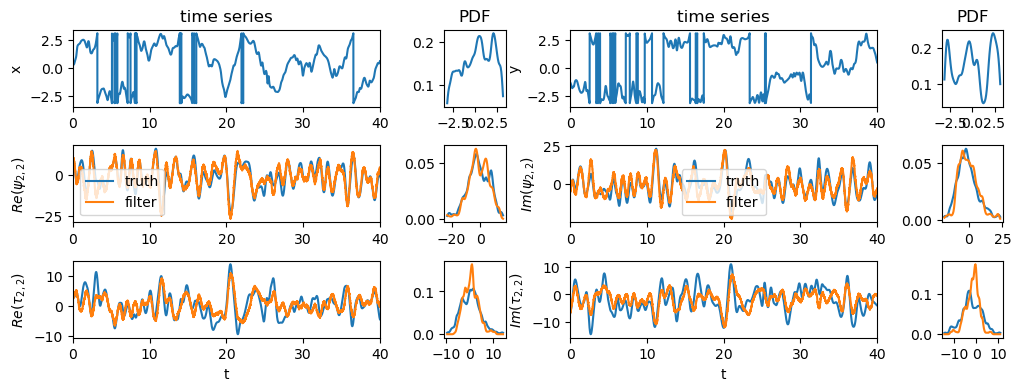

In [198]:
# Plot
sel0 = 0; sel1 = N # plot time range
ikx = 2; iky = 2 # mode to plot
interv = 10 # plot interval
xaxis = np.arange(sel0*dt, sel1*dt, interv*dt)

fig = plt.figure(figsize=(12,4))
widths = [5, 1, 5, 1]
heights = [2, 2, 2]
spec = fig.add_gridspec(ncols=4, nrows=3, width_ratios=widths, height_ratios=heights)

plt.subplots_adjust(wspace=0.35, hspace=0.5)     # Adjust the overall spacing of the figure
ax1 = fig.add_subplot(spec[0, 0])
ax2 = fig.add_subplot(spec[1, 0])
ax3 = fig.add_subplot(spec[2, 0])
ax4 = fig.add_subplot(spec[0, 1])
ax5 = fig.add_subplot(spec[1, 1])
ax6 = fig.add_subplot(spec[2, 1])
ax11 = fig.add_subplot(spec[0, 2])
ax22 = fig.add_subplot(spec[1, 2])
ax33 = fig.add_subplot(spec[2, 2])
ax44 = fig.add_subplot(spec[0, 3])
ax55 = fig.add_subplot(spec[1, 3])
ax66 = fig.add_subplot(spec[2, 3])

# plot time series
ax1.plot(xaxis, xt[0,sel0:sel1:interv], label='x')
ax1.set_xlim(sel0*dt, sel1*dt)
ax1.set_ylabel('x')
ax1.set_title('time series')

ax2.plot(xaxis, psi_t_k[iky,ikx,sel0:sel1:interv].real, label='truth')
ax2.plot(xaxis, psi_k_pos[iky,ikx,sel0:sel1:interv].real, label='filter')
ax2.set_xlim(sel0*dt, sel1*dt)
ax2.set_ylabel('$Re(\psi_{{{:d},{:d}}})$'.format(ikx, iky))
ax2.legend()

ax3.plot(xaxis, tau_t_k[iky,ikx,sel0:sel1:interv].real, label='truth')
ax3.plot(xaxis, tau_k_pos[iky,ikx,sel0:sel1:interv].real, label='filter')
ax3.set_xlim(sel0*dt, sel1*dt)
ax3.set_ylabel(r'$Re(\tau_{{{:d},{:d}}})$'.format(ikx, iky))
ax3.set_xlabel('t')

# plot pdf
samples = xt[0, :]
kde = gaussian_kde(samples)
xticks = np.linspace(samples.min(), samples.max(), 100)
p = kde.evaluate(xticks)
ax4.plot(xticks, p)
ax4.set_title('PDF')

samples = psi_t_k[iky, ikx, :].real
kde = gaussian_kde(samples)
xticks = np.linspace(samples.min(), samples.max(), 100)
p = kde.evaluate(xticks)
ax5.plot(xticks, p, label='truth')
samples = psi_k_pos[iky, ikx, :].real
kde = gaussian_kde(samples)
p = kde.evaluate(xticks)
ax5.plot(xticks, p, label='filter')

samples = tau_t_k[iky, ikx, :].real
kde = gaussian_kde(samples)
xticks = np.linspace(samples.min(), samples.max(), 100)
p = kde.evaluate(xticks)
ax6.plot(xticks, p, label='truth')
samples = tau_k_pos[iky, ikx, :].real
kde = gaussian_kde(samples)
p = kde.evaluate(xticks)
ax6.plot(xticks, p, label='filter')

ax11.plot(xaxis, yt[0,sel0:sel1:interv])
ax11.set_xlim(sel0*dt, sel1*dt)
ax11.set_ylabel('y')
ax11.set_title('time series')

ax22.plot(xaxis, psi_t_k[iky,ikx,sel0:sel1:interv].imag, label='truth')
ax22.plot(xaxis, psi_k_pos[iky,ikx,sel0:sel1:interv].imag, label='filter')
ax22.set_xlim(sel0*dt, sel1*dt)
ax22.set_ylabel('$Im(\psi_{{{:d},{:d}}})$'.format(ikx, iky))
ax22.legend()

ax33.plot(xaxis, tau_t_k[iky,ikx,sel0:sel1:interv].imag, label='truth')
ax33.plot(xaxis, tau_k_pos[iky,ikx,sel0:sel1:interv].imag, label='filter')
ax33.set_xlim(sel0*dt, sel1*dt)
ax33.set_ylabel(r'$Im(\tau_{{{:d},{:d}}})$'.format(ikx, iky))
ax33.set_xlabel('t')

# plot pdf
samples = yt[0, :]
kde = gaussian_kde(samples)
xticks = np.linspace(samples.min(), samples.max(), 100)
p = kde.evaluate(xticks)
ax44.plot(xticks, p)
ax44.set_title('PDF')

samples = psi_t_k[iky, ikx, :].imag
kde = gaussian_kde(samples)
xticks = np.linspace(samples.min(), samples.max(), 100)
p = kde.evaluate(xticks)
ax55.plot(xticks, p, label='truth')
samples = psi_k_pos[iky, ikx, :].imag
kde = gaussian_kde(samples)
p = kde.evaluate(xticks)
ax55.plot(xticks, p, label='filter')

samples = tau_t_k[iky, ikx, :].imag
kde = gaussian_kde(samples)
xticks = np.linspace(samples.min(), samples.max(), 100)
p = kde.evaluate(xticks)
ax66.plot(xticks, p, label='truth')
samples = tau_k_pos[iky, ikx, :].imag
kde = gaussian_kde(samples)
p = kde.evaluate(xticks)
ax66.plot(xticks, p, label='filter')
# plt.savefig('./Lagrangian_DA/LagDA_K16_L64.png',dpi=100)
plt.show()

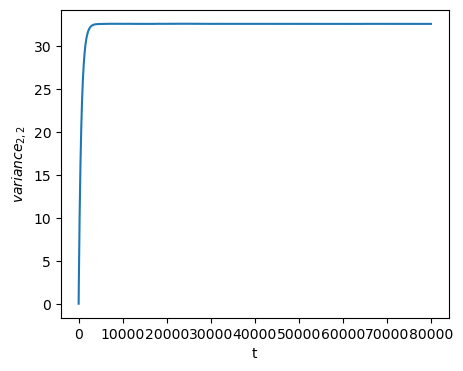

In [199]:
# plot R
R_psi_k_pos, R_tau_k_pos = mu2psi(R_t, K, cut)
plt.figure(figsize=(5,4))
plt.plot(R_psi_k_pos[ikx,ikx,:])
plt.xlabel('t')
plt.ylabel(r'$variance_{{{:d},{:d}}}$'.format(ikx, iky))
# plt.savefig('./Lagrangian_DA/var_L64.png')
plt.show()

## Different L

In [3]:
# load data
eigens = np.load('../data/eigens_K16_beta60.npy', allow_pickle=True)
omega1 = eigens.item()['omega1']
omega2 = eigens.item()['omega2']
r1 = eigens.item()['r1']
r2 = eigens.item()['r2']
K = omega1.shape[0]
ou_run = np.load('../data/ou_run_K16_beta60_conj.npz')
psi_t_k = ou_run['psi_k']
tau_t_k = ou_run['tau_k']
cut = ou_run['cut'].item()
dt = ou_run['dt'].item()
psi1_k_t, psi2_k_t = eigen2layer(K,cut,r1,r2,psi_t_k,tau_t_k)

In [4]:
verify_conjugate_symmetry(psi1_k_t[:,:,10])

True

In [5]:
# load data
params = np.load('../data/est_paras_ou_K16_beta60_conj.npy', allow_pickle=True).item()
gamma, omega, f, sigma = params['gamma'], params['omega'], params['f'], params['sigma']
eigens = np.load('../data/eigens_K16_beta60.npy', allow_pickle=True)
omega1 = eigens.item()['omega1']
omega2 = eigens.item()['omega2']
r1 = eigens.item()['r1']
r2 = eigens.item()['r2']
# file = np.load('../data/psi_k_truth_K16_beta22.npz') # obtain the true underlying flow ($\boldsymbol{\Psi}^\bot$)
# psi_t_k = file['psi_t_k']
# tau_t_k = file['tau_t_k']
# cut = file['cut'].item()

# run obs model
Ls = [8,16,32,64,128,256] # number of tracers
K = psi1_k_t.shape[0]
N = 20000 #psi1_k_t.shape[2]
kx = np.fft.fftfreq(K) * K
ky = np.fft.fftfreq(K) * K
sigma_xy = 0.01
x_ts = []
y_ts = []
mu_ts = []
R_ts = []

# run DA for different L
for L in Ls:
    print(L)
    x0 = np.random.uniform(-np.pi, np.pi, L)
    y0 = np.random.uniform(-np.pi, np.pi, L)
    
    t0 = time()
    # run model
    model = Lagrange_tracer_model(N, L, kx, ky, psi1_k_t, dt, sigma_xy, x0, y0, interv=1)
    xt, yt, ut, vt = model.forward()  
    t1 = time()
    print('tracer model time:', t1-t0)

    # DA
    da = Lagrangian_DA(N, K, psi_t_k, tau_t_k, r1, r2, dt, sigma_xy, f, gamma, omega, sigma, xt, yt, cut)
    mu_t, R_t = da.forward()
    t2 = time()
    print('da time:', t2-t1)
    
    x_ts.append(xt)
    y_ts.append(yt)
    mu_ts.append(mu_t)
    R_ts.append(R_t)

8


/Users/ree/Documents/Research/Proj_1_LangrangeDA/code/Lagrange_tracer.py:126: ComplexWarning: Casting complex values to real discards the imaginary part
  self.ut[:,:,l] = u_ifft_shift[::self.interv, ::self.interv] # only save the sparsely sampled grids
/Users/ree/Documents/Research/Proj_1_LangrangeDA/code/Lagrange_tracer.py:130: ComplexWarning: Casting complex values to real discards the imaginary part
  self.vt[:,:,l] = v_ifft_shift[::self.interv, ::self.interv] # only save the sparsely sampled grids


tracer model time: 1.4107558727264404
da time: 91.23424625396729
16
tracer model time: 2.27744197845459
da time: 105.43291091918945
32
tracer model time: 6.003947019577026
da time: 143.73602318763733
64
tracer model time: 10.769920110702515
da time: 237.11145186424255
128
tracer model time: 23.7309410572052
da time: 414.97852993011475
256
tracer model time: 47.501039028167725
da time: 743.5064082145691


In [6]:
def mu2psi(mu_t, K, cut):
    n = K-cut*2-1
    mu_t = mu_t.reshape((n,n,2,-1), order='F')
    psi_k = mu_t[:,:,0]
    tau_k = mu_t[:,:,1]
    
    return psi_k, tau_k

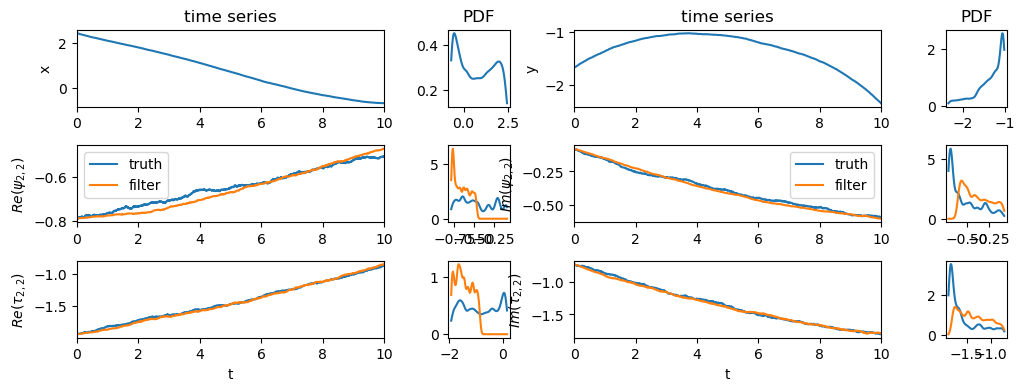

In [12]:
# Plot
psi_k_pos, tau_k_pos = mu2psi(mu_ts[-1], K, cut)

sel0 = 0; sel1 = N # plot time range
ikx = 2; iky = 2 # mode to plot
interv = 10 # plot interval
xaxis = np.arange(sel0*dt, sel1*dt, interv*dt)

fig = plt.figure(figsize=(12,4))
widths = [5, 1, 5, 1]
heights = [2, 2, 2]
spec = fig.add_gridspec(ncols=4, nrows=3, width_ratios=widths, height_ratios=heights)

plt.subplots_adjust(wspace=0.35, hspace=0.5)     # Adjust the overall spacing of the figure
ax1 = fig.add_subplot(spec[0, 0])
ax2 = fig.add_subplot(spec[1, 0])
ax3 = fig.add_subplot(spec[2, 0])
ax4 = fig.add_subplot(spec[0, 1])
ax5 = fig.add_subplot(spec[1, 1])
ax6 = fig.add_subplot(spec[2, 1])
ax11 = fig.add_subplot(spec[0, 2])
ax22 = fig.add_subplot(spec[1, 2])
ax33 = fig.add_subplot(spec[2, 2])
ax44 = fig.add_subplot(spec[0, 3])
ax55 = fig.add_subplot(spec[1, 3])
ax66 = fig.add_subplot(spec[2, 3])

# plot time series
ax1.plot(xaxis, xt[0,sel0:sel1:interv], label='x')
ax1.set_xlim(sel0*dt, sel1*dt)
ax1.set_ylabel('x')
ax1.set_title('time series')

ax2.plot(xaxis, psi_t_k[iky,ikx,sel0:sel1:interv].real, label='truth')
ax2.plot(xaxis, psi_k_pos[iky,ikx,sel0:sel1:interv].real, label='filter')
ax2.set_xlim(sel0*dt, sel1*dt)
ax2.set_ylabel('$Re(\psi_{{{:d},{:d}}})$'.format(ikx, iky))
ax2.legend()

ax3.plot(xaxis, tau_t_k[iky,ikx,sel0:sel1:interv].real, label='truth')
ax3.plot(xaxis, tau_k_pos[iky,ikx,sel0:sel1:interv].real, label='filter')
ax3.set_xlim(sel0*dt, sel1*dt)
ax3.set_ylabel(r'$Re(\tau_{{{:d},{:d}}})$'.format(ikx, iky))
ax3.set_xlabel('t')

# plot pdf
samples = xt[0, :]
kde = gaussian_kde(samples)
xticks = np.linspace(samples.min(), samples.max(), 100)
p = kde.evaluate(xticks)
ax4.plot(xticks, p)
ax4.set_title('PDF')

samples = psi_t_k[iky, ikx, :].real
kde = gaussian_kde(samples)
xticks = np.linspace(samples.min(), samples.max(), 100)
p = kde.evaluate(xticks)
ax5.plot(xticks, p, label='truth')
samples = psi_k_pos[iky, ikx, :].real
kde = gaussian_kde(samples)
p = kde.evaluate(xticks)
ax5.plot(xticks, p, label='filter')

samples = tau_t_k[iky, ikx, :].real
kde = gaussian_kde(samples)
xticks = np.linspace(samples.min(), samples.max(), 100)
p = kde.evaluate(xticks)
ax6.plot(xticks, p, label='truth')
samples = tau_k_pos[iky, ikx, :].real
kde = gaussian_kde(samples)
p = kde.evaluate(xticks)
ax6.plot(xticks, p, label='filter')

ax11.plot(xaxis, yt[0,sel0:sel1:interv])
ax11.set_xlim(sel0*dt, sel1*dt)
ax11.set_ylabel('y')
ax11.set_title('time series')

ax22.plot(xaxis, psi_t_k[iky,ikx,sel0:sel1:interv].imag, label='truth')
ax22.plot(xaxis, psi_k_pos[iky,ikx,sel0:sel1:interv].imag, label='filter')
ax22.set_xlim(sel0*dt, sel1*dt)
ax22.set_ylabel('$Im(\psi_{{{:d},{:d}}})$'.format(ikx, iky))
ax22.legend()

ax33.plot(xaxis, tau_t_k[iky,ikx,sel0:sel1:interv].imag, label='truth')
ax33.plot(xaxis, tau_k_pos[iky,ikx,sel0:sel1:interv].imag, label='filter')
ax33.set_xlim(sel0*dt, sel1*dt)
ax33.set_ylabel(r'$Im(\tau_{{{:d},{:d}}})$'.format(ikx, iky))
ax33.set_xlabel('t')

# plot pdf
samples = yt[0, :]
kde = gaussian_kde(samples)
xticks = np.linspace(samples.min(), samples.max(), 100)
p = kde.evaluate(xticks)
ax44.plot(xticks, p)
ax44.set_title('PDF')

samples = psi_t_k[iky, ikx, :].imag
kde = gaussian_kde(samples)
xticks = np.linspace(samples.min(), samples.max(), 100)
p = kde.evaluate(xticks)
ax55.plot(xticks, p, label='truth')
samples = psi_k_pos[iky, ikx, :].imag
kde = gaussian_kde(samples)
p = kde.evaluate(xticks)
ax55.plot(xticks, p, label='filter')

samples = tau_t_k[iky, ikx, :].imag
kde = gaussian_kde(samples)
xticks = np.linspace(samples.min(), samples.max(), 100)
p = kde.evaluate(xticks)
ax66.plot(xticks, p, label='truth')
samples = tau_k_pos[iky, ikx, :].imag
kde = gaussian_kde(samples)
p = kde.evaluate(xticks)
ax66.plot(xticks, p, label='filter')
# plt.savefig('./Lagrangian_DA/LagDA_K16_L64_eigen.png',dpi=100)
plt.show()

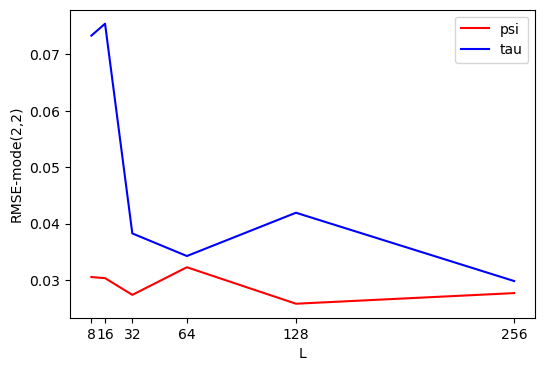

In [9]:
# evaluation
rmses_psi = []
rmses_tau = []
sel0 = 0; sel1 = N
ikx = 2; iky = 2
for il, L in enumerate(Ls):
    psi_k_pos, tau_k_pos = mu2psi(mu_ts[il], K, cut)
    rmse_psi = np.sqrt(np.mean(np.abs(psi_t_k[iky,ikx,sel0:sel1] - psi_k_pos[iky,ikx,sel0:sel1])**2))
    rmse_tau = np.sqrt(np.mean(np.abs(tau_t_k[iky,ikx,sel0:sel1] - tau_k_pos[iky,ikx,sel0:sel1])**2))
    rmses_psi.append(rmse_psi)    
    rmses_tau.append(rmse_tau)
    
fig = plt.figure(figsize=(6,4))
plt.plot(Ls, rmses_psi, 'r', label='psi')
plt.plot(Ls, rmses_tau, 'b', label='tau')
plt.xticks(Ls)
plt.xlabel('L')
plt.ylabel('RMSE-mode({:d},{:d})'.format(ikx,iky))
plt.legend()
# plt.savefig('./Lagrangian_DA/rmse_diff_L_eigen.png', dpi=100)
plt.show()

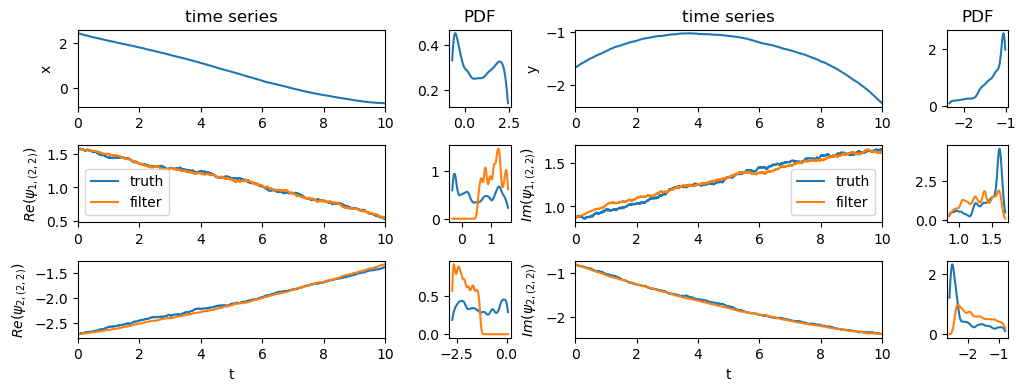

In [10]:
# Plot
psi_k_pos, tau_k_pos = mu2psi(mu_ts[-1], K, cut)
psi_k_pos_ = inv_truncate(psi_k_pos, cut)
tau_k_pos_ = inv_truncate(tau_k_pos, cut)
psi1_k_pos, psi2_k_pos = eigen2layer(K,cut,r1,r2,psi_k_pos_,tau_k_pos_)

sel0 = 0; sel1 = N # plot time range
ikx = 2; iky = 2 # mode to plot
interv = 10 # plot interval
xaxis = np.arange(sel0*dt, sel1*dt, interv*dt)

fig = plt.figure(figsize=(12,4))
widths = [5, 1, 5, 1]
heights = [2, 2, 2]
spec = fig.add_gridspec(ncols=4, nrows=3, width_ratios=widths, height_ratios=heights)

plt.subplots_adjust(wspace=0.35, hspace=0.5)     # Adjust the overall spacing of the figure
ax1 = fig.add_subplot(spec[0, 0])
ax2 = fig.add_subplot(spec[1, 0])
ax3 = fig.add_subplot(spec[2, 0])
ax4 = fig.add_subplot(spec[0, 1])
ax5 = fig.add_subplot(spec[1, 1])
ax6 = fig.add_subplot(spec[2, 1])
ax11 = fig.add_subplot(spec[0, 2])
ax22 = fig.add_subplot(spec[1, 2])
ax33 = fig.add_subplot(spec[2, 2])
ax44 = fig.add_subplot(spec[0, 3])
ax55 = fig.add_subplot(spec[1, 3])
ax66 = fig.add_subplot(spec[2, 3])

# plot time series
ax1.plot(xaxis, xt[0,sel0:sel1:interv], label='x')
ax1.set_xlim(sel0*dt, sel1*dt)
ax1.set_ylabel('x')
ax1.set_title('time series')

ax2.plot(xaxis, psi1_k_t[iky,ikx,sel0:sel1:interv].real, label='truth')
ax2.plot(xaxis, psi1_k_pos[iky,ikx,sel0:sel1:interv].real, label='filter')
ax2.set_xlim(sel0*dt, sel1*dt)
ax2.set_ylabel('$Re(\psi_{{1,({:d},{:d})}})$'.format(ikx, iky))
ax2.legend()

ax3.plot(xaxis, psi2_k_t[iky,ikx,sel0:sel1:interv].real, label='truth')
ax3.plot(xaxis, psi2_k_pos[iky,ikx,sel0:sel1:interv].real, label='filter')
ax3.set_xlim(sel0*dt, sel1*dt)
ax3.set_ylabel(r'$Re(\psi_{{2,({:d},{:d})}})$'.format(ikx, iky))
ax3.set_xlabel('t')

# plot pdf
samples = xt[0, :]
kde = gaussian_kde(samples)
xticks = np.linspace(samples.min(), samples.max(), 100)
p = kde.evaluate(xticks)
ax4.plot(xticks, p)
ax4.set_title('PDF')

samples = psi1_k_t[iky, ikx, :].real
kde = gaussian_kde(samples)
xticks = np.linspace(samples.min(), samples.max(), 100)
p = kde.evaluate(xticks)
ax5.plot(xticks, p, label='truth')
samples = psi1_k_pos[iky, ikx, :].real
kde = gaussian_kde(samples)
p = kde.evaluate(xticks)
ax5.plot(xticks, p, label='filter')

samples = psi2_k_t[iky, ikx, :].real
kde = gaussian_kde(samples)
xticks = np.linspace(samples.min(), samples.max(), 100)
p = kde.evaluate(xticks)
ax6.plot(xticks, p, label='truth')
samples = psi2_k_pos[iky, ikx, :].real
kde = gaussian_kde(samples)
p = kde.evaluate(xticks)
ax6.plot(xticks, p, label='filter')

ax11.plot(xaxis, yt[0,sel0:sel1:interv])
ax11.set_xlim(sel0*dt, sel1*dt)
ax11.set_ylabel('y')
ax11.set_title('time series')

ax22.plot(xaxis, psi1_k_t[iky,ikx,sel0:sel1:interv].imag, label='truth')
ax22.plot(xaxis, psi1_k_pos[iky,ikx,sel0:sel1:interv].imag, label='filter')
ax22.set_xlim(sel0*dt, sel1*dt)
ax22.set_ylabel('$Im(\psi_{{1,({:d},{:d})}})$'.format(ikx, iky))
ax22.legend()

ax33.plot(xaxis, psi2_k_t[iky,ikx,sel0:sel1:interv].imag, label='truth')
ax33.plot(xaxis, psi2_k_pos[iky,ikx,sel0:sel1:interv].imag, label='filter')
ax33.set_xlim(sel0*dt, sel1*dt)
ax33.set_ylabel(r'$Im(\psi_{{2,({:d},{:d})}})$'.format(ikx, iky))
ax33.set_xlabel('t')

# plot pdf
samples = yt[0, :]
kde = gaussian_kde(samples)
xticks = np.linspace(samples.min(), samples.max(), 100)
p = kde.evaluate(xticks)
ax44.plot(xticks, p)
ax44.set_title('PDF')

samples = psi1_k_t[iky, ikx, :].imag
kde = gaussian_kde(samples)
xticks = np.linspace(samples.min(), samples.max(), 100)
p = kde.evaluate(xticks)
ax55.plot(xticks, p, label='truth')
samples = psi1_k_pos[iky, ikx, :].imag
kde = gaussian_kde(samples)
p = kde.evaluate(xticks)
ax55.plot(xticks, p, label='filter')

samples = psi2_k_t[iky, ikx, :].imag
kde = gaussian_kde(samples)
xticks = np.linspace(samples.min(), samples.max(), 100)
p = kde.evaluate(xticks)
ax66.plot(xticks, p, label='truth')
samples = psi2_k_pos[iky, ikx, :].imag
kde = gaussian_kde(samples)
p = kde.evaluate(xticks)
ax66.plot(xticks, p, label='filter')
# plt.savefig('./Lagrangian_DA/LagDA_K16_L64_layer.png',dpi=100)
plt.show()

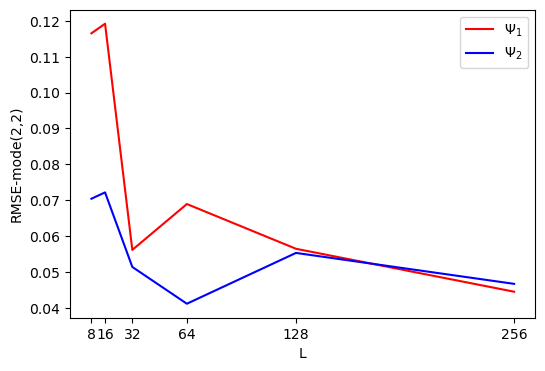

In [11]:
# evaluation
rmses_psi1 = []
rmses_psi2 = []
sel0 = 0; sel1 = psi1_k_pos.shape[-1] 
ikx = 2; iky = 2
for il, L in enumerate(Ls):
    psi_k_pos, tau_k_pos = mu2psi(mu_ts[il], K, cut)
    psi_k_pos_ = inv_truncate(psi_k_pos, cut)
    tau_k_pos_ = inv_truncate(tau_k_pos, cut)
    psi1_k_pos, psi2_k_pos = eigen2layer(K,cut,r1,r2,psi_k_pos_,tau_k_pos_)
    rmse_psi1 = np.sqrt(np.mean(np.abs(psi1_k_t[iky,ikx,sel0:sel1] - psi1_k_pos[iky,ikx,sel0:sel1])**2))
    rmse_psi2 = np.sqrt(np.mean(np.abs(psi2_k_t[iky,ikx,sel0:sel1] - psi2_k_pos[iky,ikx,sel0:sel1])**2))
    rmses_psi1.append(rmse_psi1)    
    rmses_psi2.append(rmse_psi2)
    
fig = plt.figure(figsize=(6,4))
plt.plot(Ls, rmses_psi1, 'r', label='$\Psi_1$')
plt.plot(Ls, rmses_psi2, 'b', label='$\Psi_2$')
plt.xticks(Ls)
plt.xlabel('L')
plt.ylabel('RMSE-mode({:d},{:d})'.format(ikx,iky))
plt.legend()
# plt.savefig('./Lagrangian_DA/rmse_diff_L_layer.png', dpi=100)
plt.show()

In [13]:
# check correlation of lower and upper layer modes
ikx=2; iky=2
print('mode:{:d},{:d}'.format(ikx,iky))
print('correlation of real-real:', np.corrcoef(psi1_k_t[iky,ikx,:].real,psi2_k_t[iky,ikx,:].real)[0,1])
print('correlation of imag-imag:', np.corrcoef(psi1_k_t[iky,ikx,:].imag,psi2_k_t[iky,ikx,:].imag)[0,1])

mode:2,2
correlation of real-real: -0.9968716758518864
correlation of imag-imag: -0.9301441898675218


## imperfect model

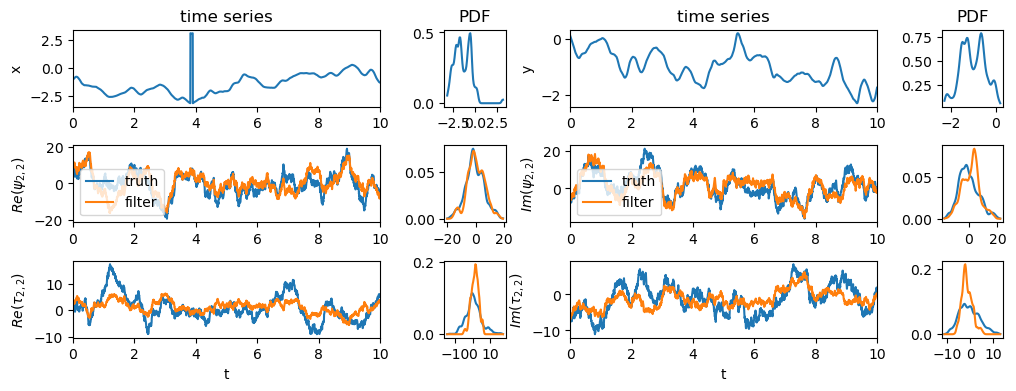

In [81]:
# Plot
psi_k_pos, tau_k_pos = mu2psi(mu_ts[-1], K, cut)

sel0 = 0; sel1 = N # plot time range
ikx = 2; iky = 2 # mode to plot
interv = 10 # plot interval
xaxis = np.arange(sel0*dt, sel1*dt, interv*dt)

fig = plt.figure(figsize=(12,4))
widths = [5, 1, 5, 1]
heights = [2, 2, 2]
spec = fig.add_gridspec(ncols=4, nrows=3, width_ratios=widths, height_ratios=heights)

plt.subplots_adjust(wspace=0.35, hspace=0.5)     # Adjust the overall spacing of the figure
ax1 = fig.add_subplot(spec[0, 0])
ax2 = fig.add_subplot(spec[1, 0])
ax3 = fig.add_subplot(spec[2, 0])
ax4 = fig.add_subplot(spec[0, 1])
ax5 = fig.add_subplot(spec[1, 1])
ax6 = fig.add_subplot(spec[2, 1])
ax11 = fig.add_subplot(spec[0, 2])
ax22 = fig.add_subplot(spec[1, 2])
ax33 = fig.add_subplot(spec[2, 2])
ax44 = fig.add_subplot(spec[0, 3])
ax55 = fig.add_subplot(spec[1, 3])
ax66 = fig.add_subplot(spec[2, 3])

# plot time series
ax1.plot(xaxis, xt[0,sel0:sel1:interv], label='x')
ax1.set_xlim(sel0*dt, sel1*dt)
ax1.set_ylabel('x')
ax1.set_title('time series')

ax2.plot(xaxis, psi_t_k[iky,ikx,sel0:sel1:interv].real, label='truth')
ax2.plot(xaxis, psi_k_pos[iky,ikx,sel0:sel1:interv].real, label='filter')
ax2.set_xlim(sel0*dt, sel1*dt)
ax2.set_ylabel('$Re(\psi_{{{:d},{:d}}})$'.format(ikx, iky))
ax2.legend()

ax3.plot(xaxis, tau_t_k[iky,ikx,sel0:sel1:interv].real, label='truth')
ax3.plot(xaxis, tau_k_pos[iky,ikx,sel0:sel1:interv].real, label='filter')
ax3.set_xlim(sel0*dt, sel1*dt)
ax3.set_ylabel(r'$Re(\tau_{{{:d},{:d}}})$'.format(ikx, iky))
ax3.set_xlabel('t')

# plot pdf
samples = xt[0, :]
kde = gaussian_kde(samples)
xticks = np.linspace(samples.min(), samples.max(), 100)
p = kde.evaluate(xticks)
ax4.plot(xticks, p)
ax4.set_title('PDF')

samples = psi_t_k[iky, ikx, :].real
kde = gaussian_kde(samples)
xticks = np.linspace(samples.min(), samples.max(), 100)
p = kde.evaluate(xticks)
ax5.plot(xticks, p, label='truth')
samples = psi_k_pos[iky, ikx, :].real
kde = gaussian_kde(samples)
p = kde.evaluate(xticks)
ax5.plot(xticks, p, label='filter')

samples = tau_t_k[iky, ikx, :].real
kde = gaussian_kde(samples)
xticks = np.linspace(samples.min(), samples.max(), 100)
p = kde.evaluate(xticks)
ax6.plot(xticks, p, label='truth')
samples = tau_k_pos[iky, ikx, :].real
kde = gaussian_kde(samples)
p = kde.evaluate(xticks)
ax6.plot(xticks, p, label='filter')

ax11.plot(xaxis, yt[0,sel0:sel1:interv])
ax11.set_xlim(sel0*dt, sel1*dt)
ax11.set_ylabel('y')
ax11.set_title('time series')

ax22.plot(xaxis, psi_t_k[iky,ikx,sel0:sel1:interv].imag, label='truth')
ax22.plot(xaxis, psi_k_pos[iky,ikx,sel0:sel1:interv].imag, label='filter')
ax22.set_xlim(sel0*dt, sel1*dt)
ax22.set_ylabel('$Im(\psi_{{{:d},{:d}}})$'.format(ikx, iky))
ax22.legend()

ax33.plot(xaxis, tau_t_k[iky,ikx,sel0:sel1:interv].imag, label='truth')
ax33.plot(xaxis, tau_k_pos[iky,ikx,sel0:sel1:interv].imag, label='filter')
ax33.set_xlim(sel0*dt, sel1*dt)
ax33.set_ylabel(r'$Im(\tau_{{{:d},{:d}}})$'.format(ikx, iky))
ax33.set_xlabel('t')

# plot pdf
samples = yt[0, :]
kde = gaussian_kde(samples)
xticks = np.linspace(samples.min(), samples.max(), 100)
p = kde.evaluate(xticks)
ax44.plot(xticks, p)
ax44.set_title('PDF')

samples = psi_t_k[iky, ikx, :].imag
kde = gaussian_kde(samples)
xticks = np.linspace(samples.min(), samples.max(), 100)
p = kde.evaluate(xticks)
ax55.plot(xticks, p, label='truth')
samples = psi_k_pos[iky, ikx, :].imag
kde = gaussian_kde(samples)
p = kde.evaluate(xticks)
ax55.plot(xticks, p, label='filter')

samples = tau_t_k[iky, ikx, :].imag
kde = gaussian_kde(samples)
xticks = np.linspace(samples.min(), samples.max(), 100)
p = kde.evaluate(xticks)
ax66.plot(xticks, p, label='truth')
samples = tau_k_pos[iky, ikx, :].imag
kde = gaussian_kde(samples)
p = kde.evaluate(xticks)
ax66.plot(xticks, p, label='filter')
plt.savefig('./Lagrangian_DA/LagDA_K16_L64_eigen.png',dpi=100)
plt.show()

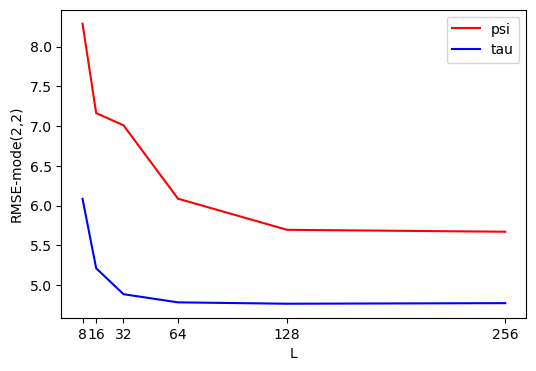

In [83]:
# evaluation
rmses_psi = []
rmses_tau = []
sel0 = 0; sel1 = N
ikx = 2; iky = 2
for il, L in enumerate(Ls):
    psi_k_pos, tau_k_pos = mu2psi(mu_ts[il], K, cut)
    rmse_psi = np.sqrt(np.mean(np.abs(psi_t_k[iky,ikx,sel0:sel1] - psi_k_pos[iky,ikx,sel0:sel1])**2))
    rmse_tau = np.sqrt(np.mean(np.abs(tau_t_k[iky,ikx,sel0:sel1] - tau_k_pos[iky,ikx,sel0:sel1])**2))
    rmses_psi.append(rmse_psi)    
    rmses_tau.append(rmse_tau)
    
fig = plt.figure(figsize=(6,4))
plt.plot(Ls, rmses_psi, 'r', label='psi')
plt.plot(Ls, rmses_tau, 'b', label='tau')
plt.xticks(Ls)
plt.xlabel('L')
plt.ylabel('RMSE-mode({:d},{:d})'.format(ikx,iky))
plt.legend()
plt.savefig('./Lagrangian_DA/rmse_diff_L_eigen.png', dpi=100)
plt.show()

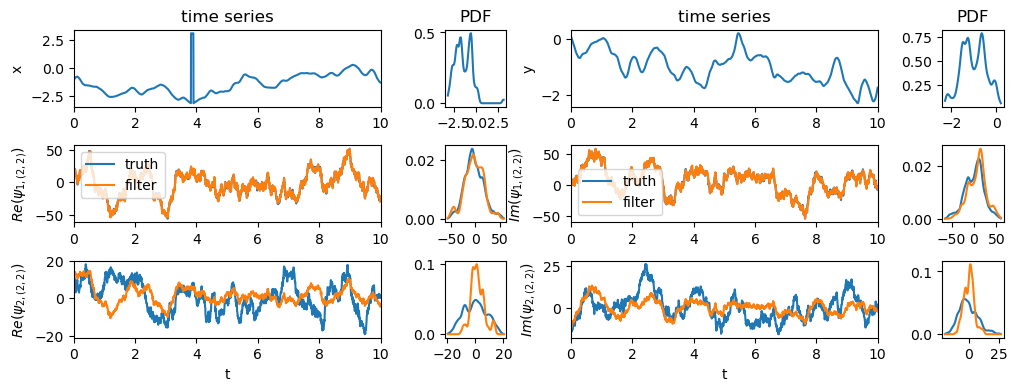

In [79]:
# Plot
psi_k_pos, tau_k_pos = mu2psi(mu_ts[-1], K, cut)
psi_k_pos_ = inv_truncate(psi_k_pos, cut)
tau_k_pos_ = inv_truncate(tau_k_pos, cut)
psi1_k_pos, psi2_k_pos = eigen2layer(K,cut,r1,r2,psi_k_pos_,tau_k_pos_)

sel0 = 0; sel1 = N # plot time range
ikx = 2; iky = 2 # mode to plot
interv = 10 # plot interval
xaxis = np.arange(sel0*dt, sel1*dt, interv*dt)

fig = plt.figure(figsize=(12,4))
widths = [5, 1, 5, 1]
heights = [2, 2, 2]
spec = fig.add_gridspec(ncols=4, nrows=3, width_ratios=widths, height_ratios=heights)

plt.subplots_adjust(wspace=0.35, hspace=0.5)     # Adjust the overall spacing of the figure
ax1 = fig.add_subplot(spec[0, 0])
ax2 = fig.add_subplot(spec[1, 0])
ax3 = fig.add_subplot(spec[2, 0])
ax4 = fig.add_subplot(spec[0, 1])
ax5 = fig.add_subplot(spec[1, 1])
ax6 = fig.add_subplot(spec[2, 1])
ax11 = fig.add_subplot(spec[0, 2])
ax22 = fig.add_subplot(spec[1, 2])
ax33 = fig.add_subplot(spec[2, 2])
ax44 = fig.add_subplot(spec[0, 3])
ax55 = fig.add_subplot(spec[1, 3])
ax66 = fig.add_subplot(spec[2, 3])

# plot time series
ax1.plot(xaxis, xt[0,sel0:sel1:interv], label='x')
ax1.set_xlim(sel0*dt, sel1*dt)
ax1.set_ylabel('x')
ax1.set_title('time series')

ax2.plot(xaxis, psi1_k_t[iky,ikx,sel0:sel1:interv].real, label='truth')
ax2.plot(xaxis, psi1_k_pos[iky,ikx,sel0:sel1:interv].real, label='filter')
ax2.set_xlim(sel0*dt, sel1*dt)
ax2.set_ylabel('$Re(\psi_{{1,({:d},{:d})}})$'.format(ikx, iky))
ax2.legend()

ax3.plot(xaxis, psi2_k_t[iky,ikx,sel0:sel1:interv].real, label='truth')
ax3.plot(xaxis, psi2_k_pos[iky,ikx,sel0:sel1:interv].real, label='filter')
ax3.set_xlim(sel0*dt, sel1*dt)
ax3.set_ylabel(r'$Re(\psi_{{2,({:d},{:d})}})$'.format(ikx, iky))
ax3.set_xlabel('t')

# plot pdf
samples = xt[0, :]
kde = gaussian_kde(samples)
xticks = np.linspace(samples.min(), samples.max(), 100)
p = kde.evaluate(xticks)
ax4.plot(xticks, p)
ax4.set_title('PDF')

samples = psi1_k_t[iky, ikx, :].real
kde = gaussian_kde(samples)
xticks = np.linspace(samples.min(), samples.max(), 100)
p = kde.evaluate(xticks)
ax5.plot(xticks, p, label='truth')
samples = psi1_k_pos[iky, ikx, :].real
kde = gaussian_kde(samples)
p = kde.evaluate(xticks)
ax5.plot(xticks, p, label='filter')

samples = psi2_k_t[iky, ikx, :].real
kde = gaussian_kde(samples)
xticks = np.linspace(samples.min(), samples.max(), 100)
p = kde.evaluate(xticks)
ax6.plot(xticks, p, label='truth')
samples = psi2_k_pos[iky, ikx, :].real
kde = gaussian_kde(samples)
p = kde.evaluate(xticks)
ax6.plot(xticks, p, label='filter')

ax11.plot(xaxis, yt[0,sel0:sel1:interv])
ax11.set_xlim(sel0*dt, sel1*dt)
ax11.set_ylabel('y')
ax11.set_title('time series')

ax22.plot(xaxis, psi1_k_t[iky,ikx,sel0:sel1:interv].imag, label='truth')
ax22.plot(xaxis, psi1_k_pos[iky,ikx,sel0:sel1:interv].imag, label='filter')
ax22.set_xlim(sel0*dt, sel1*dt)
ax22.set_ylabel('$Im(\psi_{{1,({:d},{:d})}})$'.format(ikx, iky))
ax22.legend()

ax33.plot(xaxis, psi2_k_t[iky,ikx,sel0:sel1:interv].imag, label='truth')
ax33.plot(xaxis, psi2_k_pos[iky,ikx,sel0:sel1:interv].imag, label='filter')
ax33.set_xlim(sel0*dt, sel1*dt)
ax33.set_ylabel(r'$Im(\psi_{{2,({:d},{:d})}})$'.format(ikx, iky))
ax33.set_xlabel('t')

# plot pdf
samples = yt[0, :]
kde = gaussian_kde(samples)
xticks = np.linspace(samples.min(), samples.max(), 100)
p = kde.evaluate(xticks)
ax44.plot(xticks, p)
ax44.set_title('PDF')

samples = psi1_k_t[iky, ikx, :].imag
kde = gaussian_kde(samples)
xticks = np.linspace(samples.min(), samples.max(), 100)
p = kde.evaluate(xticks)
ax55.plot(xticks, p, label='truth')
samples = psi1_k_pos[iky, ikx, :].imag
kde = gaussian_kde(samples)
p = kde.evaluate(xticks)
ax55.plot(xticks, p, label='filter')

samples = psi2_k_t[iky, ikx, :].imag
kde = gaussian_kde(samples)
xticks = np.linspace(samples.min(), samples.max(), 100)
p = kde.evaluate(xticks)
ax66.plot(xticks, p, label='truth')
samples = psi2_k_pos[iky, ikx, :].imag
kde = gaussian_kde(samples)
p = kde.evaluate(xticks)
ax66.plot(xticks, p, label='filter')
plt.savefig('./Lagrangian_DA/LagDA_K16_L64_layer.png',dpi=100)
plt.show()

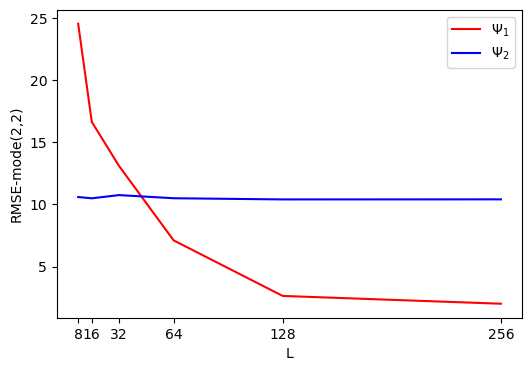

In [80]:
# evaluation
rmses_psi1 = []
rmses_psi2 = []
sel0 = 0; sel1 = psi1_k_pos.shape[-1] 
ikx = 2; iky = 2
for il, L in enumerate(Ls):
    psi_k_pos, tau_k_pos = mu2psi(mu_ts[il], K, cut)
    psi_k_pos_ = inv_truncate(psi_k_pos, cut)
    tau_k_pos_ = inv_truncate(tau_k_pos, cut)
    psi1_k_pos, psi2_k_pos = eigen2layer(K,cut,r1,r2,psi_k_pos_,tau_k_pos_)
    rmse_psi1 = np.sqrt(np.mean(np.abs(psi1_k_t[iky,ikx,sel0:sel1] - psi1_k_pos[iky,ikx,sel0:sel1])**2))
    rmse_psi2 = np.sqrt(np.mean(np.abs(psi2_k_t[iky,ikx,sel0:sel1] - psi2_k_pos[iky,ikx,sel0:sel1])**2))
    rmses_psi1.append(rmse_psi1)    
    rmses_psi2.append(rmse_psi2)
    
fig = plt.figure(figsize=(6,4))
plt.plot(Ls, rmses_psi1, 'r', label='$\Psi_1$')
plt.plot(Ls, rmses_psi2, 'b', label='$\Psi_2$')
plt.xticks(Ls)
plt.xlabel('L')
plt.ylabel('RMSE-mode({:d},{:d})'.format(ikx,iky))
plt.legend()
plt.savefig('./Lagrangian_DA/rmse_diff_L_layer.png', dpi=100)
plt.show()

### fail to recover the lower layer

In [97]:
# check correlation of lower and upper layer modes
ikx=2; iky=2
print('mode:{:d},{:d}'.format(ikx,iky))
print('correlation of real-real:', np.corrcoef(psi1_k_t[iky,ikx,:].real,psi2_k_t[iky,ikx,:].real)[0,1])
print('correlation of imag-imag:', np.corrcoef(psi1_k_t[iky,ikx,:].imag,psi2_k_t[iky,ikx,:].imag)[0,1])

mode:2,2
correlation of real-real: 0.26460986480135507
correlation of imag-imag: 0.3502303273189147


# 2. Lagrangian DA with CG model

In [6]:
# beta = 60
h_hat = np.fft.fft2(topo)

## 2.1 Full QG (imperfect model DA)

### 2.1.1 estimate Sigma based on residual

In [119]:
# estimate Sigma based on residual
def get_coef_mat(KX, KY, K_squared, kd, beta, kappa, U, psi1_hat, psi2_hat, h_hat):
    # psi1_hat, hk should be of shape (N, K, K), if not, reshape them to make it legible
    if psi1_hat.shape[-2:] != KX.shape:
        psi1_hat = np.transpose(psi1_hat, axes=(2,0,1))
    if h_hat.shape[-2:] != KX.shape:
        h_hat = np.transpose(h_hat, axes=(2,0,1))
        
    psi2_hat = np.transpose(psi2_hat, axes=(2,0,1))

    # define Ck for each wave number
    Ck = 1 / (K_squared * (K_squared + kd**2))
    Ck[K_squared == 0] = 0  # avoid division by zero at k = 0

    # linear part for A0, a0, A1 and a1
    linear_A0 = 1j * KX * (((K_squared + kd**2/2)*beta - K_squared**2 * U)*psi1_hat - kd**2/2 * U * h_hat)
    linear_a0 = 1j * KX * ((kd**2/2 * beta - kd**2 * K_squared * U)*psi1_hat - (K_squared + kd**2/2) * U * h_hat)
    linear_A1_diag = 1j * KX * (kd**2/2 * beta + kd**2 * K_squared * U) - (kd**2/2 * kappa * K_squared)
    linear_a1_diag = 1j * KX * ((K_squared + kd**2/2)*beta + K_squared**2 * U) - (K_squared + kd**2/2)* kappa * K_squared
    linear_A1 = np.tile(np.diag(linear_A1_diag.flatten(order='F'))[None,:,:], (psi1_hat.shape[0],1,1)) 
    linear_a1 = np.tile(np.diag(linear_a1_diag.flatten(order='F'))[None,:,:], (psi1_hat.shape[0],1,1)) 
    
    # nonlinear summation part for A0, a0, A1 and a1
    nonlinear_sum_A0 = np.zeros_like(psi1_hat, dtype=complex)
    nonlinear_sum_a0 = np.zeros_like(psi1_hat, dtype=complex)
    nonlinear_sum_A1 = np.zeros_like(linear_A1, dtype=complex)
    nonlinear_sum_a1 = np.zeros_like(linear_a1, dtype=complex)
    k_index_map = {(KX[iy, ix], KY[iy, ix]): (ix, iy) for ix in range(K) for iy in range(K)}
    
    # check 
    det_sum = np.zeros(KX.shape)
    Jacobi_2_diff = np.zeros_like(psi1_hat, dtype=complex)
    
    for mx in range(K):
        for my in range(K):
            m = [KX[my, mx], KY[my, mx]]
            psi1_m = psi1_hat[:, my, mx]
            psi2_m = psi2_hat[:, my, mx]

            for nx in range(K):
                for ny in range(K):
                    n = [KX[ny, nx], KY[ny, nx]]
                    psi1_n = psi1_hat[:, ny, nx]
                    psi2_n = psi2_hat[:, ny, nx]
                    h_n = h_hat[ny, nx]
                    
                    # Check if k is within the wave number sets
                    k = (m[0] + n[0], m[1] + n[1])
                    
                    if k in k_index_map:
                        ix, iy = k_index_map[k]
                        ik_flatten = ix * K + iy
                        im_flatten = mx * K + my
                        k_mod = K_squared[iy, ix]
                        det_mn = np.linalg.det(np.array([m, n]))
                        nonlinear_sum_A0[:, iy, ix] -= det_mn * ((k_mod + kd**2 / 2)**2 * psi1_n * psi1_m)
                        nonlinear_sum_a0[:, iy, ix] -= det_mn * (kd**2 / 2 * (k_mod + kd**2 / 2) * psi1_n * psi1_m)
                        nonlinear_sum_A1[:, ik_flatten, im_flatten] += det_mn * kd**2 / 2 * (k_mod * psi1_n - h_n)
                        nonlinear_sum_a1[:, ik_flatten, im_flatten] -= det_mn * (k_mod * kd**2 / 2 * psi1_n - (k_mod + kd**2 / 2) * h_n)    
    
                        det_sum[iy,ix] += det_mn
                        Jacobi_2_diff[:,iy,ix] -= det_mn *  ((k_mod + kd**2 / 2)**2 * psi2_n * psi2_m)
    # aggregate 
    A0 = linear_A0 + nonlinear_sum_A0
    a0 = linear_a0 + nonlinear_sum_a0
    A1 = linear_A1 + nonlinear_sum_A1
    a1 = linear_a1 + nonlinear_sum_a1
    
    # normalization 
    A0 = Ck * A0
    a0 = Ck * a0
    A1 = np.tile(Ck.flatten(order='F')[:,None], (1,K**2)) * A1
    a1 = np.tile(Ck.flatten(order='F')[:,None], (1,K**2)) * a1
    
    # flatten
    A0 = A0.reshape((A0.shape[0], -1), order='F')
    a0 = a0.reshape((a0.shape[0], -1), order='F')
    
    return A0, a0, A1, a1, np.tile(Ck.flatten(order='F')[:,None], (1,K**2)) * nonlinear_sum_A1, det_sum, Jacobi_2_diff

interv = 50 
kx = np.fft.fftfreq(K) * K
ky = np.fft.fftfreq(K) * K
KX, KY = np.meshgrid(kx, ky)
K_squared = KX**2 + KY**2
A0_t, a0_t, A1_t, a1_t, nonlinear_A1, det_sum, Jacobi_2_diff = get_coef_mat(KX, KY, K_squared, kd, beta, kappa, U, psi1_k_t[:,:,::interv], psi2_k_t[:,:,::interv], h_hat)
N = A0_t.shape[0]

# calculate residual for each time step
res_1 = np.zeros_like(psi1_k_t[:,:,::interv], dtype='complex')
res_2 = np.zeros_like(psi2_k_t[:,:,::interv], dtype='complex')

for i in range(1,N):
    A0 = A0_t[i-1, :]
    a0 = a0_t[i-1, :]
    A1 = A1_t[i-1, :, :]
    a1 = a1_t[i-1, :, :]
    psi1_k_t_flat0 = psi1_k_t[:,:,i-1].flatten(order='F')
    psi2_k_t_flat0 = psi2_k_t[:,:,i-1].flatten(order='F')
    psi1_k_t_flat1 = psi1_k_t[:,:,i].flatten(order='F')
    psi2_k_t_flat1 = psi2_k_t[:,:,i].flatten(order='F')
    res_1[:,:,i] = ((psi1_k_t_flat1 - psi1_k_t_flat0) - ((A0 + A1 @ psi2_k_t_flat0) * dt)).reshape((K,K), order='F')
    res_2[:,:,i] = ((psi2_k_t_flat1 - psi2_k_t_flat0) - ((a0 + a1 @ psi2_k_t_flat0) * dt)).reshape((K,K), order='F')
    
sigma_1 = np.std(res_1[:,:,:N], axis=2).flatten(order='F') / np.sqrt(2)
sigma_2 = np.std(res_2[:,:,:N], axis=2).flatten(order='F') / np.sqrt(2)
sigma_1[0] = 1
sigma_2[0] = 1

/var/folders/lz/50081q0n24g8lq6ncqpbp8780000gn/T/ipykernel_3702/3980033835.py:12: RuntimeWarning: divide by zero encountered in divide
  Ck = 1 / (K_squared * (K_squared + kd**2))


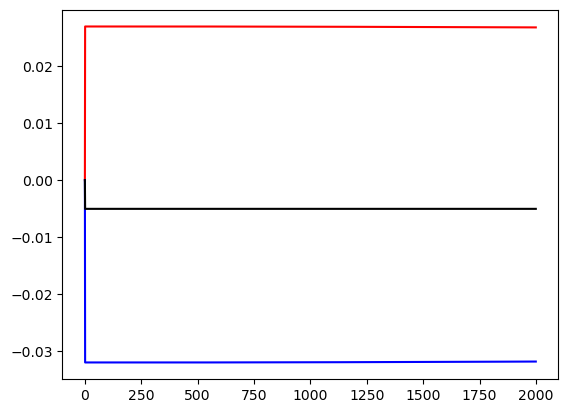

In [124]:
plt.plot(res_1[2,2,:N], 'r')
plt.plot(res_2[2,2,:N], 'b')
plt.plot(res_1[2,2,:N] + res_2[2,2,:N], 'k')
plt.show()

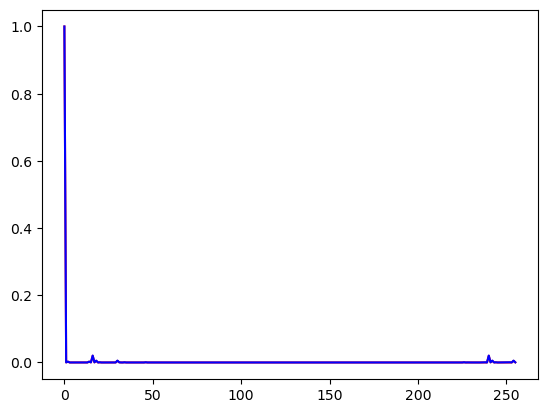

In [125]:
plt.plot(sigma_1, 'r')
plt.plot(sigma_2, 'b')
plt.show()

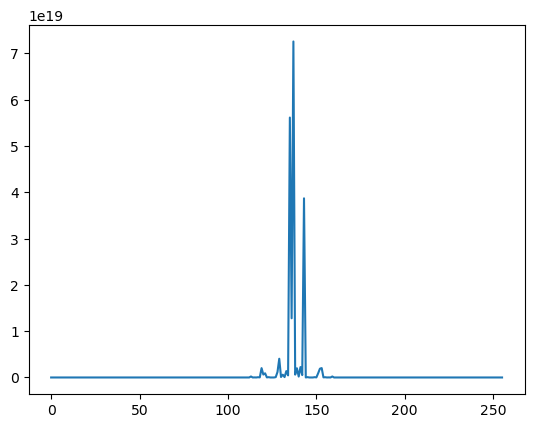

In [126]:
InvBoB = 1 / sigma_1**2
plt.plot(InvBoB)
plt.show()

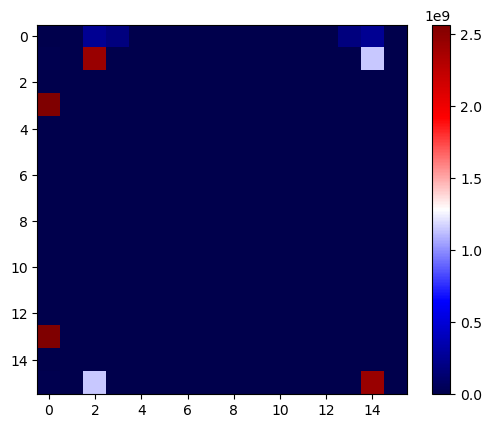

In [127]:
zero_out_indices = lambda i, j: 0 if ((i-8)**2 + (j-8)**2) < 81 else InvBoB.reshape((K,K), order='F')[i, j]
truncated_InvBoB = np.array([[zero_out_indices(i, j) for j in range(K)] for i in range(K)])
plt.imshow(truncated_InvBoB, cmap='seismic')
plt.colorbar()

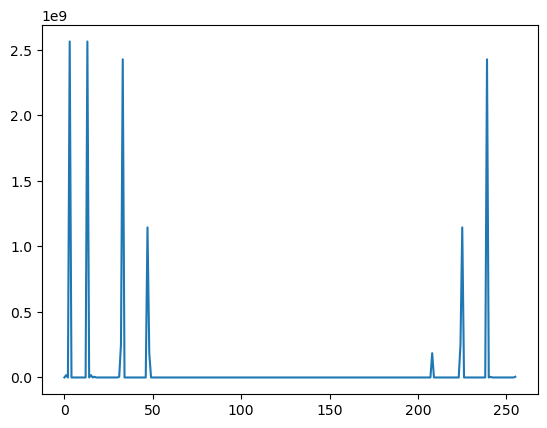

In [128]:
plt.plot(truncated_InvBoB.flatten(order='F'))
plt.show()

In [136]:
# Lagrangian DA
def get_coef_mat(KX, KY, K_squared, kd, beta, kappa, U, psi1_hat, psi2_hat, h_hat):
    # psi1_hat, hk should be of shape (N, K, K), if not, reshape them to make it legible
    if psi1_hat.shape[-2:] != KX.shape:
        psi1_hat = np.transpose(psi1_hat, axes=(2,0,1))
    if h_hat.shape[-2:] != KX.shape:
        h_hat = np.transpose(h_hat, axes=(2,0,1))
        
    psi2_hat = np.transpose(psi2_hat, axes=(2,0,1))

    # define Ck for each wave number
    Ck = 1 / (K_squared * (K_squared + kd**2))
    Ck[K_squared == 0] = 0  # avoid division by zero at k = 0

    # linear part for A0, a0, A1 and a1
    linear_A0 = 1j * KX * (((K_squared + kd**2/2)*beta - K_squared**2 * U)*psi1_hat - kd**2/2 * U * h_hat)
    linear_a0 = 1j * KX * ((kd**2/2 * beta - kd**2 * K_squared * U)*psi1_hat - (K_squared + kd**2/2) * U * h_hat)
    linear_A1_diag = 1j * KX * (kd**2/2 * beta + kd**2 * K_squared * U) - (kd**2/2 * kappa * K_squared)
    linear_a1_diag = 1j * KX * ((K_squared + kd**2/2)*beta + K_squared**2 * U) - (K_squared + kd**2/2)* kappa * K_squared
    linear_A1 = np.tile(np.diag(linear_A1_diag.flatten(order='F'))[None,:,:], (psi1_hat.shape[0],1,1)) 
    linear_a1 = np.tile(np.diag(linear_a1_diag.flatten(order='F'))[None,:,:], (psi1_hat.shape[0],1,1)) 
    
    # nonlinear summation part for A0, a0, A1 and a1
    nonlinear_sum_A0 = np.zeros_like(psi1_hat, dtype=complex)
    nonlinear_sum_a0 = np.zeros_like(psi1_hat, dtype=complex)
    nonlinear_sum_A1 = np.zeros_like(linear_A1, dtype=complex)
    nonlinear_sum_a1 = np.zeros_like(linear_a1, dtype=complex)
    k_index_map = {(KX[iy, ix], KY[iy, ix]): (ix, iy) for ix in range(K) for iy in range(K)}
    
    # check 
    det_sum = np.zeros(KX.shape)
    Jacobi_2_diff = np.zeros_like(psi1_hat, dtype=complex)
    
    for mx in range(K):
        for my in range(K):
            m = [KX[my, mx], KY[my, mx]]
            psi1_m = psi1_hat[:, my, mx]
            psi2_m = psi2_hat[:, my, mx]

            for nx in range(K):
                for ny in range(K):
                    n = [KX[ny, nx], KY[ny, nx]]
                    psi1_n = psi1_hat[:, ny, nx]
                    psi2_n = psi2_hat[:, ny, nx]
                    h_n = h_hat[ny, nx]
                    
                    # Check if k is within the wave number sets
                    k = (m[0] + n[0], m[1] + n[1])
                    
                    if k in k_index_map:
                        ix, iy = k_index_map[k]
                        ik_flatten = ix * K + iy
                        im_flatten = mx * K + my
                        k_mod = K_squared[iy, ix]
                        det_mn = np.linalg.det(np.array([m, n]))
                        nonlinear_sum_A0[:, iy, ix] -= det_mn * ((k_mod + kd**2 / 2)**2 * psi1_n * psi1_m)
                        nonlinear_sum_a0[:, iy, ix] -= det_mn * (kd**2 / 2 * (k_mod + kd**2 / 2) * psi1_n * psi1_m)
                        nonlinear_sum_A1[:, ik_flatten, im_flatten] += det_mn * kd**2 / 2 * (k_mod * psi1_n - h_n)
                        nonlinear_sum_a1[:, ik_flatten, im_flatten] -= det_mn * (k_mod * kd**2 / 2 * psi1_n - (k_mod + kd**2 / 2) * h_n)    
    
                        det_sum[iy,ix] += det_mn
                        Jacobi_2_diff[:,iy,ix] -= det_mn *  ((k_mod + kd**2 / 2)**2 * psi2_n * psi2_m)
    # aggregate 
    A0 = linear_A0 + nonlinear_sum_A0
    a0 = linear_a0 + nonlinear_sum_a0
    A1 = linear_A1 + nonlinear_sum_A1
    a1 = linear_a1 + nonlinear_sum_a1
    
    # normalization 
    A0 = Ck * A0
    a0 = Ck * a0
    A1 = np.tile(Ck.flatten(order='F')[:,None], (1,K**2)) * A1
    a1 = np.tile(Ck.flatten(order='F')[:,None], (1,K**2)) * a1
    
    # flatten
    A0 = A0.reshape((A0.shape[0], -1), order='F')
    a0 = a0.reshape((a0.shape[0], -1), order='F')
    
    return A0, a0, A1, a1, np.tile(Ck.flatten(order='F')[:,None], (1,K**2)) * nonlinear_sum_A1, det_sum, Jacobi_2_diff

N = 2000
kx = np.fft.fftfreq(K) * K
ky = np.fft.fftfreq(K) * K
KX, KY = np.meshgrid(kx, ky)
K_squared = KX**2 + KY**2

# prepare coefficient matrices used in DA
A0_t, a0_t, A1_t, a1_t, nonlinear_A1, det_sum, Jacobi_2_diff = get_coef_mat(KX, KY, K_squared, kd, beta, kappa, U, psi1_k_t[:,:,:N], psi2_k_t[:,:,:N], h_hat)
# InvBoB = 1 / sigma_1**2
InvBoB = truncated_InvBoB.flatten(order='F')
# InvBoB = 1 / 4.**2

# initialized mean and variance
mu0 = psi2_k_t[:,:,0].flatten(order='F') # assume the initial condition is truth
n = mu0.shape[0]
R0 = np.zeros((n, n), dtype='complex')
mu_t = np.zeros((n, N), dtype='complex')  # posterior mean
mu_t[:, 0] = mu0
R_t = np.zeros((n, N), dtype='complex')  # posterior covariance
R_t[:, 0] = np.diag(R0)  # only save the diagonal elements

# Lagrangian DA
for i in range(1, N):
    A0 = A0_t[i-1, :]
    a0 = a0_t[i-1, :]
    A1 = A1_t[i-1, :, :]
    a1 = a1_t[i-1, :, :]
    psi1_diff = psi1_k_t[:, :, i] - psi1_k_t[:, :, i - 1]
    psi1_diff = psi1_diff.flatten(order='F')

    # Update the posterior mean and posterior covariance
#     check1 = (A1.conj().T) @ (- (A1 @ mu0) * dt)
#     check2 = (R0 @ A1.conj().T) @ (- (A1 @ mu0) * dt)
#     print(check1[4], check2[4])
    mu = mu0 + (a0 + a1 @ mu0) * dt + (R0 @ A1.conj().T) * InvBoB @ (psi1_diff - (A0 + A1 @ mu0) * dt)
    R = R0 + (a1 @ R0 + R0 @ a1.conj().T + np.diag(sigma_2**2) - (R0 @ A1.conj().T) * InvBoB @ A1 @ R0.conj().T) * dt
    mu_t[:, i] = mu
    R_t[:, i] = np.diag(R)
    mu0 = mu
    R0 = R


/var/folders/lz/50081q0n24g8lq6ncqpbp8780000gn/T/ipykernel_3702/2979352473.py:12: RuntimeWarning: divide by zero encountered in divide
  Ck = 1 / (K_squared * (K_squared + kd**2))


In [137]:
# reshape flattened variables to two modes matrices
K_cut = int(np.sqrt(n))
mu_t = mu_t.reshape((K_cut,K_cut,-1), order='F')
mu_t.shape

(16, 16, 2000)

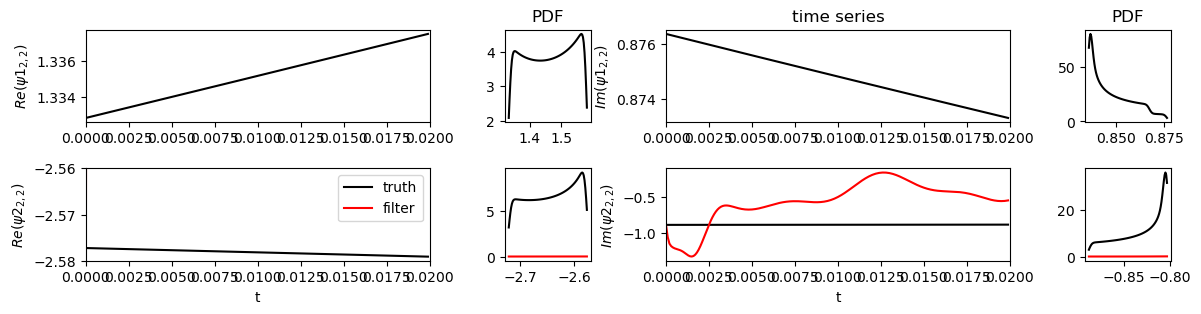

In [151]:
# Plot
sel0 = 0; sel1 = N # plot time range
ikx = 2; iky = 2 # mode to plot
interv = 10 # plot interval
xaxis = np.arange(sel0*dt, sel1*dt, interv*dt)

fig = plt.figure(figsize=(14,3))
widths = [6, 1.5, 6, 1.5]
heights = [2, 2]
spec = fig.add_gridspec(ncols=4, nrows=2, width_ratios=widths, height_ratios=heights)

plt.subplots_adjust(wspace=0.35, hspace=0.5)     # Adjust the overall spacing of the figure
ax1 = fig.add_subplot(spec[0, 0])
ax2 = fig.add_subplot(spec[1, 0])
ax3 = fig.add_subplot(spec[0, 1])
ax4 = fig.add_subplot(spec[1, 1])
ax11 = fig.add_subplot(spec[0, 2])
ax22 = fig.add_subplot(spec[1, 2])
ax33 = fig.add_subplot(spec[0, 3])
ax44 = fig.add_subplot(spec[1, 3])

# plot time series
ax1.plot(xaxis, psi1_k_t[iky,ikx,sel0:sel1:interv].real, 'k')
ax1.set_xlim(sel0*dt, sel1*dt)
ax1.set_ylabel('$Re(\psi1_{{{:d},{:d}}})$'.format(ikx, iky))

ax2.plot(xaxis, psi2_k_t[iky,ikx,sel0:sel1:interv].real, 'k', label='truth')
ax2.plot(xaxis, mu_t[iky,ikx,sel0:sel1:interv].real, 'r', label='filter')
ax2.set_xlim(sel0*dt, sel1*dt)
ax2.set_ylabel(r'$Re(\psi2_{{{:d},{:d}}})$'.format(ikx, iky))
ax2.set_xlabel('t')
ax2.legend()
# ax2.set_xlim(0,0.01)
# ax2.set_ylim(-2.58,-2.56)

# plot pdf
samples = psi1_k_t[iky, ikx, :].real
kde = gaussian_kde(samples)
xticks = np.linspace(samples.min(), samples.max(), 100)
p = kde.evaluate(xticks)
ax3.plot(xticks, p, 'k')
ax3.set_title('PDF')

samples = psi2_k_t[iky, ikx, :].real
kde = gaussian_kde(samples)
xticks = np.linspace(samples.min(), samples.max(), 100)
p = kde.evaluate(xticks)
ax4.plot(xticks, p, 'k', label='truth')
samples = mu_t[iky, ikx, :].real
kde = gaussian_kde(samples)
p = kde.evaluate(xticks)
ax4.plot(xticks, p, 'r', label='filter')

ax11.plot(xaxis, psi1_k_t[iky,ikx,sel0:sel1:interv].imag, 'k')
ax11.set_xlim(sel0*dt, sel1*dt)
ax11.set_ylabel('$Im(\psi1_{{{:d},{:d}}})$'.format(ikx, iky))
ax11.set_title('time series')

ax22.plot(xaxis, psi2_k_t[iky,ikx,sel0:sel1:interv].imag, 'k', label='truth')
ax22.plot(xaxis, mu_t[iky,ikx,sel0:sel1:interv].imag, 'r', label='filter')
ax22.set_xlim(sel0*dt, sel1*dt)
ax22.set_ylabel(r'$Im(\psi2_{{{:d},{:d}}})$'.format(ikx, iky))
ax22.set_xlabel('t')

# plot pdf
samples = psi1_k_t[iky, ikx, :].imag
kde = gaussian_kde(samples)
xticks = np.linspace(samples.min(), samples.max(), 100)
p = kde.evaluate(xticks)
ax33.plot(xticks, p, 'k')
ax33.set_title('PDF')

samples = psi2_k_t[iky, ikx, :].imag
kde = gaussian_kde(samples)
xticks = np.linspace(samples.min(), samples.max(), 100)
p = kde.evaluate(xticks)
ax44.plot(xticks, p, 'k', label='truth')
samples = mu_t[iky, ikx, :].imag
kde = gaussian_kde(samples)
p = kde.evaluate(xticks)
ax44.plot(xticks, p, 'r', label='filter')
# plt.savefig('./Lagrangian_DA/LagDA_K16_L64.png',dpi=100)
plt.show()

In [144]:
# plot R
R_psi_k_pos, R_tau_k_pos = mu2psi(R_t, K, cut)
plt.figure(figsize=(5,4))
plt.plot(R_psi_k_pos[ikx,ikx,:])
plt.xlabel('t')
plt.ylabel(r'$variance_{{{:d},{:d}}}$'.format(ikx, iky))
# plt.savefig('./Lagrangian_DA/var_L64.png')
plt.show()

NameError: name 'cut' is not defined

## 2.2 check DA code using perfect model (QG truncated)

In [2]:
# load data
data_path = '/Users/ree/Documents/Research/Proj_1_LangrangeDA/code/qg_2layer_topo/QG_DATA_topo10_nu4e-6_beta60_K16_dt1e-5_tr.mat'
with h5py.File(data_path, 'r') as file:
    print("Keys: %s" % file.keys())
    psi1_k_t = np.transpose(file['psi_1_t'][()], axes=(2, 1, 0)) # reorder the dimensions from Python's row-major order back to MATLAB's column-major order 
    psi2_k_t = np.transpose(file['psi_2_t'][()], axes=(2, 1, 0)) # reorder the dimensions from Python's row-major order back to MATLAB's column-major order 
    dt = file['dt'][()][0,0]
#     s_rate = file['s_rate'][()][0,0]
    params_dataset = file['params']
    nu = params_dataset['nu'][()] [0,0]
    topo = params_dataset['H'][()] [0,0]
    kd = params_dataset['kd'][()] [0,0]
    U = params_dataset['U'][()] [0,0]
    kb = params_dataset['kb'][()] [0,0]
    kappa = params_dataset['r'][()] [0,0]
    beta = kb**2
    K = int(params_dataset['N'][()] [0,0])
    H = params_dataset['H'][()] [0,0]
    topo = np.transpose(file['topo'][()], axes=(1,0))
# dt = dt * s_rate
print('psi1_k_t.shape',psi1_k_t.shape)
psi1_k_t = psi1_k_t['real'] + 1j * psi1_k_t['imag']
psi2_k_t = psi2_k_t['real'] + 1j * psi2_k_t['imag']

Keys: <KeysViewHDF5 ['#refs#', 'T', 'ape', 'countDiag', 'cut', 'dt', 'ene', 'etp', 'ii', 'ke', 'params', 'psi_1_t', 'psi_2_t', 'qp', 's_rate', 'tol', 'topo', 'u1_t', 'utz', 'v1_t', 'vb']>
psi1_k_t.shape (16, 16, 100000)


In [3]:
# beta = 60
h_hat = np.fft.fft2(topo)

### 2.2.1 estimate Sigma based on residual

In [9]:
# estimate Sigma based on residual
def get_coef_mat(KX, KY, K_squared, kd, beta, kappa, U, psi1_hat, psi2_hat, h_hat):
    K = KX.shape[0]
    
    # psi_hat, hk should be of shape (N, K, K), if not, reshape them to make it legible
    if psi1_hat.shape[-2:] != KX.shape:
        psi1_hat = np.transpose(psi1_hat, axes=(2,0,1))
    if psi2_hat.shape[-2:] != KX.shape:
        psi2_hat = np.transpose(psi2_hat, axes=(2,0,1))
    if h_hat.shape[-2:] != KX.shape:
        h_hat = np.transpose(h_hat, axes=(2,0,1))

    # make sure \partial psi1_k / \partial x be conjugate symmetric
    psi1_hat[:, :, K//2] = 0
    psi1_hat[:, K//2, :] = 0
    psi2_hat[:, :, K//2] = 0
    psi2_hat[:, K//2, :] = 0

    # define Ck for each wave number
    Ck = 1 / (K_squared * (K_squared + kd**2))
    Ck[K_squared == 0] = 0  # avoid division by zero at k = 0, constant mode

    # linear part for A0, a0, A1 and a1
    linear_A0 = 1j * KX * (((K_squared + kd**2/2)*beta - K_squared**2 * U)*psi1_hat - kd**2/2 * U * h_hat) - nu * K_squared**4 * ((K_squared + kd**2)*K_squared*psi1_hat - kd**2/2*h_hat)
    linear_a0 = 1j * KX * ((kd**2/2 * beta - kd**2 * K_squared * U)*psi1_hat - (K_squared + kd**2/2) * U * h_hat) + nu * K_squared**4 * (K_squared + kd**2/2) * h_hat
    linear_A1_diag = 1j * KX * (kd**2/2 * beta + kd**2 * K_squared * U) - (kd**2/2 * kappa * K_squared)
    linear_a1_diag = 1j * KX * ((K_squared + kd**2/2)*beta + K_squared**2 * U) - (K_squared + kd**2/2) * kappa * K_squared - nu * K_squared**4 * (K_squared + kd**2) * K_squared
    linear_A1 = np.tile(np.diag(linear_A1_diag.flatten(order='F'))[None,:,:], (psi1_hat.shape[0],1,1)) 
    linear_a1 = np.tile(np.diag(linear_a1_diag.flatten(order='F'))[None,:,:], (psi1_hat.shape[0],1,1)) 
    
    # nonlinear summation part for A0, a0, A1 and a1
    nonlinear_sum_A0 = np.zeros_like(psi1_hat, dtype=complex)
    nonlinear_sum_a0 = np.zeros_like(psi1_hat, dtype=complex)
    nonlinear_sum_A1 = np.zeros_like(linear_A1, dtype=complex)
    nonlinear_sum_a1 = np.zeros_like(linear_a1, dtype=complex)
    k_index_map = {(KX[iy, ix], KY[iy, ix]): (ix, iy) for ix in range(K) for iy in range(K)}
    
    # check 
    det_sum = np.zeros(KX.shape)
    Jacobi_2_diff = np.zeros_like(psi1_hat, dtype=complex)
    
    for imx in range(K):
        for imy in range(K):
            m = [KX[imy, imx], KY[imy, imx]]
            psi1_m = psi1_hat[:, imy, imx]
            psi2_m = psi2_hat[:, imy, imx]

            for inx in range(K):
                for iny in range(K):
                    n = [KX[iny, inx], KY[iny, inx]]
                    psi1_n = psi1_hat[:, iny, inx]
                    psi2_n = psi2_hat[:, iny, inx]
                    h_n = h_hat[iny, inx]
                    
                    # Check if k is within the wave number sets
                    k = (m[0] + n[0], m[1] + n[1])
                    
                    if k in k_index_map:
                        ikx, iky = k_index_map[k]
                        ik_flatten = ikx * K + iky
                        im_flatten = imx * K + imy
                        k_mod = K_squared[iky, ikx]
                        det_mn = np.linalg.det(np.array([m, n]))
#                         nonlinear_sum_A0[:, iky, ikx] -= det_mn * ((k_mod + kd**2 / 2)**2 * psi1_n * psi1_m)
#                         nonlinear_sum_a0[:, iky, ikx] -= det_mn * (kd**2 / 2 * (k_mod + kd**2 / 2) * psi1_n * psi1_m)
                        nonlinear_sum_A1[:, ik_flatten, im_flatten] += det_mn * kd**2 / 2 * (k_mod * psi1_n - h_n)
                        nonlinear_sum_a1[:, ik_flatten, im_flatten] -= det_mn * (k_mod * kd**2 / 2 * psi1_n - (k_mod + kd**2 / 2) * h_n) 
                        
    # aggregate 
    A0 = linear_A0 + nonlinear_sum_A0
    a0 = linear_a0 + nonlinear_sum_a0
    A1 = linear_A1 + nonlinear_sum_A1
    a1 = linear_a1 + nonlinear_sum_a1
    
    # enforce conjugate symmetry
    A1[:, 8::K, :] = 0
    A1[:, 8*K:9*K, :] = 0
    a1[:, 8::K, :] = 0
    a1[:, 8*K:9*K, :] = 0
    
    # normalization 
    Ck_ = np.tile(Ck.flatten(order='F')[None,:,None], (psi1_hat.shape[0],1,K**2))
    A0 = Ck * A0
    a0 = Ck * a0
    A1 = Ck_ * A1
    a1 = Ck_ * a1
    
    # flatten
    A0 = A0.reshape((A0.shape[0], -1), order='F')
    a0 = a0.reshape((a0.shape[0], -1), order='F')
    
    return A0, a0, A1, a1

interv = 50 
kx = np.fft.fftfreq(K) * K
ky = np.fft.fftfreq(K) * K
KX, KY = np.meshgrid(kx, ky)
K_squared = KX**2 + KY**2
A0_t, a0_t, A1_t, a1_t = get_coef_mat(KX, KY, K_squared, kd, beta, kappa, U, psi1_k_t[:,:,::interv], psi2_k_t[:,:,::interv], h_hat)
N = A0_t.shape[0]

# calculate residual for each time step
res_1 = np.zeros_like(psi1_k_t[:,:,::interv], dtype='complex')
res_2 = np.zeros_like(psi2_k_t[:,:,::interv], dtype='complex')

for i in range(1,N):
    A0 = A0_t[i-1, :]
    a0 = a0_t[i-1, :]
    A1 = A1_t[i-1, :, :]
    a1 = a1_t[i-1, :, :]
    psi1_k_t_flat0 = psi1_k_t[:,:,i-1].flatten(order='F')
    psi2_k_t_flat0 = psi2_k_t[:,:,i-1].flatten(order='F')
    psi1_k_t_flat1 = psi1_k_t[:,:,i].flatten(order='F')
    psi2_k_t_flat1 = psi2_k_t[:,:,i].flatten(order='F')
    res_1[:,:,i] = ((psi1_k_t_flat1 - psi1_k_t_flat0) - ((A0 + A1 @ psi2_k_t_flat0) * dt)).reshape((K,K), order='F')
    res_2[:,:,i] = ((psi2_k_t_flat1 - psi2_k_t_flat0) - ((a0 + a1 @ psi2_k_t_flat0) * dt)).reshape((K,K), order='F')
    
sigma_1 = np.std(res_1[:,:,:N], axis=2).flatten(order='F') / np.sqrt(2)
sigma_2 = np.std(res_2[:,:,:N], axis=2).flatten(order='F') / np.sqrt(2)
sigma_1[0] = 1
sigma_2[0] = 1

/var/folders/lz/50081q0n24g8lq6ncqpbp8780000gn/T/ipykernel_2506/1869608965.py:20: RuntimeWarning: divide by zero encountered in divide
  Ck = 1 / (K_squared * (K_squared + kd**2))


/Users/ree/miniconda3/envs/py/lib/python3.11/site-packages/matplotlib/cbook/__init__.py:1340: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


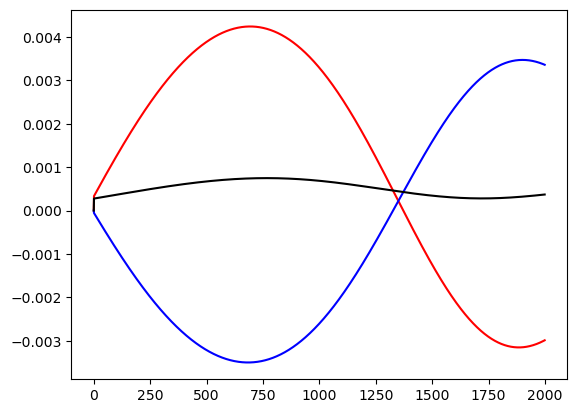

In [10]:
plt.plot(res_1[2,2,:N], 'r')
plt.plot(res_2[2,2,:N], 'b')
plt.plot(res_1[2,2,:N] + res_2[2,2,:N], 'k')
plt.show()

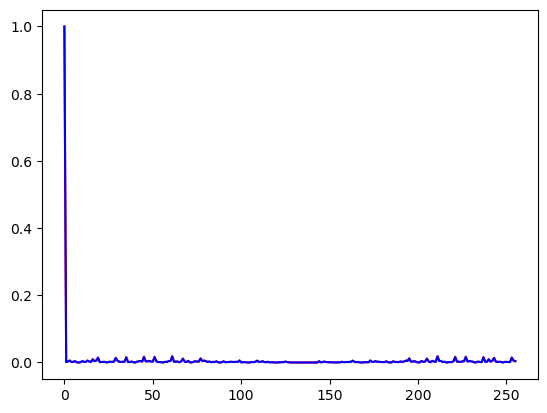

In [11]:
plt.plot(sigma_1, 'r')
plt.plot(sigma_2, 'b')
plt.show()

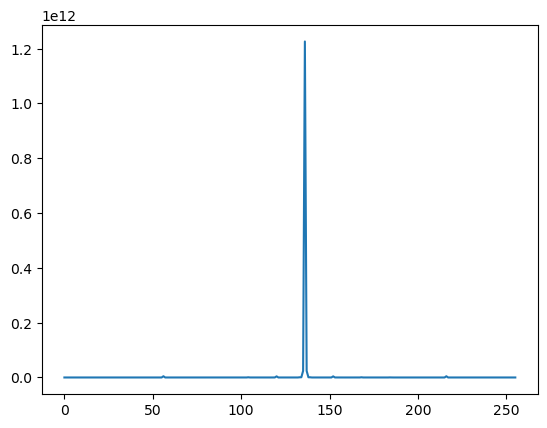

In [12]:
InvBoB = 1 / sigma_1**2
plt.plot(InvBoB)
plt.show()

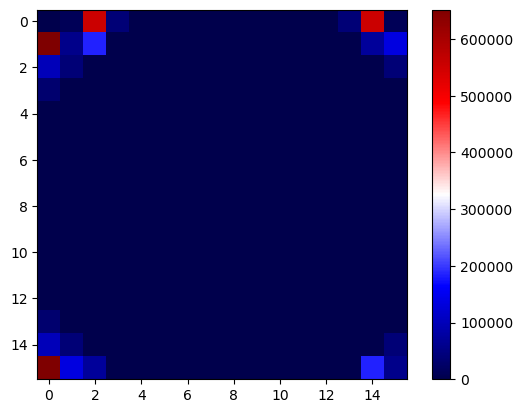

In [13]:
zero_out_indices = lambda i, j: 0 if ((i-8)**2 + (j-8)**2) < 81 else InvBoB.reshape((K,K), order='F')[i, j]
truncated_InvBoB = np.array([[zero_out_indices(i, j) for j in range(K)] for i in range(K)])
plt.imshow(truncated_InvBoB, cmap='seismic')
plt.colorbar()

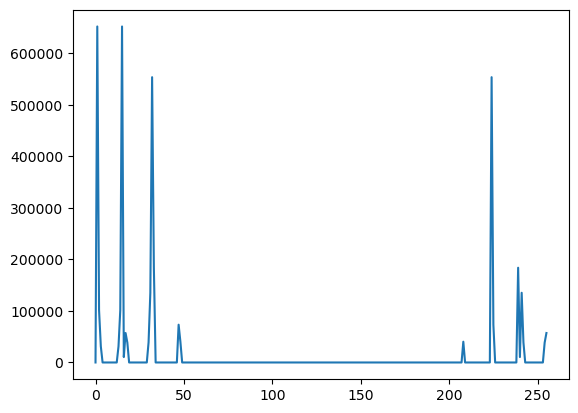

In [14]:
plt.plot(truncated_InvBoB.flatten(order='F'))
plt.show()

In [15]:
# Lagrangian DA
def get_coef_mat(KX, KY, K_squared, kd, beta, kappa, U, psi1_hat, psi2_hat, h_hat):
    K = KX.shape[0]
    
    # psi_hat, hk should be of shape (N, K, K), if not, reshape them to make it legible
    if psi1_hat.shape[-2:] != KX.shape:
        psi1_hat = np.transpose(psi1_hat, axes=(2,0,1))
    if psi2_hat.shape[-2:] != KX.shape:
        psi2_hat = np.transpose(psi2_hat, axes=(2,0,1))
    if h_hat.shape[-2:] != KX.shape:
        h_hat = np.transpose(h_hat, axes=(2,0,1))

    # make sure \partial psi1_k / \partial x be conjugate symmetric
    psi1_hat[:, :, K//2] = 0
    psi1_hat[:, K//2, :] = 0
    psi2_hat[:, :, K//2] = 0
    psi2_hat[:, K//2, :] = 0

    # define Ck for each wave number
    Ck = 1 / (K_squared * (K_squared + kd**2))
    Ck[K_squared == 0] = 0  # avoid division by zero at k = 0, constant mode

    # linear part for A0, a0, A1 and a1
    linear_A0 = 1j * KX * (((K_squared + kd**2/2)*beta - K_squared**2 * U)*psi1_hat - kd**2/2 * U * h_hat) - nu * K_squared**4 * ((K_squared + kd**2)*K_squared*psi1_hat - kd**2/2*h_hat)
    linear_a0 = 1j * KX * ((kd**2/2 * beta - kd**2 * K_squared * U)*psi1_hat - (K_squared + kd**2/2) * U * h_hat) + nu * K_squared**4 * (K_squared + kd**2/2) * h_hat
    linear_A1_diag = 1j * KX * (kd**2/2 * beta + kd**2 * K_squared * U) - (kd**2/2 * kappa * K_squared)
    linear_a1_diag = 1j * KX * ((K_squared + kd**2/2)*beta + K_squared**2 * U) - (K_squared + kd**2/2) * kappa * K_squared - nu * K_squared**4 * (K_squared + kd**2) * K_squared
    linear_A1 = np.tile(np.diag(linear_A1_diag.flatten(order='F'))[None,:,:], (psi1_hat.shape[0],1,1)) 
    linear_a1 = np.tile(np.diag(linear_a1_diag.flatten(order='F'))[None,:,:], (psi1_hat.shape[0],1,1)) 
    
    # nonlinear summation part for A0, a0, A1 and a1
    nonlinear_sum_A0 = np.zeros_like(psi1_hat, dtype=complex)
    nonlinear_sum_a0 = np.zeros_like(psi1_hat, dtype=complex)
    nonlinear_sum_A1 = np.zeros_like(linear_A1, dtype=complex)
    nonlinear_sum_a1 = np.zeros_like(linear_a1, dtype=complex)
    k_index_map = {(KX[iy, ix], KY[iy, ix]): (ix, iy) for ix in range(K) for iy in range(K)}
    
    # check 
    det_sum = np.zeros(KX.shape)
    Jacobi_2_diff = np.zeros_like(psi1_hat, dtype=complex)
    
    for imx in range(K):
        for imy in range(K):
            m = [KX[imy, imx], KY[imy, imx]]
            psi1_m = psi1_hat[:, imy, imx]
            psi2_m = psi2_hat[:, imy, imx]

            for inx in range(K):
                for iny in range(K):
                    n = [KX[iny, inx], KY[iny, inx]]
                    psi1_n = psi1_hat[:, iny, inx]
                    psi2_n = psi2_hat[:, iny, inx]
                    h_n = h_hat[iny, inx]
                    
                    # Check if k is within the wave number sets
                    k = (m[0] + n[0], m[1] + n[1])
                    
                    if k in k_index_map:
                        ikx, iky = k_index_map[k]
                        ik_flatten = ikx * K + iky
                        im_flatten = imx * K + imy
                        k_mod = K_squared[iky, ikx]
                        det_mn = np.linalg.det(np.array([m, n]))
#                         nonlinear_sum_A0[:, iky, ikx] -= det_mn * ((k_mod + kd**2 / 2)**2 * psi1_n * psi1_m)
#                         nonlinear_sum_a0[:, iky, ikx] -= det_mn * (kd**2 / 2 * (k_mod + kd**2 / 2) * psi1_n * psi1_m)
                        nonlinear_sum_A1[:, ik_flatten, im_flatten] += det_mn * kd**2 / 2 * (k_mod * psi1_n - h_n)
                        nonlinear_sum_a1[:, ik_flatten, im_flatten] -= det_mn * (k_mod * kd**2 / 2 * psi1_n - (k_mod + kd**2 / 2) * h_n) 
                        
    # aggregate 
    A0 = linear_A0 + nonlinear_sum_A0
    a0 = linear_a0 + nonlinear_sum_a0
    A1 = linear_A1 + nonlinear_sum_A1
    a1 = linear_a1 + nonlinear_sum_a1
    
    # enforce conjugate symmetry
    A1[:, 8::K, :] = 0
    A1[:, 8*K:9*K, :] = 0
    a1[:, 8::K, :] = 0
    a1[:, 8*K:9*K, :] = 0
    
    # normalization 
    Ck_ = np.tile(Ck.flatten(order='F')[None,:,None], (psi1_hat.shape[0],1,K**2))
    A0 = Ck * A0
    a0 = Ck * a0
    A1 = Ck_ * A1
    a1 = Ck_ * a1
    
    # flatten
    A0 = A0.reshape((A0.shape[0], -1), order='F')
    a0 = a0.reshape((a0.shape[0], -1), order='F')
    
    return A0, a0, A1, a1

N = 2000
kx = np.fft.fftfreq(K) * K
ky = np.fft.fftfreq(K) * K
KX, KY = np.meshgrid(kx, ky)
K_squared = KX**2 + KY**2

# prepare coefficient matrices used in DA
A0_t, a0_t, A1_t, a1_t= get_coef_mat(KX, KY, K_squared, kd, beta, kappa, U, psi1_k_t[:,:,:N], psi2_k_t[:,:,:N], h_hat)
# InvBoB = 1 / sigma_1**2
InvBoB = truncated_InvBoB.flatten(order='F')
# InvBoB = 1 / 4.**2

# initialized mean and variance
mu0 = psi2_k_t[:,:,0].flatten(order='F') # assume the initial condition is truth
K_ = mu0.shape[0] # flattened K*K
R0 = np.zeros((K_, K_), dtype='complex')
mu_t = np.zeros((K_, N), dtype='complex')  # posterior mean
mu_t[:, 0] = mu0
R_t = np.zeros((K_, N), dtype='complex')  # posterior covariance
R_t[:, 0] = np.diag(R0)  # only save the diagonal elements

# Lagrangian DA
for i in range(1, N):
    A0 = A0_t[i-1, :]
    a0 = a0_t[i-1, :]
    A1 = A1_t[i-1, :, :]
    a1 = a1_t[i-1, :, :]
    psi1_diff = psi1_k_t[:, :, i] - psi1_k_t[:, :, i - 1]
    psi1_diff = psi1_diff.flatten(order='F')

    # Update the posterior mean and posterior covariance
    mu = mu0 + (a0 + a1 @ mu0) * dt + (R0 @ A1.conj().T) * InvBoB @ (psi1_diff - (A0 + A1 @ mu0) * dt)
    R = R0 + (a1 @ R0 + R0 @ a1.conj().T + np.diag(sigma_2**2) - (R0 @ A1.conj().T) * InvBoB @ A1 @ R0.conj().T) * dt
    mu_t[:, i] = mu
    R_t[:, i] = np.diag(R)
    mu0 = mu
    R0 = R


/var/folders/lz/50081q0n24g8lq6ncqpbp8780000gn/T/ipykernel_81136/121282605.py:20: RuntimeWarning: divide by zero encountered in divide
  Ck = 1 / (K_squared * (K_squared + kd**2))


In [16]:
K_ = mu0.shape[0] # flattened K*K


In [17]:
# reshape flattened variables to two modes matrices
K_cut = int(np.sqrt(K_))
mu_t = mu_t.reshape((K_cut,K_cut,-1), order='F')
mu_t.shape

(16, 16, 2000)

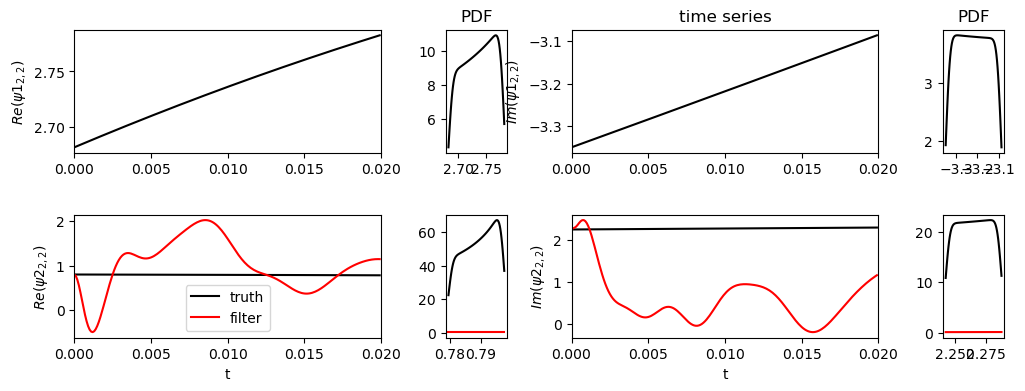

In [18]:
# Plot
sel0 = 0; sel1 = N # plot time range
ikx = 2; iky = 2 # mode to plot
interv = 10 # plot interval
xaxis = np.arange(sel0*dt, sel1*dt, interv*dt)

fig = plt.figure(figsize=(12,4))
widths = [5, 1, 5, 1]
heights = [1, 1]
spec = fig.add_gridspec(ncols=4, nrows=2, width_ratios=widths, height_ratios=heights)

plt.subplots_adjust(wspace=0.35, hspace=0.5)     # Adjust the overall spacing of the figure
ax1 = fig.add_subplot(spec[0, 0])
ax2 = fig.add_subplot(spec[1, 0])
ax3 = fig.add_subplot(spec[0, 1])
ax4 = fig.add_subplot(spec[1, 1])
ax11 = fig.add_subplot(spec[0, 2])
ax22 = fig.add_subplot(spec[1, 2])
ax33 = fig.add_subplot(spec[0, 3])
ax44 = fig.add_subplot(spec[1, 3])

# plot time series
ax1.plot(xaxis, psi1_k_t[iky,ikx,sel0:sel1:interv].real, 'k')
ax1.set_xlim(sel0*dt, sel1*dt)
ax1.set_ylabel('$Re(\psi1_{{{:d},{:d}}})$'.format(ikx, iky))

ax2.plot(xaxis, psi2_k_t[iky,ikx,sel0:sel1:interv].real, 'k', label='truth')
ax2.plot(xaxis, mu_t[iky,ikx,sel0:sel1:interv].real, 'r', label='filter')
ax2.set_xlim(sel0*dt, sel1*dt)
ax2.set_ylabel(r'$Re(\psi2_{{{:d},{:d}}})$'.format(ikx, iky))
ax2.set_xlabel('t')
ax2.legend()
# ax2.set_xlim(0,0.01)
# ax2.set_ylim(-2.58,-2.56)

# plot pdf
samples = psi1_k_t[iky, ikx, :N].real
kde = gaussian_kde(samples)
xticks = np.linspace(samples.min(), samples.max(), 100)
p = kde.evaluate(xticks)
ax3.plot(xticks, p, 'k')
ax3.set_title('PDF')

samples = psi2_k_t[iky, ikx, :N].real
kde = gaussian_kde(samples)
xticks = np.linspace(samples.min(), samples.max(), 100)
p = kde.evaluate(xticks)
ax4.plot(xticks, p, 'k', label='truth')
samples = mu_t[iky, ikx, :].real
kde = gaussian_kde(samples)
p = kde.evaluate(xticks)
ax4.plot(xticks, p, 'r', label='filter')

ax11.plot(xaxis, psi1_k_t[iky,ikx,sel0:sel1:interv].imag, 'k')
ax11.set_xlim(sel0*dt, sel1*dt)
ax11.set_ylabel('$Im(\psi1_{{{:d},{:d}}})$'.format(ikx, iky))
ax11.set_title('time series')

ax22.plot(xaxis, psi2_k_t[iky,ikx,sel0:sel1:interv].imag, 'k', label='truth')
ax22.plot(xaxis, mu_t[iky,ikx,sel0:sel1:interv].imag, 'r', label='filter')
ax22.set_xlim(sel0*dt, sel1*dt)
ax22.set_ylabel(r'$Im(\psi2_{{{:d},{:d}}})$'.format(ikx, iky))
ax22.set_xlabel('t')

# plot pdf
samples = psi1_k_t[iky, ikx, :N].imag
kde = gaussian_kde(samples)
xticks = np.linspace(samples.min(), samples.max(), 100)
p = kde.evaluate(xticks)
ax33.plot(xticks, p, 'k')
ax33.set_title('PDF')

samples = psi2_k_t[iky, ikx, :N].imag
kde = gaussian_kde(samples)
xticks = np.linspace(samples.min(), samples.max(), 100)
p = kde.evaluate(xticks)
ax44.plot(xticks, p, 'k', label='truth')
samples = mu_t[iky, ikx, :].imag
kde = gaussian_kde(samples)
p = kde.evaluate(xticks)
ax44.plot(xticks, p, 'r', label='filter')
plt.savefig('./Lagrangian_DA/LagDA_K16_CG_tr.png',dpi=100)
plt.show()

In [279]:
kx = np.fft.fftfreq(K) * K
ky = np.fft.fftfreq(K) * K
KX, KY = np.meshgrid(kx, ky)
K_squared = KX**2 + KY**2
k_index_map = {(KX[iy, ix], KY[iy, ix]): (ix, iy) for ix in range(K) for iy in range(K)}
for mx in range(K):
    for my in range(K):
        m = [KX[my, mx], KY[my, mx]]
        psi1_m = psi1_hat[:, my, mx]
        psi2_m = psi2_hat[:, my, mx]

        for nx in range(K):
            for ny in range(K):
                n = [KX[ny, nx], KY[ny, nx]]
                psi1_n = psi1_hat[:, ny, nx]
                psi2_n = psi2_hat[:, ny, nx]
                h_n = h_hat[ny, nx]

                # Check if k is within the wave number sets
                k = (m[0] + n[0], m[1] + n[1])

                if k in k_index_map:
                    ix, iy = k_index_map[k]
                    ik_flatten = ix * K + iy
                    im_flatten = mx * K + my
                    k_mod = K_squared[iy, ix]
                    det_mn = np.linalg.det(np.array([m, n]))

In [337]:
k_index_map
mx, my = 13,15
m = [KX[my, mx], KY[my, mx]]
m
nx, ny = 14,15
n = [KX[ny, nx], KY[ny, nx]]
n
k = (m[0] + n[0], m[1] + n[1])
k
if k in k_index_map:
    ix, iy = k_index_map[k]
    print(ix,iy)
    print(K_squared[iy, ix])
np.linalg.det(np.array([m, n]))
ik_flatten = ix * K + iy
im_flatten = mx * K + my
psi1_hat = psi1_k_t[:,:,:N]
if psi1_hat.shape[-2:] != KX.shape:
        psi1_hat = np.transpose(psi1_hat, axes=(2,0,1))
KX_a1 = np.tile(np.diag(KX.flatten(order='F'))[None,:,:], (psi1_hat.shape[0],1,1))
KX_a1[0,im_flatten,im_flatten]

11 14
29.0


-3.0

In [338]:
m

[-3.0, -1.0]

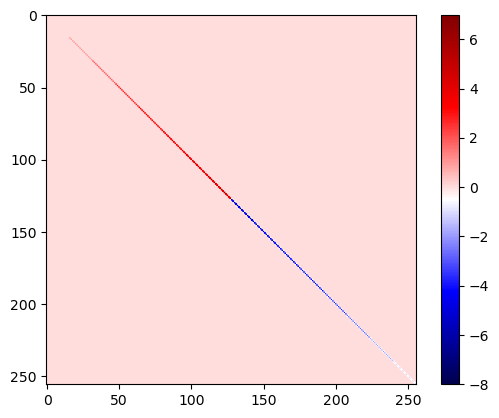

In [318]:
plt.imshow(KX_a1[6,:,:], cmap='seismic')
plt.colorbar()

### 2.2.2 check psi2 model $d\Psi_2 = a_0+a_1\Psi_2$

In [31]:
# check psi2 model
# N = 2000
# kx = np.fft.fftfreq(K) * K
# ky = np.fft.fftfreq(K) * K
# KX, KY = np.meshgrid(kx, ky)
# K_squared = KX**2 + KY**2

# # prepare coefficient matrices used in DA
# A0_t, a0_t, A1_t, a1_t= get_coef_mat(KX, KY, K_squared, kd, beta, kappa, U, psi1_k_t[:,:,:N], psi2_k_t[:,:,:N], h_hat)
# # InvBoB = 1 / sigma_1**2
# InvBoB = truncated_InvBoB.flatten(order='F')
# # InvBoB = 1 / 4.**2

# initialized mean and variance
mu0 = psi2_k_t[:,:,0].flatten(order='F') # assume the initial condition is truth
K_ = mu0.shape[0] # flattened K*K
R0 = np.zeros((K_, K_), dtype='complex')
mu_t = np.zeros((K_, N), dtype='complex')  # posterior mean
mu_t[:, 0] = mu0
R_t = np.zeros((K_, N), dtype='complex')  # posterior covariance
R_t[:, 0] = np.diag(R0)  # only save the diagonal elements

# enforce conjugate symmetry
psi1_k_t[:,K//2,:] = 0
psi2_k_t[:,K//2,:] = 0
psi1_k_t[K//2,:,:] = 0
psi2_k_t[K//2,:,:] = 0

# Lagrangian DA
for i in range(1, N):
    A0 = A0_t[i-1, :]
    a0 = a0_t[i-1, :]
    A1 = A1_t[i-1, :, :]
    a1 = a1_t[i-1, :, :]
    psi1_diff = psi1_k_t[:, :, i] - psi1_k_t[:, :, i - 1]
    psi1_diff = psi1_diff.flatten(order='F')

    # Update the posterior mean and posterior covariance
#     check1 = (A1.conj().T) @ (- (A1 @ mu0) * dt)
#     check2 = (R0 @ A1.conj().T) @ (- (A1 @ mu0) * dt)
#     print(check1[4], check2[4])
    mu = mu0 + (a0 + a1 @ mu0) * dt
#     R = R0 + (a1 @ R0 + R0 @ a1.conj().T + np.diag(sigma_2**2) - (R0 @ A1.conj().T) * InvBoB @ A1 @ R0.conj().T) * dt
    mu_t[:, i] = mu
#     R_t[:, i] = np.diag(R)
    mu0 = psi2_k_t[:,:,i].flatten(order='F')
#     R0 = R


In [32]:
# reshape flattened variables to two modes matrices
K_cut = int(np.sqrt(K_))
mu_t = mu_t.reshape((K_cut,K_cut,-1), order='F')
mu_t.shape

(16, 16, 2000)

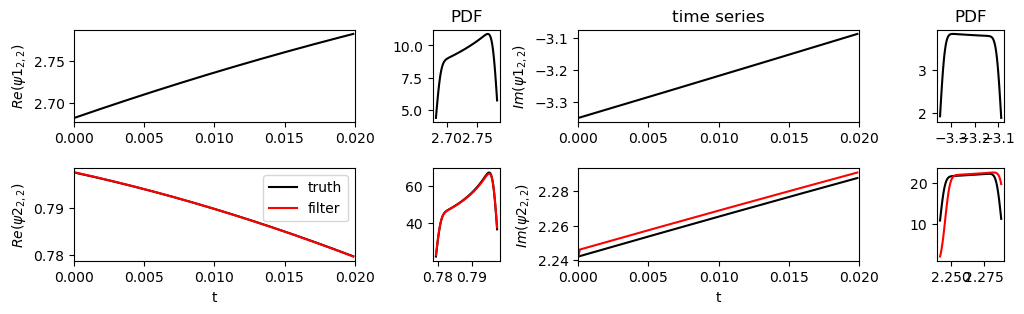

In [33]:
# Plot
sel0 = 0; sel1 = N # plot time range
ikx = 2; iky = 2 # mode to plot
interv = 10 # plot interval
xaxis = np.arange(sel0*dt, sel1*dt, interv*dt)

fig = plt.figure(figsize=(12,3))
widths = [5, 1.2, 5, 1.2]
heights = [1, 1]
spec = fig.add_gridspec(ncols=4, nrows=2, width_ratios=widths, height_ratios=heights)

plt.subplots_adjust(wspace=0.45, hspace=0.5)     # Adjust the overall spacing of the figure
ax1 = fig.add_subplot(spec[0, 0])
ax2 = fig.add_subplot(spec[1, 0])
ax3 = fig.add_subplot(spec[0, 1])
ax4 = fig.add_subplot(spec[1, 1])
ax11 = fig.add_subplot(spec[0, 2])
ax22 = fig.add_subplot(spec[1, 2])
ax33 = fig.add_subplot(spec[0, 3])
ax44 = fig.add_subplot(spec[1, 3])

# plot time series
ax1.plot(xaxis, psi1_k_t[iky,ikx,sel0:sel1:interv].real, 'k')
ax1.set_xlim(sel0*dt, sel1*dt)
ax1.set_ylabel('$Re(\psi1_{{{:d},{:d}}})$'.format(ikx, iky))

ax2.plot(xaxis, psi2_k_t[iky,ikx,sel0:sel1:interv].real, 'k', label='truth')
ax2.plot(xaxis, mu_t[iky,ikx,sel0:sel1:interv].real, 'r', label='filter')
ax2.set_xlim(sel0*dt, sel1*dt)
ax2.set_ylabel(r'$Re(\psi2_{{{:d},{:d}}})$'.format(ikx, iky))
ax2.set_xlabel('t')
ax2.legend()
# ax2.set_xlim(0,0.01)
# ax2.set_ylim(-2.58,-2.56)

# plot pdf
samples = psi1_k_t[iky, ikx, :N].real
kde = gaussian_kde(samples)
xticks = np.linspace(samples.min(), samples.max(), 100)
p = kde.evaluate(xticks)
ax3.plot(xticks, p, 'k')
ax3.set_title('PDF')

samples = psi2_k_t[iky, ikx, :N].real
kde = gaussian_kde(samples)
xticks = np.linspace(samples.min(), samples.max(), 100)
p = kde.evaluate(xticks)
ax4.plot(xticks, p, 'k', label='truth')
samples = mu_t[iky, ikx, :].real
kde = gaussian_kde(samples)
p = kde.evaluate(xticks)
ax4.plot(xticks, p, 'r', label='filter')

ax11.plot(xaxis, psi1_k_t[iky,ikx,sel0:sel1:interv].imag, 'k')
ax11.set_xlim(sel0*dt, sel1*dt)
ax11.set_ylabel('$Im(\psi1_{{{:d},{:d}}})$'.format(ikx, iky))
ax11.set_title('time series')

ax22.plot(xaxis, psi2_k_t[iky,ikx,sel0:sel1:interv].imag, 'k', label='truth')
ax22.plot(xaxis, mu_t[iky,ikx,sel0:sel1:interv].imag, 'r', label='filter')
ax22.set_xlim(sel0*dt, sel1*dt)
ax22.set_ylabel(r'$Im(\psi2_{{{:d},{:d}}})$'.format(ikx, iky))
ax22.set_xlabel('t')

# plot pdf
samples = psi1_k_t[iky, ikx, :N].imag
kde = gaussian_kde(samples)
xticks = np.linspace(samples.min(), samples.max(), 100)
p = kde.evaluate(xticks)
ax33.plot(xticks, p, 'k')
ax33.set_title('PDF')

samples = psi2_k_t[iky, ikx, :N].imag
kde = gaussian_kde(samples)
xticks = np.linspace(samples.min(), samples.max(), 100)
p = kde.evaluate(xticks)
ax44.plot(xticks, p, 'k', label='truth')
samples = mu_t[iky, ikx, :].imag
kde = gaussian_kde(samples)
p = kde.evaluate(xticks)
ax44.plot(xticks, p, 'r', label='filter')
# plt.savefig('./Lagrangian_DA/LagDA_K16_CG_tr.png',dpi=100)
plt.show()

In [22]:
print(psi2_k_t[iky,ikx,:30:10].real)
print(mu_t[iky,ikx,:30:10].real)
print(psi2_k_t[iky,ikx,:3].imag)
print(mu_t[iky,ikx,:3].imag)

[0.79747612 0.79741141 0.79734644]
[0.79747612 0.7974679  0.79740216]
[2.24220092 2.24222412 2.24224732]
[2.24220092 2.24600712 2.24603003]


where does this bias come from?

In [24]:
# ifft to real space
psi1_t = np.zeros_like(psi1_k_t)
psi2_t = np.zeros_like(psi2_k_t)
psi2_pos = np.zeros_like(mu_t)
for i in range(N):
    psi1_t[:,:,i] = np.fft.ifft2(psi1_k_t[:, :, i])
    psi2_t[:,:,i] = np.fft.ifft2(psi2_k_t[:, :, i])
    psi2_pos[:,:,i] = np.fft.ifft2(mu_t[:, :, i])

# check imaginary part
# max_imag_abs = max(np.max(np.abs(np.imag(psi1_t))), np.max(np.abs(np.imag(psi2_t))))
max_imag_abs = max(np.max(np.abs(np.imag(psi1_t))), np.max(np.abs(np.imag(psi2_t))), np.max(np.abs(np.imag(psi2_pos))))
if max_imag_abs > 1e-10:
    raise Exception("get significant imaginary parts, check ifft2")
else:
    psi1_t = np.real(psi1_t)
    psi2_t = np.real(psi2_t)
    psi2_pos = np.real(psi2_pos)

# shift domain from [0,2pi) to [-pi,pi)
psi1_t = np.roll(psi1_t, shift=K//2, axis=0) 
psi1_t = np.roll(psi1_t, shift=K//2, axis=1) 
psi2_t = np.roll(psi2_t, shift=K//2, axis=0)
psi2_t = np.roll(psi2_t, shift=K//2, axis=1)
psi2_pos = np.roll(psi2_pos, shift=K//2, axis=0)
psi2_pos = np.roll(psi2_pos, shift=K//2, axis=1)

In [25]:
np.max(np.abs(np.imag(psi2_pos)))

0.0

psi2_pos should not have imaginary parts, check code

### check conjugate symmetric for each component

In [26]:
verify_conjugate_symmetry(psi2_pos[:,:,1])

False

In [28]:
psi1_hat = psi1_k_t[:,:,:N]
K = KX.shape[0]

# psi_hat, hk should be of shape (N, K, K), if not, reshape them to make it legible
if psi1_hat.shape[-2:] != KX.shape:
    psi1_hat = np.transpose(psi1_hat, axes=(2,0,1))

# make sure \partial psi1_k / \partial x be conjugate symmetric
psi1_hat[:, :, K//2] = 0
psi1_hat[:, K//2, :] = 0


#### check linear a0

In [29]:
a0_ = a0.reshape((K,K), order='F')
a0_.shape
verify_conjugate_symmetry(a0_)
# linear_a0 = 1j * KX * ((kd**2/2 * beta - kd**2 * K_squared * U)*psi1_hat)# - (K_squared + kd**2/2) * U * h_hat)
linear_a0 = 1j * KX * (psi1_hat)# - (K_squared + kd**2/2) * U * h_hat)
verify_conjugate_symmetry(linear_a0[1,:,:])
# verify_conjugate_symmetry(psi1_hat[1,:,:])

True

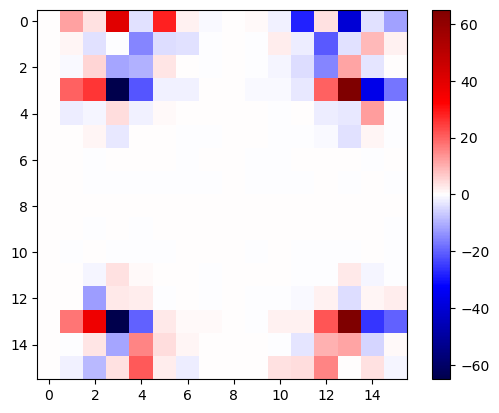

In [30]:
plt.imshow(linear_a0[1,:,:].imag, cmap='seismic', vmin=-65, vmax=65)
plt.colorbar()

In [379]:
def find_non_conjugate_pairs(Y):
    """
    Identifies pairs of entries that are not complex conjugate if the matrix Y does not pass the verification.
    
    Parameters:
    - Y: np.ndarray, a numpy array representing the matrix.
    
    Returns:
    - list of tuple, pairs of indices that are not complex conjugate.
    """
    non_conjugate_pairs = []
    
    # Check condition 1
    for i in range(1, Y.shape[1]):
        if not np.isclose(Y[0, i], np.conj(Y[0, -i])):
            non_conjugate_pairs.append(((0, i), (0, -i)))
    
    # Check condition 2
    for i in range(1, Y.shape[0]):
        if not np.isclose(Y[i, 0], np.conj(Y[-i, 0])):
            non_conjugate_pairs.append(((i, 0), (-i, 0)))
    
    # Check condition 3
    for i in range(1, Y.shape[0]):
        for j in range(1, Y.shape[1]):
            if not np.isclose(Y[i, j], np.conj(Y[-i, -j])):
                non_conjugate_pairs.append(((i, j), (-i, -j)))
    
    return non_conjugate_pairs

find_non_conjugate_pairs(linear_a0[1,:,:])

[((0, 8), (0, -8)),
 ((1, 8), (-1, -8)),
 ((2, 8), (-2, -8)),
 ((3, 8), (-3, -8)),
 ((4, 8), (-4, -8)),
 ((5, 8), (-5, -8)),
 ((6, 8), (-6, -8)),
 ((7, 8), (-7, -8)),
 ((8, 8), (-8, -8)),
 ((9, 8), (-9, -8)),
 ((10, 8), (-10, -8)),
 ((11, 8), (-11, -8)),
 ((12, 8), (-12, -8)),
 ((13, 8), (-13, -8)),
 ((14, 8), (-14, -8)),
 ((15, 8), (-15, -8))]

In [401]:
print(psi1_hat[1,10,8], psi1_hat[1,-10,-8])

0j 0j


In [394]:
print(1j*psi1_hat[1,10,8], 1j*psi1_hat[1,-10,-8])

(0.00029169481071127405+9.519093750808495e-05j) (-0.00029169481071127405+9.519093750808495e-05j)


In [395]:
print(1j*KX[10,8]*psi1_hat[1,10,8], 1j*KX[10,8]*psi1_hat[1,-10,-8])

(-0.0023335584856901924-0.0007615275000646796j) (0.0023335584856901924-0.0007615275000646796j)


In [381]:
print(linear_a0[1,10,8], linear_a0[1,-10,-8])

(-0.0023335584856901924-0.0007615275000646796j) (0.0023335584856901924-0.0007615275000646796j)


In [389]:
print(linear_a0[1,10,-7], linear_a0[1,-10,7])

(0.006495611339497785-0.006156421579012711j) (0.006495611339497785+0.006156421579012711j)


In [400]:
# set psi1_hat[:,:,K//2] = 0 to make \partial \psi1_k / \partial x conjugate symmetric
psi1_hat[:,:,K//2] = 0

In [406]:
a0_ = a0.reshape((K,K), order='F')
a0_.shape
verify_conjugate_symmetry(a0_)
linear_a0 = 1j * KX * ((kd**2/2 * beta - kd**2 * K_squared * U)*psi1_hat - (K_squared + kd**2/2) * U * h_hat)
verify_conjugate_symmetry(linear_a0[1,:,:])
# verify_conjugate_symmetry(psi1_hat[1,:,:])

True

#### check nonlinear A0,a0

In [458]:
# check nonlinear_sum_a0
N = 3
psi1_hat = psi1_k_t[:,:,:N]
psi2_hat = psi2_k_t[:,:,:N]
K = KX.shape[0]

# psi_hat, hk should be of shape (N, K, K), if not, reshape them to make it legible
if psi1_hat.shape[-2:] != KX.shape:
    psi1_hat = np.transpose(psi1_hat, axes=(2,0,1))
if psi2_hat.shape[-2:] != KX.shape:
    psi2_hat = np.transpose(psi2_hat, axes=(2,0,1))
if h_hat.shape[-2:] != KX.shape:
    h_hat = np.transpose(h_hat, axes=(2,0,1))

# make sure \partial psi1_k / \partial x be conjugate symmetric
psi1_hat[:, :, K//2] = 0

# define Ck for each wave number
Ck = 1 / (K_squared * (K_squared + kd**2))
Ck[K_squared == 0] = 0  # avoid division by zero at k = 0, constant mode

# linear part for A0, a0, A1 and a1
linear_A0 = 1j * KX * (((K_squared + kd**2/2)*beta - K_squared**2 * U)*psi1_hat - kd**2/2 * U * h_hat)
linear_a0 = 1j * KX * ((kd**2/2 * beta - kd**2 * K_squared * U)*psi1_hat - (K_squared + kd**2/2) * U * h_hat)
linear_A1_diag = 1j * KX * (kd**2/2 * beta + kd**2 * K_squared * U) - (kd**2/2 * kappa * K_squared)
linear_a1_diag = 1j * KX * ((K_squared + kd**2/2)*beta + K_squared**2 * U) - (K_squared + kd**2/2) * kappa * K_squared
linear_A1 = np.tile(np.diag(linear_A1_diag.flatten(order='F'))[None,:,:], (psi1_hat.shape[0],1,1)) 
linear_a1 = np.tile(np.diag(linear_a1_diag.flatten(order='F'))[None,:,:], (psi1_hat.shape[0],1,1)) 

# nonlinear summation part for A0, a0, A1 and a1
nonlinear_sum_A0 = np.zeros_like(psi1_hat, dtype=complex)
nonlinear_sum_a0 = np.zeros_like(psi1_hat, dtype=complex)
nonlinear_sum_A1 = np.zeros_like(linear_A1, dtype=complex)
nonlinear_sum_a1 = np.zeros_like(linear_a1, dtype=complex)
k_index_map = {(KX[iy, ix], KY[iy, ix]): (ix, iy) for ix in range(K) for iy in range(K)}

# check 
det_sum = np.zeros(KX.shape)
Jacobi_2_diff = np.zeros_like(psi1_hat, dtype=complex)

for imx in range(K):
    for imy in range(K):
        m = [KX[imy, imx], KY[imy, imx]]
        psi1_m = psi1_hat[:, imy, imx]
        psi2_m = psi2_hat[:, imy, imx]

        for inx in range(K):
            for iny in range(K):
                n = [KX[iny, inx], KY[iny, inx]]
                psi1_n = psi1_hat[:, iny, inx]
                psi2_n = psi2_hat[:, iny, inx]
                h_n = h_hat[iny, inx]

                # Check if k is within the wave number sets
                k = (m[0] + n[0], m[1] + n[1])

                if k in k_index_map:
                    ikx, iky = k_index_map[k]
                    ik_flatten = ikx * K + iky
                    im_flatten = imx * K + imy
                    k_mod = K_squared[iky, ikx]
                    det_mn = np.linalg.det(np.array([m, n]))
#                     nonlinear_sum_A0[:, iky, ikx] -= det_mn * ((k_mod + kd**2 / 2)**2 * psi1_n * psi1_m)
#                     nonlinear_sum_a0[:, iky, ikx] -= det_mn * (kd**2 / 2 * (k_mod + kd**2 / 2) * psi1_n * psi1_m)
                    nonlinear_sum_A1[:, ik_flatten, im_flatten] += det_mn * kd**2 / 2 * (k_mod * psi1_n - h_n)
                    nonlinear_sum_a1[:, ik_flatten, im_flatten] -= det_mn * (k_mod * kd**2 / 2 * psi1_n - (k_mod + kd**2 / 2) * h_n)  
                    
                    if k == (2,3):
                        inc = -det_mn * (kd**2 / 2 * (k_mod + kd**2 / 2) * psi1_n * psi1_m)
                        print(m,n,det_mn,inc[1],nonlinear_sum_a0[1, iky, ikx])


/var/folders/lz/50081q0n24g8lq6ncqpbp8780000gn/T/ipykernel_3702/1206322957.py:18: RuntimeWarning: divide by zero encountered in divide
  Ck = 1 / (K_squared * (K_squared + kd**2))


[0.0, 0.0] [2.0, 3.0] 0.0 (-0+0j) 0j
[0.0, 1.0] [2.0, 2.0] -2.0 (46300.73453979516-103758.09451207852j) (46300.73453979516-103758.09451207852j)
[0.0, 2.0] [2.0, 1.0] -4.0 (330097.6836453896-309845.26726446295j) (376398.41818518477-413603.36177654145j)
[0.0, 3.0] [2.0, 0.0] -6.0 (-98329.2553532403-84618.68943836734j) (278069.1628319445-498222.0512149088j)
[0.0, 4.0] [2.0, -1.0] -7.999999999999998 (285000.0030741074+233207.15772693657j) (563069.1659060519-265014.8934879722j)
[0.0, 5.0] [2.0, -2.0] -9.999999999999998 (-60043.48783959501-103912.62822034942j) (503025.67806645687-368927.52170832164j)
[0.0, 6.0] [2.0, -3.0] -12.0 (-193752.0025931318+11977.206332552956j) (309273.6754733251-356950.3153757687j)
[0.0, 7.0] [2.0, -4.0] -13.999999999999996 (10607.461986055672+3887.601288454763j) (319881.1374593807-353062.7140873139j)
[0.0, -4.0] [2.0, 7.0] 7.999999999999998 (-523.7881940220248-34.48736220383314j) (319357.3492653587-353097.20144951774j)
[0.0, -3.0] [2.0, 6.0] 6.0 (-2649.678759451448

[6.0, -4.0] [-4.0, 7.0] 26.000000000000004 (7.464437458197472-16.536227861461736j) (11669008.083384866+13504245.101932842j)
[6.0, -3.0] [-4.0, 6.0] 23.999999999999993 (1905.0034102565783+719.5942496843562j) (11670913.086795123+13504964.696182527j)
[6.0, -2.0] [-4.0, 5.0] 22.000000000000004 (-1819.698265424765-5126.135234951523j) (11669093.3885297+13499838.560947575j)
[6.0, -1.0] [-4.0, 4.0] 20.000000000000007 (22559.589920105962+14853.263485603056j) (11691652.978449805+13514691.824433178j)
[7.0, 0.0] [-5.0, 3.0] 21.0 (2820.3624686186713-13996.52359189493j) (11694473.340918424+13500695.300841283j)
[7.0, 1.0] [-5.0, 2.0] 18.999999999999996 (2063.645301330732+480.7862817445044j) (11696536.986219754+13501176.087123027j)
[7.0, 2.0] [-5.0, 1.0] 17.0 (361.17251136035105+3480.502531834425j) (11696898.158731114+13504656.589654861j)
[7.0, 3.0] [-5.0, 0.0] 14.999999999999993 (24412.275256296954+31279.3570262472j) (11721310.43398741+13535935.946681108j)
[7.0, 4.0] [-5.0, -1.0] 12.999999999999995 (

[-1.0, 7.0] [3.0, -4.0] -17.0 (5994.388135358516+3885.6942803946513j) (-7075.150249099796+59573.56013587735j)
[-1.0, -4.0] [3.0, 7.0] 5.000000000000001 (-117.09553632380504-538.8678881413583j) (-7192.245785423602+59034.69224773599j)
[-1.0, -3.0] [3.0, 6.0] 3.0000000000000004 (-4634.495029312852-48245.88581810582j) (-11826.740814736455+10788.806429630175j)
[-1.0, -2.0] [3.0, 5.0] 1.0000000000000004 (-4461.572778241056-3237.841709222691j) (-16288.31359297751+7550.964720407484j)
[-1.0, -1.0] [3.0, 4.0] -0.9999999999999998 (16288.313592978513-7550.9647204076855j) (1.002263161353767e-09-2.0190782379359007e-10j)


In [456]:
m = [-1,-1]
psi1_m = psi1_hat[1, -1, -1]
n = [3,4]
psi1_n = psi1_hat[1, 4, 3]
k_mod = K_squared[3, 2]
det_mn = np.linalg.det(np.array([m, n]))
det_mn * (kd**2 / 2 * (k_mod + kd**2 / 2) * psi1_n * psi1_m)

(-16288.313592978513+7550.9647204076855j)

In [422]:
verify_conjugate_symmetry(nonlinear_sum_a0[1,:,:])

False

In [424]:
find_non_conjugate_pairs(nonlinear_sum_a0[1,:,:])

[((6, 0), (-6, 0)), ((10, 0), (-10, 0))]

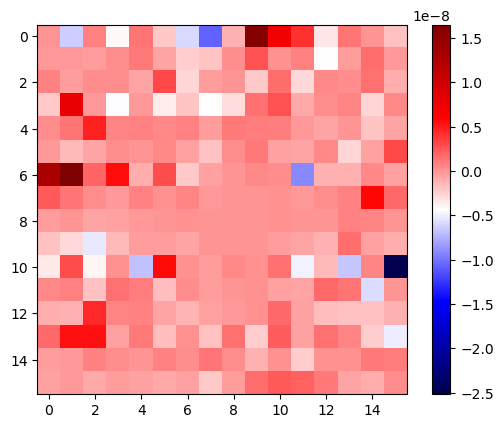

In [431]:
plt.imshow(nonlinear_sum_a0[1,:,:].imag, cmap='seismic')#, vmin=-65, vmax=65)
plt.colorbar()

In [460]:
np.max(np.abs(nonlinear_sum_A0))

4.990006839487132e-08

nonlinear_sum_a0 is zero

#### check a1$\Psi_2$

In [63]:
def get_coef_mat(KX, KY, K_squared, kd, beta, kappa, U, psi1_hat, psi2_hat, h_hat):
    K = KX.shape[0]
    
    # psi_hat, hk should be of shape (N, K, K), if not, reshape them to make it legible
    if psi1_hat.shape[-2:] != KX.shape:
        psi1_hat = np.transpose(psi1_hat, axes=(2,0,1))
    if psi2_hat.shape[-2:] != KX.shape:
        psi2_hat = np.transpose(psi2_hat, axes=(2,0,1))
    if h_hat.shape[-2:] != KX.shape:
        h_hat = np.transpose(h_hat, axes=(2,0,1))

    # make sure \partial psi1_k / \partial x be conjugate symmetric
    psi1_hat[:, :, K//2] = 0
    psi2_hat[:, :, K//2] = 0

    # define Ck for each wave number
    Ck = 1 / (K_squared * (K_squared + kd**2))
    Ck[K_squared == 0] = 0  # avoid division by zero at k = 0, constant mode

    # linear part for A0, a0, A1 and a1
    linear_A0 = 1j * KX * (((K_squared + kd**2/2)*beta - K_squared**2 * U)*psi1_hat - kd**2/2 * U * h_hat)
    linear_a0 = 1j * KX * ((kd**2/2 * beta - kd**2 * K_squared * U)*psi1_hat - (K_squared + kd**2/2) * U * h_hat)
    linear_A1_diag = 1j * KX * (kd**2/2 * beta + kd**2 * K_squared * U) - (kd**2/2 * kappa * K_squared)
    linear_a1_diag = 1j * KX * ((K_squared + kd**2/2)*beta + K_squared**2 * U) - (K_squared + kd**2/2) * kappa * K_squared
    linear_A1 = np.tile(np.diag(linear_A1_diag.flatten(order='F'))[None,:,:], (psi1_hat.shape[0],1,1)) 
    linear_a1 = np.tile(np.diag(linear_a1_diag.flatten(order='F'))[None,:,:], (psi1_hat.shape[0],1,1)) 
    
    # nonlinear summation part for A0, a0, A1 and a1
    nonlinear_sum_A0 = np.zeros_like(psi1_hat, dtype=complex)
    nonlinear_sum_a0 = np.zeros_like(psi1_hat, dtype=complex)
    nonlinear_sum_A1 = np.zeros_like(linear_A1, dtype=complex)
    nonlinear_sum_a1 = np.zeros_like(linear_a1, dtype=complex)
    k_index_map = {(KX[iy, ix], KY[iy, ix]): (ix, iy) for ix in range(K) for iy in range(K)}
    
    # check 
    det_sum = np.zeros(KX.shape)
    Jacobi_2_diff = np.zeros_like(psi1_hat, dtype=complex)
    
    for imx in range(K):
        for imy in range(K):
            m = [KX[imy, imx], KY[imy, imx]]
            psi1_m = psi1_hat[:, imy, imx]
            psi2_m = psi2_hat[:, imy, imx]

            for inx in range(K):
                for iny in range(K):
                    n = [KX[iny, inx], KY[iny, inx]]
                    psi1_n = psi1_hat[:, iny, inx]
                    psi2_n = psi2_hat[:, iny, inx]
                    h_n = h_hat[iny, inx]
                    
                    # Check if k is within the wave number sets
                    k = (m[0] + n[0], m[1] + n[1])
                    
                    if k in k_index_map:
                        ikx, iky = k_index_map[k]
                        ik_flatten = ikx * K + iky
                        im_flatten = imx * K + imy
                        k_mod = K_squared[iky, ikx]
                        det_mn = np.linalg.det(np.array([m, n]))
#                         nonlinear_sum_A0[:, iky, ikx] -= det_mn * ((k_mod + kd**2 / 2)**2 * psi1_n * psi1_m)
#                         nonlinear_sum_a0[:, iky, ikx] -= det_mn * (kd**2 / 2 * (k_mod + kd**2 / 2) * psi1_n * psi1_m)
                        nonlinear_sum_A1[:, ik_flatten, im_flatten] += det_mn * kd**2 / 2 * (k_mod * psi1_n - h_n)
                        nonlinear_sum_a1[:, ik_flatten, im_flatten] -= det_mn * (k_mod * kd**2 / 2 * psi1_n - (k_mod + kd**2 / 2) * h_n) 
                        
                        if k == (3,2) and np.isclose(np.abs(det_mn),3):
                            incc = -det_mn * (k_mod * kd**2 / 2 * psi1_n - (k_mod + kd**2 / 2) * h_n)
                            print(m,n,det_mn,incc[1])
    
                        det_sum[iky,ikx] += det_mn
                        Jacobi_2_diff[:,iky,ikx] -= det_mn *  ((k_mod + kd**2 / 2)**2 * psi2_n * psi2_m)
    # aggregate 
    A0 = linear_A0 + nonlinear_sum_A0
    a0 = linear_a0 + nonlinear_sum_a0
    A1 = linear_A1 + nonlinear_sum_A1
    a1 = linear_a1 + nonlinear_sum_a1
    
#     # enforce conjugate symmetry
#     a1[:, 8::K, :] = 0
#     a1[:, 8*K:9*K, :] = 0
    
    # normalization 
    Ck_ = np.tile(Ck.flatten(order='F')[None,:,None], (psi1_hat.shape[0],1,K**2))
    A0 = Ck * A0
    a0 = Ck * a0
    A1 = Ck_ * A1
    a1 = Ck_ * a1
    
    # flatten
    A0 = A0.reshape((A0.shape[0], -1), order='F')
    a0 = a0.reshape((a0.shape[0], -1), order='F')
    
    return A0, a0, A1, a1, np.tile(Ck.flatten(order='F')[:,None], (1,K**2)) * nonlinear_sum_A1, det_sum, Jacobi_2_diff

N = 3
kx = np.fft.fftfreq(K) * K
ky = np.fft.fftfreq(K) * K
KX, KY = np.meshgrid(kx, ky)
K_squared = KX**2 + KY**2

# prepare coefficient matrices used in DA
A0_t, a0_t, A1_t, a1_t, nonlinear_A1, det_sum, Jacobi_2_diff = get_coef_mat(KX, KY, K_squared, kd, beta, kappa, U, psi1_k_t[:,:,:N], psi2_k_t[:,:,:N], h_hat)
# InvBoB = 1 / sigma_1**2
# InvBoB = truncated_InvBoB.flatten(order='F')
InvBoB = 1 / 4.**2

# initialized mean and variance
mu0 = psi2_k_t[:,:,0].flatten(order='F') # assume the initial condition is truth
K_ = mu0.shape[0] # flattened K*K
R0 = np.zeros((K_, K_), dtype='complex')
mu_t = np.zeros((K_, N), dtype='complex')  # posterior mean
mu_t[:, 0] = mu0
R_t = np.zeros((K_, N), dtype='complex')  # posterior covariance
R_t[:, 0] = np.diag(R0)  # only save the diagonal elements

# enforce conjugate symmetric
psi1_k_t[:,K//2,:] = 0
psi2_k_t[:,K//2,:] = 0
psi1_k_t[K//2,:,:] = 0
psi2_k_t[K//2,:,:] = 0

# Lagrangian DA
for i in range(1, N):
    A0 = A0_t[i-1, :]
    a0 = a0_t[i-1, :]
    A1 = A1_t[i-1, :, :]
    a1 = a1_t[i-1, :, :]
    psi1_diff = psi1_k_t[:, :, i] - psi1_k_t[:, :, i - 1]
    psi1_diff = psi1_diff.flatten(order='F')

    # Update the posterior mean and posterior covariance
    mu = mu0 + (a0 + a1 @ mu0) * dt #+ (R0 @ A1.conj().T) * InvBoB @ (psi1_diff - (A0 + A1 @ mu0) * dt)
#     R = R0 + (a1 @ R0 + R0 @ a1.conj().T + np.diag(sigma_2**2) - (R0 @ A1.conj().T) * InvBoB @ A1 @ R0.conj().T) * dt
    mu_t[:, i] = mu
#     R_t[:, i] = np.diag(R)
    mu0 = psi2_k_t[:,:,i].flatten(order='F')
#     R0 = R

/var/folders/lz/50081q0n24g8lq6ncqpbp8780000gn/T/ipykernel_36777/3534367647.py:17: RuntimeWarning: divide by zero encountered in divide
  Ck = 1 / (K_squared * (K_squared + kd**2))


[0.0, 1.0] [3.0, 1.0] -3.0000000000000004 (-36.64029449486745-1403.1054246066421j)
[0.0, -1.0] [3.0, 3.0] 3.0000000000000004 (57141.82187130008-10235.941253219919j)
[3.0, 1.0] [0.0, 1.0] 3.0000000000000004 (-7930.766611552221+2071.839308490026j)
[3.0, 3.0] [0.0, -1.0] -3.0000000000000004 (7930.766611552221+2071.839308490026j)
[6.0, 3.0] [-3.0, -1.0] 2.9999999999999996 (36.64029449486743-1403.105424606642j)
[6.0, 5.0] [-3.0, -3.0] -2.9999999999999996 (-57141.82187130006-10235.941253219915j)
[-3.0, -3.0] [6.0, 5.0] 2.9999999999999996 (3.0526843007585387-15.383745004631743j)
[-3.0, -1.0] [6.0, 3.0] -2.9999999999999996 (-631.6970416331801-329.7112258989139j)


one can accelarate the calculation by leveraging complex conjugate property.  <br> For example, $\hat{\psi}_{1,n}$ and  $\hat{\psi}_{1,-n}$ is complex conjugate, and $det(k-n,n) = - det(k+n,-n)$. Therefore, $det(k+n,-n)\hat{\psi}_{1,-n} = -det(k-n,n)\hat{\psi}_{1,n}^*$

In [64]:
# reshape flattened variables to two modes matrices
mu_t = mu_t.reshape((K,K,-1), order='F')
mu_t.shape

(16, 16, 3)

In [65]:
verify_conjugate_symmetry(mu_t[:,:,1])

False

In [66]:
a0_ = a0.reshape((K,K,-1), order='F')
a0_.shape

(16, 16, 1)

In [67]:
verify_conjugate_symmetry(a0_[:,:,0])

True

In [68]:
a1mu0 = a1 @ mu0
a1mu0 = a1mu0.reshape((K,K,-1), order='F')
a1mu0.shape

(16, 16, 1)

In [91]:
a1mu0 = a1 @ mu0
a1mu0 = a1mu0.reshape((K,K,-1), order='F')
a1mu0.shape

(16, 16, 1)

checked linear_a1 to make psi2_hat[:, :, K//2] = 0, now linear_a1@mu0 is conjugate symmetric

In [69]:
verify_conjugate_symmetry(a1mu0[:,:,0])

False

In [70]:
verify_conjugate_symmetry(psi2_k_t[:,:,1])

True

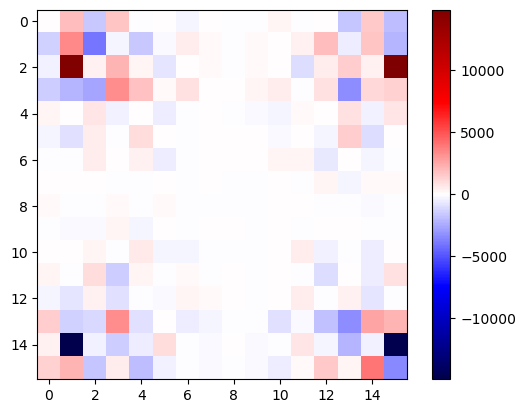

In [71]:
plt.imshow(a1mu0[:,:,0].imag, cmap='seismic')#, vmin=-6*1e6, vmax=6*1e6)
plt.colorbar()

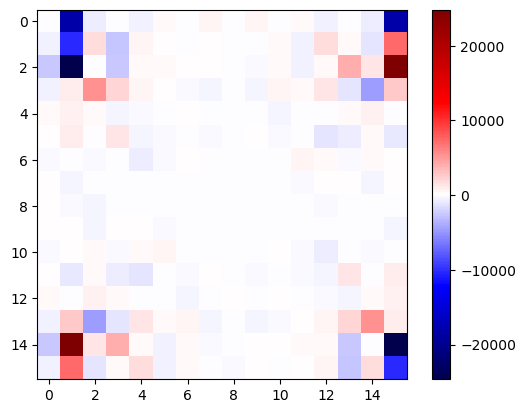

In [72]:
plt.imshow(a1mu0[:,:,0].real, cmap='seismic')#, vmin=-65, vmax=65)
plt.colorbar()

In [73]:
find_non_conjugate_pairs(a1mu0[:,:,0])

[((0, 8), (0, -8)),
 ((8, 0), (-8, 0)),
 ((1, 8), (-1, -8)),
 ((2, 8), (-2, -8)),
 ((3, 8), (-3, -8)),
 ((4, 8), (-4, -8)),
 ((5, 8), (-5, -8)),
 ((6, 8), (-6, -8)),
 ((7, 8), (-7, -8)),
 ((8, 1), (-8, -1)),
 ((8, 2), (-8, -2)),
 ((8, 3), (-8, -3)),
 ((8, 4), (-8, -4)),
 ((8, 5), (-8, -5)),
 ((8, 6), (-8, -6)),
 ((8, 7), (-8, -7)),
 ((8, 8), (-8, -8)),
 ((8, 9), (-8, -9)),
 ((8, 10), (-8, -10)),
 ((8, 11), (-8, -11)),
 ((8, 12), (-8, -12)),
 ((8, 13), (-8, -13)),
 ((8, 14), (-8, -14)),
 ((8, 15), (-8, -15)),
 ((9, 8), (-9, -8)),
 ((10, 8), (-10, -8)),
 ((11, 8), (-11, -8)),
 ((12, 8), (-12, -8)),
 ((13, 8), (-13, -8)),
 ((14, 8), (-14, -8)),
 ((15, 8), (-15, -8))]

In [74]:
print(a1mu0[0,3,0], a1mu0[0,-3,0])

(84.28697376103867+1665.0320394532464j) (84.28697376103864-1665.0320394532478j)


In [75]:
print(a1mu0[2,3,0], a1mu0[-2,-3,0])

(-2551.916412812196+2107.5812944844124j) (-2551.9164128121934-2107.581294484413j)


In [76]:
print(a1mu0[15,10,0], a1mu0[-15,-10,0])

(-25.419016699557773-474.29723596159454j) (-25.419016699557787+474.2972359615946j)


In [77]:
def verify_conjugate_symmetry_(Y, atol=10, rtol=1e-5):
    """
    Checks if the matrix Y is conjugate symmetric based on the given conditions.
    
    Parameters:
    - Y: np.ndarray, a numpy array representing the matrix.
    
    Returns:
    - bool, True if the matrix Y is conjugate symmetric, False otherwise.
    """
    # Condition 1: Check if Y[0, 1:] is conjugate symmetric
    condition1 = np.allclose(Y[0, 1:], np.conj(Y[0, -1:0:-1]), atol=atol, rtol=rtol)
    
    # Condition 2: Check if Y[1:, 0] is conjugate symmetric
    condition2 = np.allclose(Y[1:, 0], np.conj(Y[-1:0:-1, 0]), atol=atol, rtol=rtol)
    
    # Condition 3: Check if Y[1:, 1:] is conjugate centrosymmetric
    condition3 = np.allclose(Y[1:, 1:], np.conj(Y[-1:0:-1, -1:0:-1]), atol=atol, rtol=rtol)
    
    # Return True if all conditions are met, False otherwise
    return condition1 and condition2 and condition3

verify_conjugate_symmetry_(a1mu0[:,:,0],atol=200, rtol=1e-1)

False

In [78]:
def find_non_conjugate_pairs_(Y, atol=1, rtol=1e-3):
    """
    Identifies pairs of entries that are not complex conjugate if the matrix Y does not pass the verification.
    
    Parameters:
    - Y: np.ndarray, a numpy array representing the matrix.
    
    Returns:
    - list of tuple, pairs of indices that are not complex conjugate.
    """
    non_conjugate_pairs = []
    max_diff = 0
    
    # Check condition 1
    for i in range(1, Y.shape[1]):
        if not np.isclose(Y[0, i], np.conj(Y[0, -i]), atol=atol, rtol=rtol):
            non_conjugate_pairs.append(((0, i), (0, -i)))
            if (Y[0, i] - np.conj(Y[0, -i])).real / Y[0, i].real > max_diff:
                max_diff = (Y[0, i] - np.conj(Y[0, -i])).real / Y[0, i].real
                max_ind = ((0, i), (0, -i))
    
    # Check condition 2
    for i in range(1, Y.shape[0]):
        if not np.isclose(Y[i, 0], np.conj(Y[-i, 0]), atol=atol, rtol=rtol):
            non_conjugate_pairs.append(((i, 0), (-i, 0)))
            if (Y[0, i] - np.conj(Y[i, 0])).real / Y[-i, 0].real > max_diff:
                max_diff = (Y[i, 0] - np.conj(Y[-i, 0])).real / Y[i, 0].real
                max_ind = ((i, 0), (-i, 0))
    
    # Check condition 3
    for i in range(1, Y.shape[0]):
        for j in range(1, Y.shape[1]):
            if not np.isclose(Y[i, j], np.conj(Y[-i, -j]), atol=atol, rtol=rtol):
                non_conjugate_pairs.append(((i, j), (-i, -j)))
                if (Y[i, j] - np.conj(Y[-i, -j])).real / Y[i, j].real > max_diff:
                    max_diff = (Y[i, j] - np.conj(Y[-i, -j])).real / Y[i, j].real
                    max_ind = ((i, j), (-i, -j))
    
    return non_conjugate_pairs, max_diff, max_ind

In [79]:
find_non_conjugate_pairs_(a1mu0[:,:,0], atol=200, rtol=1e-1)

([((8, 0), (-8, 0)),
  ((1, 8), (-1, -8)),
  ((8, 2), (-8, -2)),
  ((8, 14), (-8, -14)),
  ((15, 8), (-15, -8))],
 0.934514206518497,
 ((15, 8), (-15, -8)))

In [80]:
print(a1mu0[8,9,0], a1mu0[-8,-9,0])

(3.3185911712518807-8.776067729616296j) (-21.671149902438746-3.6438558725614527j)


In [81]:
print(a1mu0[8,0,0], a1mu0[-8,0,0])

(239.06887647518545+161.1451759990315j) (239.06887647518545+161.1451759990315j)


In [82]:
print(a1mu0[0,8,0], a1mu0[0,-8,0])

(-20.143436487219653-7.031245938537722j) (-20.143436487219653-7.031245938537722j)


center: should be real-valued

In [83]:
print(a1mu0[1,8,0], a1mu0[-1,-8,0])

(-15.178372563694339-83.3291482102917j) (-231.78115063966672-31.20861263939068j)


In [84]:
print(a1mu0[15,8,0], a1mu0[-15,-8,0])

(-231.78115063966672-31.20861263939068j) (-15.178372563694339-83.3291482102917j)


In [85]:
print(a1mu0[8,2,0], a1mu0[-8,-2,0])

(-361.77625729474676-40.19300990139155j) (-64.9751086962518-191.93571297889702j)


In [86]:
print(a1mu0[2,1,0], a1mu0[-2,-1,0])

(-24638.531334846146+14698.359347068768j) (-24638.53133484615-14698.359347068774j)


this is numerical error; maybe just set the K//2 column and row to be zero (because the derivative of $\psi$, velocity, is still real-valued.

In [41]:
# reshape flattened variables to two modes matrices
mu_t = mu_t.reshape((K,K,-1), order='F')
mu_t.shape

(16, 16, 3)

In [42]:
verify_conjugate_symmetry(mu_t[:,:,1])

True

In [45]:
a1mu0 = a1 @ mu0
a1mu0 = a1mu0.reshape((K,K,-1), order='F')
a1mu0.shape

(16, 16, 1)

In [46]:
verify_conjugate_symmetry(a1mu0[:,:,0])

True

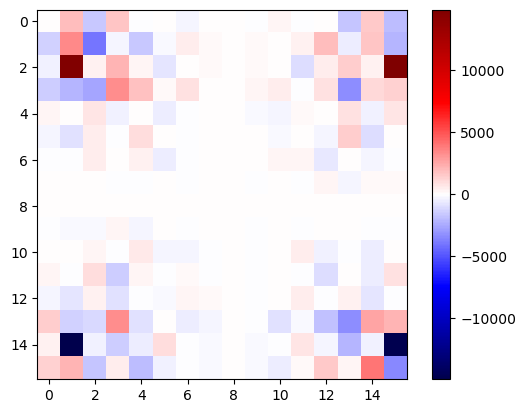

In [47]:
plt.imshow(a1mu0[:,:,0].imag, cmap='seismic')#, vmin=-6*1e6, vmax=6*1e6)
plt.colorbar()

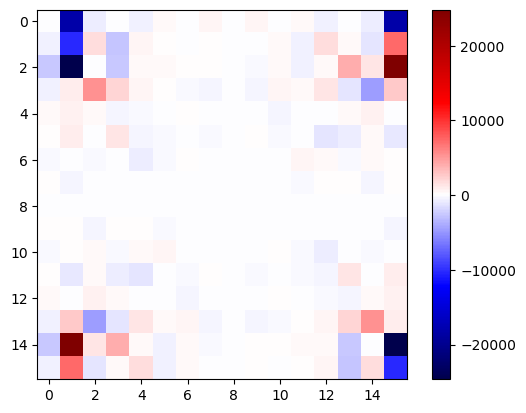

In [48]:
plt.imshow(a1mu0[:,:,0].real, cmap='seismic')#, vmin=-65, vmax=65)
plt.colorbar()

In [49]:
find_non_conjugate_pairs(a1mu0[:,:,0])

[]

In [53]:
def verify_conjugate_symmetry_(Y, atol=10, rtol=1e-5):
    """
    Checks if the matrix Y is conjugate symmetric based on the given conditions.
    
    Parameters:
    - Y: np.ndarray, a numpy array representing the matrix.
    
    Returns:
    - bool, True if the matrix Y is conjugate symmetric, False otherwise.
    """
    # Condition 1: Check if Y[0, 1:] is conjugate symmetric
    condition1 = np.allclose(Y[0, 1:], np.conj(Y[0, -1:0:-1]), atol=atol, rtol=rtol)
    
    # Condition 2: Check if Y[1:, 0] is conjugate symmetric
    condition2 = np.allclose(Y[1:, 0], np.conj(Y[-1:0:-1, 0]), atol=atol, rtol=rtol)
    
    # Condition 3: Check if Y[1:, 1:] is conjugate centrosymmetric
    condition3 = np.allclose(Y[1:, 1:], np.conj(Y[-1:0:-1, -1:0:-1]), atol=atol, rtol=rtol)
    
    # Return True if all conditions are met, False otherwise
    return condition1 and condition2 and condition3

verify_conjugate_symmetry_(a1mu0[:,:,0],atol=200, rtol=1e-1)

True

further check A1: make     A1[:, 8::K, :] = 0; A1[:, 8*K:9*K, :] = 0

In [134]:
A1mu0 = A1 @ mu0
A1mu0 = A1mu0.reshape((K,K,-1), order='F')
A1mu0.shape

(16, 16, 1)

In [135]:
verify_conjugate_symmetry(A1mu0[:,:,0])

True

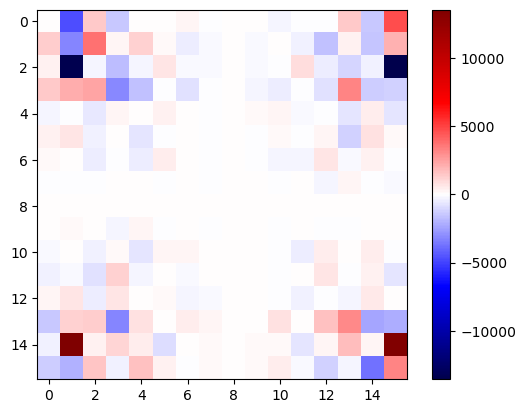

In [136]:
plt.imshow(A1mu0[:,:,0].imag, cmap='seismic')#, vmin=-6*1e6, vmax=6*1e6)
plt.colorbar()

**summation** 

To make sure the two-layer CG model, a0+a1$\hat{\psi}_2$ and A0+A1$\hat{\psi}_2$ to be conjugate symmetric, two modifications are made:

1. enforce K//2 mode of $\hat{\psi}$ to be 0
2. enforce nonlinear summations of $\hat{\psi}_1$ to be zero 

These two modifications can be justified theoretically (see reports).

### 2.2.3 check (R0 @ A1.conj().T) * InvBoB @ (psi1_diff - (A0 + A1 @ mu0) * dt)

In [4]:
# if not estimate sigma_2 by residuals
sigma_2 = 4. * np.ones(256)
sigma_2.shape

(256,)

In [64]:
def get_coef_mat(KX, KY, K_squared, kd, beta, kappa, U, psi1_hat, psi2_hat, h_hat):
    K = KX.shape[0]
    
    # psi_hat, hk should be of shape (N, K, K), if not, reshape them to make it legible
    if psi1_hat.shape[-2:] != KX.shape:
        psi1_hat = np.transpose(psi1_hat, axes=(2,0,1))
    if psi2_hat.shape[-2:] != KX.shape:
        psi2_hat = np.transpose(psi2_hat, axes=(2,0,1))
    if h_hat.shape[-2:] != KX.shape:
        h_hat = np.transpose(h_hat, axes=(2,0,1))

#     # make sure \partial psi1_k / \partial x be conjugate symmetric
#     psi1_hat[:, :, K//2] = 0
#     psi2_hat[:, :, K//2] = 0

    # define Ck for each wave number
    Ck = 1 / (K_squared * (K_squared + kd**2))
    Ck[K_squared == 0] = 0  # avoid division by zero at k = 0, constant mode

    # linear part for A0, a0, A1 and a1
    linear_A0 = 1j * KX * (((K_squared + kd**2/2)*beta - K_squared**2 * U)*psi1_hat - kd**2/2 * U * h_hat)
    linear_a0 = 1j * KX * ((kd**2/2 * beta - kd**2 * K_squared * U)*psi1_hat - (K_squared + kd**2/2) * U * h_hat)
    linear_A1_diag = 1j * KX * (kd**2/2 * beta + kd**2 * K_squared * U) - (kd**2/2 * kappa * K_squared)
    linear_a1_diag = 1j * KX * ((K_squared + kd**2/2)*beta + K_squared**2 * U) - (K_squared + kd**2/2) * kappa * K_squared
    linear_A1 = np.tile(np.diag(linear_A1_diag.flatten(order='F'))[None,:,:], (psi1_hat.shape[0],1,1)) 
    linear_a1 = np.tile(np.diag(linear_a1_diag.flatten(order='F'))[None,:,:], (psi1_hat.shape[0],1,1)) 
    
    # nonlinear summation part for A0, a0, A1 and a1
    nonlinear_sum_A0 = np.zeros_like(psi1_hat, dtype=complex)
    nonlinear_sum_a0 = np.zeros_like(psi1_hat, dtype=complex)
    nonlinear_sum_A1 = np.zeros_like(linear_A1, dtype=complex)
    nonlinear_sum_a1 = np.zeros_like(linear_a1, dtype=complex)
    k_index_map = {(KX[iy, ix], KY[iy, ix]): (ix, iy) for ix in range(K) for iy in range(K)}
    
    # check 
    det_sum = np.zeros(KX.shape)
    Jacobi_2_diff = np.zeros_like(psi1_hat, dtype=complex)
    
    for imx in range(K):
        for imy in range(K):
            m = [KX[imy, imx], KY[imy, imx]]
            psi1_m = psi1_hat[:, imy, imx]
            psi2_m = psi2_hat[:, imy, imx]

            for inx in range(K):
                for iny in range(K):
                    n = [KX[iny, inx], KY[iny, inx]]
                    psi1_n = psi1_hat[:, iny, inx]
                    psi2_n = psi2_hat[:, iny, inx]
                    h_n = h_hat[iny, inx]
                    
                    # Check if k is within the wave number sets
                    k = (m[0] + n[0], m[1] + n[1])
                    
                    if k in k_index_map:
                        ikx, iky = k_index_map[k]
                        ik_flatten = ikx * K + iky
                        im_flatten = imx * K + imy
                        k_mod = K_squared[iky, ikx]
                        det_mn = np.linalg.det(np.array([m, n]))
#                         nonlinear_sum_A0[:, iky, ikx] -= det_mn * ((k_mod + kd**2 / 2)**2 * psi1_n * psi1_m)
#                         nonlinear_sum_a0[:, iky, ikx] -= det_mn * (kd**2 / 2 * (k_mod + kd**2 / 2) * psi1_n * psi1_m)
                        nonlinear_sum_A1[:, ik_flatten, im_flatten] += det_mn * kd**2 / 2 * (k_mod * psi1_n - h_n)
                        nonlinear_sum_a1[:, ik_flatten, im_flatten] -= det_mn * (k_mod * kd**2 / 2 * psi1_n - (k_mod + kd**2 / 2) * h_n) 
                        
#                         if k == (3,2) and np.isclose(np.abs(det_mn),3):
#                             incc = -det_mn * (k_mod * kd**2 / 2 * psi1_n - (k_mod + kd**2 / 2) * h_n)
#                             print(m,n,det_mn,incc[1])
    
                        det_sum[iky,ikx] += det_mn
                        Jacobi_2_diff[:,iky,ikx] -= det_mn *  ((k_mod + kd**2 / 2)**2 * psi2_n * psi2_m)
    # aggregate 
    A0 = linear_A0 + nonlinear_sum_A0
    a0 = linear_a0 + nonlinear_sum_a0
    A1 = linear_A1 + nonlinear_sum_A1
    a1 = linear_a1 + nonlinear_sum_a1
    
    # enforce conjugate symmetry
    A1[:, 8::K, :] = 0
    A1[:, 8*K:9*K, :] = 0
    a1[:, 8::K, :] = 0
    a1[:, 8*K:9*K, :] = 0
    
    # normalization 
    Ck_ = np.tile(Ck.flatten(order='F')[None,:,None], (psi1_hat.shape[0],1,K**2))
    A0 = Ck * A0
    a0 = Ck * a0
    A1 = Ck_ * A1
    a1 = Ck_ * a1
    
    # flatten
    A0 = A0.reshape((A0.shape[0], -1), order='F')
    a0 = a0.reshape((a0.shape[0], -1), order='F')
    
    return A0, a0, A1, a1, np.tile(Ck.flatten(order='F')[:,None], (1,K**2)) * nonlinear_sum_A1, det_sum, Jacobi_2_diff

N = 2000
kx = np.fft.fftfreq(K) * K
ky = np.fft.fftfreq(K) * K
KX, KY = np.meshgrid(kx, ky)
K_squared = KX**2 + KY**2

# prepare coefficient matrices used in DA
A0_t, a0_t, A1_t, a1_t, nonlinear_A1, det_sum, Jacobi_2_diff = get_coef_mat(KX, KY, K_squared, kd, beta, kappa, U, psi1_k_t[:,:,:N], psi2_k_t[:,:,:N], h_hat)
# InvBoB = 1 / sigma_1**2
# InvBoB = truncated_InvBoB.flatten(order='F')
InvBoB = 1 / 4.**2

# initialized mean and variance
mu0 = psi2_k_t[:,:,0].flatten(order='F') # assume the initial condition is truth
K_ = mu0.shape[0] # flattened K*K
R0 = np.zeros((K_, K_), dtype='complex')
mu_t = np.zeros((K_, N), dtype='complex')  # posterior mean
mu_t[:, 0] = mu0
R_t = np.zeros((K_, N), dtype='complex')  # posterior covariance
R_t[:, 0] = np.diag(R0)  # only save the diagonal elements

# enforce conjugate symmetry
psi1_k_t[:,K//2,:] = 0
psi2_k_t[:,K//2,:] = 0
psi1_k_t[K//2,:,:] = 0
psi2_k_t[K//2,:,:] = 0

# Lagrangian DA
for i in range(1, N):
    A0 = A0_t[i-1, :]
    a0 = a0_t[i-1, :]
    A1 = A1_t[i-1, :, :]
    a1 = a1_t[i-1, :, :]
    psi1_diff = psi1_k_t[:, :, i] - psi1_k_t[:, :, i - 1]
    psi1_diff = psi1_diff.flatten(order='F')

    # Update the posterior mean and posterior covariance
    mu = mu0 + (a0 + a1 @ mu0) * dt + (R0 @ A1.conj().T) * InvBoB @ (psi1_diff - (A0 + A1 @ mu0) * dt)
    R = R0 + (a1 @ R0 + R0 @ a1.conj().T + np.diag(sigma_2**2) - (R0 @ A1.conj().T) * InvBoB @ A1 @ R0.conj().T) * dt
    mu_t[:, i] = mu
#     R_t[:, i] = np.diag(R)
    mu0 = psi2_k_t[:,:,i].flatten(order='F')
    R0 = R

/var/folders/lz/50081q0n24g8lq6ncqpbp8780000gn/T/ipykernel_2506/2485738511.py:17: RuntimeWarning: divide by zero encountered in divide
  Ck = 1 / (K_squared * (K_squared + kd**2))


In [66]:
# reshape flattened variables to two modes matrices
mu_t = mu_t.reshape((K,K,-1), order='F')
mu_t.shape

(16, 16, 2000)

In [68]:
np.fft.ifft2(mu_t[:,:,1999])

array([[-0.14977695+1.75006154e-04j, -0.32396545+9.69651887e-06j,
        -0.38419927-6.18427338e-04j, -0.3248726 -1.56728248e-04j,
        -0.21743324+5.43823829e-05j, -0.1260409 -2.26221189e-05j,
         0.02306749-9.50356200e-05j,  0.21909484+6.36719716e-05j,
         0.29901414+1.82571753e-04j,  0.32775416+6.01000245e-05j,
         0.35308183-3.13083245e-04j,  0.28017872+1.77008185e-04j,
         0.16090277-1.00544482e-04j,  0.10307972+2.59796710e-04j,
         0.06627803-1.90025916e-04j, -0.00387168+5.16578078e-06j],
       [-0.24153013+1.04921534e-04j, -0.32727662+3.17826487e-04j,
        -0.33909314-3.63013584e-05j, -0.29387962+2.78254843e-04j,
        -0.20062414-1.23920418e-05j, -0.11247113+9.42364958e-05j,
        -0.01537331+5.74982152e-05j,  0.08831081+5.69127683e-05j,
         0.23111611-3.32802731e-04j,  0.41675327+3.09103713e-04j,
         0.4637129 -2.15761957e-04j,  0.35964934+9.82393936e-05j,
         0.25690934-1.31031990e-06j,  0.19510116+1.48887448e-04j,
         

In [69]:
verify_conjugate_symmetry(mu_t[:,:,2])

False

In [70]:
inccc =(psi1_diff - (A0 + A1 @ mu0))
inccc = inccc.reshape((K,K), order='F')
verify_conjugate_symmetry(inccc)

True

In [71]:
inccc =(R0 @ A1.conj().T) * InvBoB @ (psi1_diff - (A0 + A1 @ mu0))
inccc = inccc.reshape((K,K), order='F')
verify_conjugate_symmetry(inccc)

False

In [72]:
test = R0 @ A1.conj().T
verify_conjugate_symmetry(test)

False

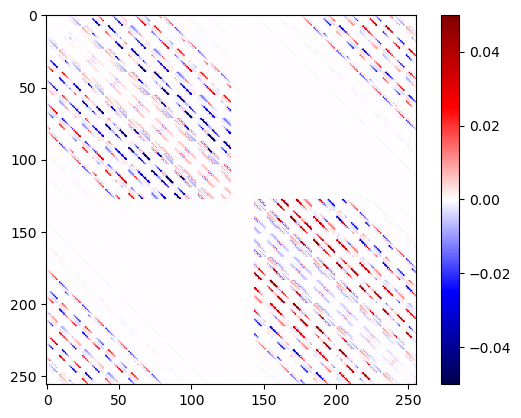

In [42]:
plt.imshow(test.imag, cmap='seismic', vmin=-.05, vmax=.05)
plt.colorbar()

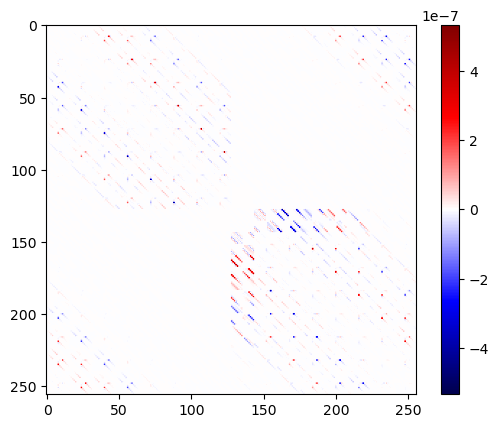

In [38]:
plt.imshow(R0.imag, cmap='seismic')#, vmin=-3e-5, vmax=3e-5)
plt.colorbar()

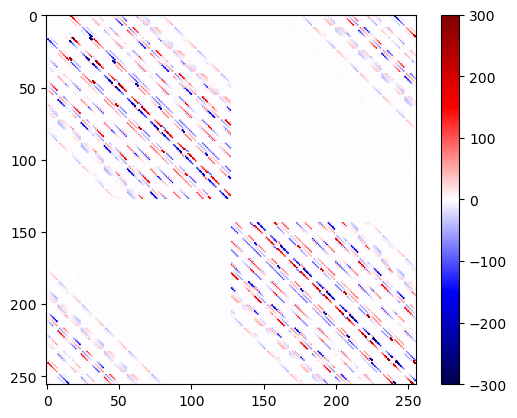

In [29]:
plt.imshow(A1.real, cmap='seismic', vmin=-300, vmax=300)
plt.colorbar()

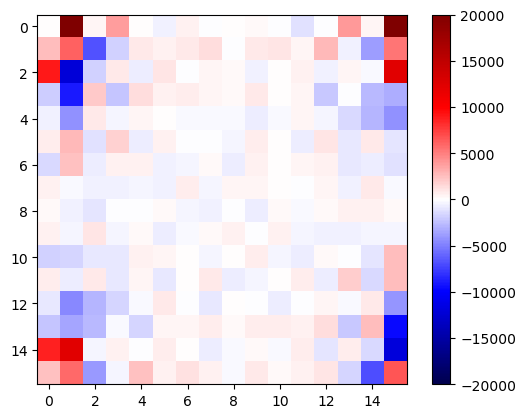

In [99]:
plt.imshow(inccc.real, cmap='seismic', vmin=-20000, vmax=20000)
plt.colorbar()

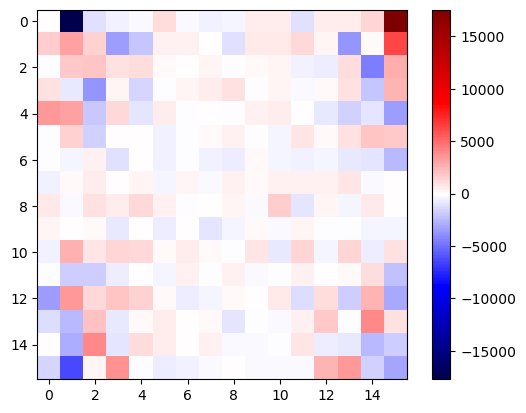

In [90]:
plt.imshow(inccc.imag, cmap='seismic')#, vmin=-10000, vmax=10000)
plt.colorbar()

In [80]:
def verify_conjugate_symmetry_(Y, atol=10, rtol=1e-5):
    """
    Checks if the matrix Y is conjugate symmetric based on the given conditions.
    
    Parameters:
    - Y: np.ndarray, a numpy array representing the matrix.
    
    Returns:
    - bool, True if the matrix Y is conjugate symmetric, False otherwise.
    """
    # Condition 1: Check if Y[0, 1:] is conjugate symmetric
    condition1 = np.allclose(Y[0, 1:], np.conj(Y[0, -1:0:-1]), atol=atol, rtol=rtol)
    
    # Condition 2: Check if Y[1:, 0] is conjugate symmetric
    condition2 = np.allclose(Y[1:, 0], np.conj(Y[-1:0:-1, 0]), atol=atol, rtol=rtol)
    
    # Condition 3: Check if Y[1:, 1:] is conjugate centrosymmetric
    condition3 = np.allclose(Y[1:, 1:], np.conj(Y[-1:0:-1, -1:0:-1]), atol=atol, rtol=rtol)
    
    # Return True if all conditions are met, False otherwise
    return condition1 and condition2 and condition3

verify_conjugate_symmetry_(inccc,atol=1000, rtol=1e-1)

False

In [82]:
def find_non_conjugate_pairs_(Y, atol=1, rtol=1e-3):
    """
    Identifies pairs of entries that are not complex conjugate if the matrix Y does not pass the verification.
    
    Parameters:
    - Y: np.ndarray, a numpy array representing the matrix.
    
    Returns:
    - list of tuple, pairs of indices that are not complex conjugate.
    """
    non_conjugate_pairs = []
    max_diff = 0
    
    # Check condition 1
    for i in range(1, Y.shape[1]):
        if not np.isclose(Y[0, i], np.conj(Y[0, -i]), atol=atol, rtol=rtol):
            non_conjugate_pairs.append(((0, i), (0, -i)))
            if (Y[0, i] - np.conj(Y[0, -i])).real / Y[0, i].real > max_diff:
                max_diff = (Y[0, i] - np.conj(Y[0, -i])).real / Y[0, i].real
                max_ind = ((0, i), (0, -i))
    
    # Check condition 2
    for i in range(1, Y.shape[0]):
        if not np.isclose(Y[i, 0], np.conj(Y[-i, 0]), atol=atol, rtol=rtol):
            non_conjugate_pairs.append(((i, 0), (-i, 0)))
            if (Y[0, i] - np.conj(Y[i, 0])).real / Y[-i, 0].real > max_diff:
                max_diff = (Y[i, 0] - np.conj(Y[-i, 0])).real / Y[i, 0].real
                max_ind = ((i, 0), (-i, 0))
    
    # Check condition 3
    for i in range(1, Y.shape[0]):
        for j in range(1, Y.shape[1]):
            if not np.isclose(Y[i, j], np.conj(Y[-i, -j]), atol=atol, rtol=rtol):
                non_conjugate_pairs.append(((i, j), (-i, -j)))
                if (Y[i, j] - np.conj(Y[-i, -j])).real / Y[i, j].real > max_diff:
                    max_diff = (Y[i, j] - np.conj(Y[-i, -j])).real / Y[i, j].real
                    max_ind = ((i, j), (-i, -j))
    
    return non_conjugate_pairs, max_diff, max_ind

find_non_conjugate_pairs_(inccc,atol=1000, rtol=1e-1)

([((8, 0), (-8, 0)),
  ((1, 8), (-1, -8)),
  ((6, 8), (-6, -8)),
  ((8, 2), (-8, -2)),
  ((8, 4), (-8, -4)),
  ((8, 6), (-8, -6)),
  ((8, 10), (-8, -10)),
  ((8, 12), (-8, -12)),
  ((8, 14), (-8, -14)),
  ((10, 8), (-10, -8)),
  ((10, 10), (-10, -10)),
  ((15, 8), (-15, -8))],
 8.176224987716827,
 ((10, 8), (-10, -8)))

In [84]:
print(inccc[8,0], inccc[-8,0])

(190.95751561554874+743.169959150675j) (190.95751561554874+743.169959150675j)


In [85]:
print(inccc[1,1], inccc[-1,-1])

(6225.689131779889+3139.9308726107342j) (6615.102644912391-3167.508110460692j)


In [86]:
print(inccc[10,8], inccc[-10,-8])

(106.95884535775974-163.45801087606208j) (-767.5607387136954-764.5319125438389j)


compare the scale

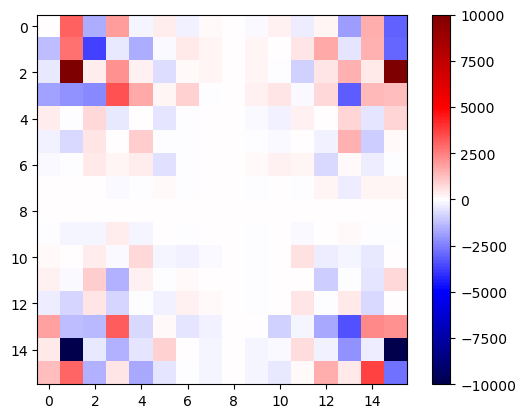

In [89]:
inc1 = (a0 + a1 @ mu0)
inc1 = inc1.reshape((K,K), order='F')
plt.imshow(inc1.imag, cmap='seismic', vmin=-10000, vmax=10000)
plt.colorbar()

enforce the innovation to be conjugate symmetric

In [74]:
def find_non_conjugate_pairs_(Y, atol=1e-8, rtol=1e-3):
    """
    Identifies pairs of entries that are not complex conjugate if the matrix Y does not pass the verification.
    
    Parameters:
    - Y: np.ndarray, a numpy array representing the matrix.
    
    Returns:
    - list of tuple, pairs of indices that are not complex conjugate.
    """
    non_conjugate_pairs = []
    max_diff = 0
    
    # Check condition 1
    for i in range(1, Y.shape[1]):
        if not np.isclose(Y[0, i], np.conj(Y[0, -i]), atol=atol, rtol=rtol):
            non_conjugate_pairs.append(((0, i), (0, -i)))
            if (Y[0, i] - np.conj(Y[0, -i])).real / Y[0, i].real > max_diff:
                max_diff = (Y[0, i] - np.conj(Y[0, -i])).real / Y[0, i].real
                max_ind = ((0, i), (0, -i))
    
    # Check condition 2
    for i in range(1, Y.shape[0]):
        if not np.isclose(Y[i, 0], np.conj(Y[-i, 0]), atol=atol, rtol=rtol):
            non_conjugate_pairs.append(((i, 0), (-i, 0)))
            if (Y[0, i] - np.conj(Y[i, 0])).real / Y[-i, 0].real > max_diff:
                max_diff = (Y[i, 0] - np.conj(Y[-i, 0])).real / Y[i, 0].real
                max_ind = ((i, 0), (-i, 0))
    
    # Check condition 3
    for i in range(1, Y.shape[0]):
        for j in range(1, Y.shape[1]):
            if not np.isclose(Y[i, j], np.conj(Y[-i, -j]), atol=atol, rtol=rtol):
                non_conjugate_pairs.append(((i, j), (-i, -j)))
                if (Y[i, j] - np.conj(Y[-i, -j])).real / Y[i, j].real > max_diff:
                    max_diff = (Y[i, j] - np.conj(Y[-i, -j])).real / Y[i, j].real
                    max_ind = ((i, j), (-i, -j))
    
    return non_conjugate_pairs, max_diff, max_ind

def verify_conjugate_symmetry_(Y, atol=1e-8, rtol=1e-5):
    """
    Checks if the matrix Y is conjugate symmetric based on the given conditions.
    
    Parameters:
    - Y: np.ndarray, a numpy array representing the matrix.
    
    Returns:
    - bool, True if the matrix Y is conjugate symmetric, False otherwise.
    """
    # Condition 1: Check if Y[0, 1:] is conjugate symmetric
    condition1 = np.allclose(Y[0, 1:], np.conj(Y[0, -1:0:-1]), atol=atol, rtol=rtol)
    
    # Condition 2: Check if Y[1:, 0] is conjugate symmetric
    condition2 = np.allclose(Y[1:, 0], np.conj(Y[-1:0:-1, 0]), atol=atol, rtol=rtol)
    
    # Condition 3: Check if Y[1:, 1:] is conjugate centrosymmetric
    condition3 = np.allclose(Y[1:, 1:], np.conj(Y[-1:0:-1, -1:0:-1]), atol=atol, rtol=rtol)
    
    # Return True if all conditions are met, False otherwise
    return condition1 and condition2 and condition3

In [97]:
inccc =(R0 @ A1.conj().T) * InvBoB @ (psi1_diff - (A0 + A1 @ mu0) * dt)
inccc = inccc.reshape((K,K), order='F')
verify_conjugate_symmetry(inccc)

False

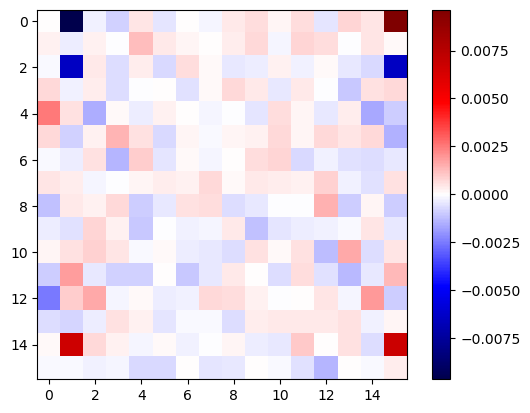

In [98]:
plt.imshow(inccc.imag, cmap='seismic')#, vmin=-10000, vmax=10000)
plt.colorbar()

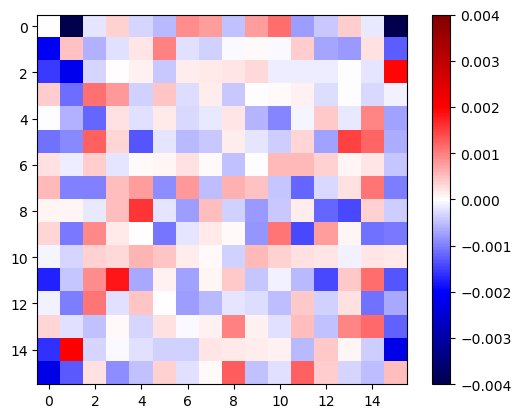

In [99]:
plt.imshow(inccc.real, cmap='seismic', vmin=-0.004, vmax=0.004)
plt.colorbar()

In [88]:
inccc[K//2, :] = 0
inccc[:, K//2] = 0
verify_conjugate_symmetry(inccc)
verify_conjugate_symmetry_(inccc,atol=1e-3, rtol=1e-2)

True

In [94]:
verify_conjugate_symmetry_(inccc, atol=1e-4, rtol=1e-3)

False

In [95]:
find_non_conjugate_pairs_(inccc,atol=5*1e-4, rtol=1e-3)

([((5, 0), (-5, 0)),
  ((11, 0), (-11, 0)),
  ((3, 10), (-3, -10)),
  ((5, 1), (-5, -1)),
  ((5, 6), (-5, -6)),
  ((5, 13), (-5, -13)),
  ((6, 7), (-6, -7)),
  ((6, 10), (-6, -10)),
  ((6, 11), (-6, -11)),
  ((7, 5), (-7, -5)),
  ((7, 7), (-7, -7)),
  ((9, 9), (-9, -9)),
  ((9, 11), (-9, -11)),
  ((10, 5), (-10, -5)),
  ((10, 6), (-10, -6)),
  ((10, 9), (-10, -9)),
  ((11, 3), (-11, -3)),
  ((11, 10), (-11, -10)),
  ((11, 15), (-11, -15)),
  ((13, 6), (-13, -6))],
 2.4084376873621087,
 ((13, 6), (-13, -6)))

In [51]:
inccc =(R0 @ A1.conj().T) * InvBoB @ (psi1_diff - (A0 + A1 @ mu0) * dt)
inccc = inccc.reshape((K,K), order='F')
inccc[K//2, :] = 0
inccc[:, K//2] = 0
inccc = inccc.flatten(order='F')
inccc.shape

(256,)

In [158]:
inccc.shape

(16, 16)

check A* is conjugate symmetric

In [174]:
A_H = A1.conj().T

In [238]:
ii,ij = 2, 3
print(A_H[ii+16, ij+16], A_H[-ii, -ij])

(1.8486072714858284+0.4829556759000774j) (1.8486072714858284-0.4829556759000774j)


In [185]:
ii,ij = 2, 3
print(A_H[ii+16, ij+16], A_H[-ij, -ii])

(2.0693849346999507+0.4315402740618614j) (-2.1679270744475807-0.45208981092195005j)


In [182]:
ii,ij = 1, 1
print(A_H[ii+16, ij+16], A_H[-ij, -ii])

(-4.411764705882353-15.686274509803924j) (-4.411764705882353+15.686274509803924j)


In [229]:
ii,ij = 2, 2
print(A_H[ii+16, ij+16], A_H[-ij, -ii])

(-4.285714285714286-6.666666666666668j) (-4.285714285714286+6.666666666666668j)


In [234]:
for ik_, (k, ik) in enumerate(k_index_map.items()):
    print(ik_, k, ik)

0 (0.0, 0.0) (0, 0)
1 (0.0, 1.0) (0, 1)
2 (0.0, 2.0) (0, 2)
3 (0.0, 3.0) (0, 3)
4 (0.0, 4.0) (0, 4)
5 (0.0, 5.0) (0, 5)
6 (0.0, 6.0) (0, 6)
7 (0.0, 7.0) (0, 7)
8 (0.0, -8.0) (0, 8)
9 (0.0, -7.0) (0, 9)
10 (0.0, -6.0) (0, 10)
11 (0.0, -5.0) (0, 11)
12 (0.0, -4.0) (0, 12)
13 (0.0, -3.0) (0, 13)
14 (0.0, -2.0) (0, 14)
15 (0.0, -1.0) (0, 15)
16 (1.0, 0.0) (1, 0)
17 (1.0, 1.0) (1, 1)
18 (1.0, 2.0) (1, 2)
19 (1.0, 3.0) (1, 3)
20 (1.0, 4.0) (1, 4)
21 (1.0, 5.0) (1, 5)
22 (1.0, 6.0) (1, 6)
23 (1.0, 7.0) (1, 7)
24 (1.0, -8.0) (1, 8)
25 (1.0, -7.0) (1, 9)
26 (1.0, -6.0) (1, 10)
27 (1.0, -5.0) (1, 11)
28 (1.0, -4.0) (1, 12)
29 (1.0, -3.0) (1, 13)
30 (1.0, -2.0) (1, 14)
31 (1.0, -1.0) (1, 15)
32 (2.0, 0.0) (2, 0)
33 (2.0, 1.0) (2, 1)
34 (2.0, 2.0) (2, 2)
35 (2.0, 3.0) (2, 3)
36 (2.0, 4.0) (2, 4)
37 (2.0, 5.0) (2, 5)
38 (2.0, 6.0) (2, 6)
39 (2.0, 7.0) (2, 7)
40 (2.0, -8.0) (2, 8)
41 (2.0, -7.0) (2, 9)
42 (2.0, -6.0) (2, 10)
43 (2.0, -5.0) (2, 11)
44 (2.0, -4.0) (2, 12)
45 (2.0, -3.0) (2, 13)
46 (2.

A* is not conjugate symmetric

check if A1*I is conjugate symmetric

In [240]:
inccc =(A1.conj().T) * InvBoB @ (psi1_diff - (A0 + A1 @ mu0) * dt)
inccc = inccc.reshape((K,K), order='F')
verify_conjugate_symmetry(inccc)

False

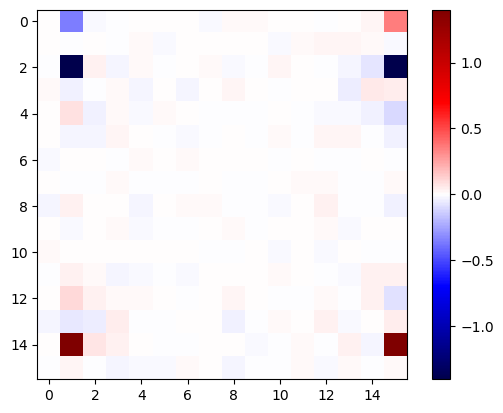

In [241]:
plt.imshow(inccc.imag, cmap='seismic')#, vmin=-10000, vmax=10000)
plt.colorbar()

In [243]:
find_non_conjugate_pairs_(inccc,atol=2*1e-2, rtol=1e-1)

([((0, 8), (0, -8)),
  ((8, 0), (-8, 0)),
  ((1, 8), (-1, -8)),
  ((3, 8), (-3, -8)),
  ((4, 8), (-4, -8)),
  ((8, 2), (-8, -2)),
  ((8, 3), (-8, -3)),
  ((8, 4), (-8, -4)),
  ((8, 12), (-8, -12)),
  ((8, 13), (-8, -13)),
  ((8, 14), (-8, -14)),
  ((12, 8), (-12, -8)),
  ((13, 8), (-13, -8)),
  ((15, 8), (-15, -8))],
 4.086605878553809,
 ((3, 8), (-3, -8)))

In [169]:
print(inccc[13,7], inccc[-13,-7])

(0.00046367858231131595+0.005137902990973832j) (-0.008367201982089753+0.0016425786602344554j)


In [171]:
print(inccc[0,1], inccc[0,-1])

(-0.1597489702966559-0.3548280592822212j) (-0.16411073947013502+0.35706284878724837j)


In [172]:
print(inccc[2,1], inccc[-2,-1])

(-0.4335977786685059-1.401116096870385j) (-0.4371229024278137+1.401742920782805j)


check if R0 is conjugate symmetric

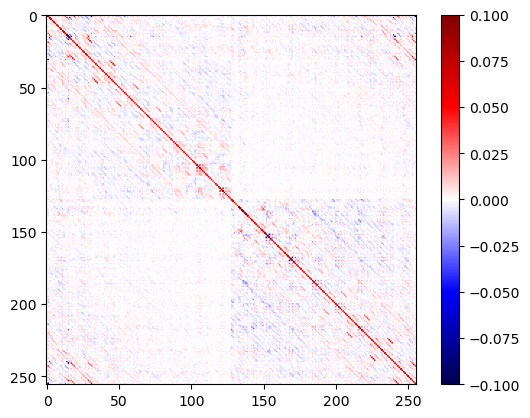

In [109]:
plt.imshow(R0.real, cmap='seismic', vmin=-0.1, vmax=0.1)
plt.colorbar()

In [120]:
k_index_map = {(KX[iy, ix], KY[iy, ix]): (ix, iy) for ix in range(K) for iy in range(K)}
k_ = list(k_index_map.keys())

In [130]:
print(k_[12+16], k_[-12])

(1.0, -4.0) (-1.0, 4.0)


In [131]:
print(k_[129+16], k_[-129])

(-7.0, 1.0) (7.0, -1.0)


In [156]:
ii,ij = 12, 19
print(R0[ii+16, ij+16], R0[-ij, -ii])

(0.0015487129987013107+0.001472692467241769j) (0.003067680481527943-0.00013950027483971387j)


In [157]:
ii,ij = 1, 1
print(R0[ii+16, ij+16], R0[-ij, -ii])

(0.07363022014687208-7.672664247603872e-17j) (0.07291673173145169+1.4256075755680695e-17j)


In [237]:
ii,ij = 1, 2
print(R0[ii+16, ij+16], R0[-ij, -ii])

(0.0017111505253275675+0.006498156610222863j) (-0.0011154001354269124+0.008159515504538669j)


R0 does not satisfy conjugate symmetry

In [151]:
ii,ij = 21, 12
print(R0[ii, ij], R0[ij, ii])

(-0.0014524357713712659-0.002798490456722248j) (-0.0014524357713712284+0.0027984904567221955j)


R0 is Hermitian

In [139]:
verify_conjugate_symmetry(R0)

False

### 2.2.4 DA results

try the $\hat{\psi}_2$ model only

In [ ]:
def get_coef_mat(KX, KY, K_squared, kd, beta, kappa, U, psi1_hat, psi2_hat, h_hat):
    K = KX.shape[0]
    
    # psi_hat, hk should be of shape (N, K, K), if not, reshape them to make it legible
    if psi1_hat.shape[-2:] != KX.shape:
        psi1_hat = np.transpose(psi1_hat, axes=(2,0,1))
    if psi2_hat.shape[-2:] != KX.shape:
        psi2_hat = np.transpose(psi2_hat, axes=(2,0,1))
    if h_hat.shape[-2:] != KX.shape:
        h_hat = np.transpose(h_hat, axes=(2,0,1))

#     # make sure \partial psi1_k / \partial x be conjugate symmetric
#     psi1_hat[:, :, K//2] = 0
#     psi2_hat[:, :, K//2] = 0

    # define Ck for each wave number
    Ck = 1 / (K_squared * (K_squared + kd**2))
    Ck[K_squared == 0] = 0  # avoid division by zero at k = 0, constant mode

    # linear part for A0, a0, A1 and a1
    linear_A0 = 1j * KX * (((K_squared + kd**2/2)*beta - K_squared**2 * U)*psi1_hat - kd**2/2 * U * h_hat)
    linear_a0 = 1j * KX * ((kd**2/2 * beta - kd**2 * K_squared * U)*psi1_hat - (K_squared + kd**2/2) * U * h_hat)
    linear_A1_diag = 1j * KX * (kd**2/2 * beta + kd**2 * K_squared * U) - (kd**2/2 * kappa * K_squared)
    linear_a1_diag = 1j * KX * ((K_squared + kd**2/2)*beta + K_squared**2 * U) - (K_squared + kd**2/2) * kappa * K_squared
    linear_A1 = np.tile(np.diag(linear_A1_diag.flatten(order='F'))[None,:,:], (psi1_hat.shape[0],1,1)) 
    linear_a1 = np.tile(np.diag(linear_a1_diag.flatten(order='F'))[None,:,:], (psi1_hat.shape[0],1,1)) 
    
    # nonlinear summation part for A0, a0, A1 and a1
    nonlinear_sum_A0 = np.zeros_like(psi1_hat, dtype=complex)
    nonlinear_sum_a0 = np.zeros_like(psi1_hat, dtype=complex)
    nonlinear_sum_A1 = np.zeros_like(linear_A1, dtype=complex)
    nonlinear_sum_a1 = np.zeros_like(linear_a1, dtype=complex)
    k_index_map = {(KX[iy, ix], KY[iy, ix]): (ix, iy) for ix in range(K) for iy in range(K)}
    
    for ik_, (k, ik) in enumerate(k_index_map.items()):
        ikx, iky = ik
        kx, ky = k
        k_mod = K_squared[iky, ikx]
        for im_, (m, im) in enumerate(k_index_map.items()):
            mx, my = m
            n = (kx-mx, ky-my)
            if n in k_index_map:
                inx, iny = k_index_map[n]
                psi1_n = psi1_hat[:, iny, inx]
                psi2_n = psi2_hat[:, iny, inx]
                h_n = h_hat[iny, inx]
                det_mn = np.linalg.det(np.array([m, n]))
                nonlinear_sum_A1[:, ik_, im_] += det_mn * kd**2 / 2 * (k_mod * psi1_n - h_n)
                nonlinear_sum_a1[:, ik_, im_] -= det_mn * (k_mod * kd**2 / 2 * psi1_n - (k_mod + kd**2 / 2) * h_n) 
        
    # aggregate 
    A0 = linear_A0 + nonlinear_sum_A0
    a0 = linear_a0 + nonlinear_sum_a0
    A1 = linear_A1 + nonlinear_sum_A1
    a1 = linear_a1 + nonlinear_sum_a1
    
    # enforce conjugate symmetry
    A1[:, 8::K, :] = 0
    A1[:, 8*K:9*K, :] = 0
    a1[:, 8::K, :] = 0
    a1[:, 8*K:9*K, :] = 0
    
    # normalization 
    Ck_ = np.tile(Ck.flatten(order='F')[None,:,None], (psi1_hat.shape[0],1,K**2))
    A0 = Ck * A0
    a0 = Ck * a0
    A1 = Ck_ * A1
    a1 = Ck_ * a1
    
    # flatten
    A0 = A0.reshape((A0.shape[0], -1), order='F')
    a0 = a0.reshape((a0.shape[0], -1), order='F')
    
    return A0, a0, A1, a1

N = 4000
kx = np.fft.fftfreq(K) * K
ky = np.fft.fftfreq(K) * K
KX, KY = np.meshgrid(kx, ky)
K_squared = KX**2 + KY**2

# prepare coefficient matrices used in DA
A0_t, a0_t, A1_t, a1_t = get_coef_mat(KX, KY, K_squared, kd, beta, kappa, U, psi1_k_t[:,:,:N], psi2_k_t[:,:,:N], h_hat)
# InvBoB = 1 / sigma_1**2
# InvBoB = truncated_InvBoB.flatten(order='F')
InvBoB = 1 / 4.**2

# initialized mean and variance
mu0 = psi2_k_t[:,:,0].flatten(order='F') # assume the initial condition is truth
K_ = mu0.shape[0] # flattened K*K
R0 = np.zeros((K_, K_), dtype='complex')
mu_t = np.zeros((K_, N), dtype='complex')  # posterior mean
mu_t[:, 0] = mu0
R_t = np.zeros((K_, N), dtype='complex')  # posterior covariance
R_t[:, 0] = np.diag(R0)  # only save the diagonal elements

# enforce conjugate symmetry
psi1_k_t[:,K//2,:] = 0
psi2_k_t[:,K//2,:] = 0
psi1_k_t[K//2,:,:] = 0
psi2_k_t[K//2,:,:] = 0

# Lagrangian DA
for i in range(1, N):
    A0 = A0_t[i-1, :]
    a0 = a0_t[i-1, :]
    A1 = A1_t[i-1, :, :]
    a1 = a1_t[i-1, :, :]
    psi1_diff = psi1_k_t[:, :, i] - psi1_k_t[:, :, i - 1]
    psi1_diff = psi1_diff.flatten(order='F')

    # Update the posterior mean and posterior covariance
    mu = mu0 + (a0 + a1 @ mu0) * dt #+ (R0 @ A1.conj().T) * InvBoB @ (psi1_diff - (A0 + A1 @ mu0) * dt)
#     R = R0 + (a1 @ R0 + R0 @ a1.conj().T + np.diag(sigma_2**2) - (R0 @ A1.conj().T) * InvBoB @ A1 @ R0.conj().T) * dt
    mu_t[:, i] = mu
#     R_t[:, i] = np.diag(R)
    mu0 = psi2_k_t[:,:,i].flatten(order='F')
#     R0 = R

/var/folders/lz/50081q0n24g8lq6ncqpbp8780000gn/T/ipykernel_53530/2659448182.py:17: RuntimeWarning: divide by zero encountered in divide
  Ck = 1 / (K_squared * (K_squared + kd**2))


In [109]:
# reshape flattened variables to two modes matrices
mu_t = mu_t.reshape((K,K,-1), order='F')
mu_t.shape

(16, 16, 500)

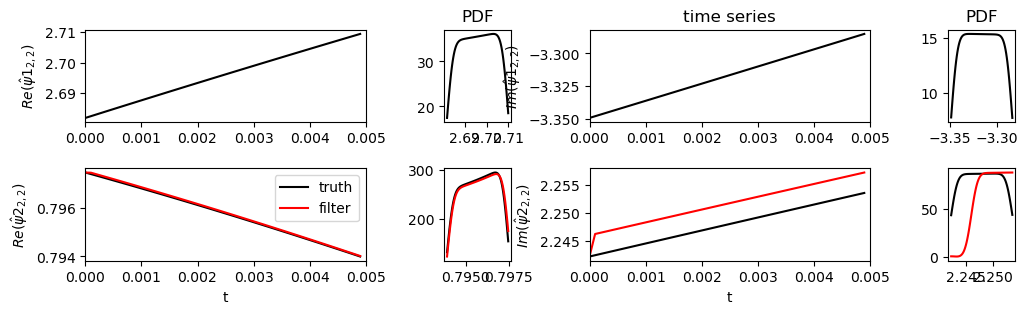

In [113]:
# Plot
sel0 = 0; sel1 = N # plot time range
ikx = 2; iky = 2 # mode to plot
interv = 10 # plot interval
xaxis = np.arange(sel0*dt, sel1*dt, interv*dt)

fig = plt.figure(figsize=(12,3))
widths = [5, 1.2, 5, 1.2]
heights = [1, 1]
spec = fig.add_gridspec(ncols=4, nrows=2, width_ratios=widths, height_ratios=heights)

plt.subplots_adjust(wspace=0.45, hspace=0.5)     # Adjust the overall spacing of the figure
ax1 = fig.add_subplot(spec[0, 0])
ax2 = fig.add_subplot(spec[1, 0])
ax3 = fig.add_subplot(spec[0, 1])
ax4 = fig.add_subplot(spec[1, 1])
ax11 = fig.add_subplot(spec[0, 2])
ax22 = fig.add_subplot(spec[1, 2])
ax33 = fig.add_subplot(spec[0, 3])
ax44 = fig.add_subplot(spec[1, 3])

# plot time series
ax1.plot(xaxis, psi1_k_t[iky,ikx,sel0:sel1:interv].real, 'k')
ax1.set_xlim(sel0*dt, sel1*dt)
ax1.set_ylabel('$Re(\hat{{\psi}}1_{{{:d},{:d}}})$'.format(ikx, iky))

ax2.plot(xaxis, psi2_k_t[iky,ikx,sel0:sel1:interv].real, 'k', label='truth')
ax2.plot(xaxis, mu_t[iky,ikx,sel0:sel1:interv].real, 'r', label='filter')
ax2.set_xlim(sel0*dt, sel1*dt)
ax2.set_ylabel(r'$Re(\hat{{\psi}}2_{{{:d},{:d}}})$'.format(ikx, iky))
ax2.set_xlabel('t')
ax2.legend()
# ax2.set_xlim(0,0.01)
# ax2.set_ylim(-2.58,-2.56)

# plot pdf
samples = psi1_k_t[iky, ikx, :N].real
kde = gaussian_kde(samples)
xticks = np.linspace(samples.min(), samples.max(), 100)
p = kde.evaluate(xticks)
ax3.plot(xticks, p, 'k')
ax3.set_title('PDF')

samples = psi2_k_t[iky, ikx, :N].real
kde = gaussian_kde(samples)
xticks = np.linspace(samples.min(), samples.max(), 100)
p = kde.evaluate(xticks)
ax4.plot(xticks, p, 'k', label='truth')
samples = mu_t[iky, ikx, :].real
kde = gaussian_kde(samples)
p = kde.evaluate(xticks)
ax4.plot(xticks, p, 'r', label='filter')

ax11.plot(xaxis, psi1_k_t[iky,ikx,sel0:sel1:interv].imag, 'k')
ax11.set_xlim(sel0*dt, sel1*dt)
ax11.set_ylabel('$Im(\hat{{\psi}}1_{{{:d},{:d}}})$'.format(ikx, iky))
ax11.set_title('time series')

ax22.plot(xaxis, psi2_k_t[iky,ikx,sel0:sel1:interv].imag, 'k', label='truth')
ax22.plot(xaxis, mu_t[iky,ikx,sel0:sel1:interv].imag, 'r', label='filter')
ax22.set_xlim(sel0*dt, sel1*dt)
ax22.set_ylabel(r'$Im(\hat{{\psi}}2_{{{:d},{:d}}})$'.format(ikx, iky))
ax22.set_xlabel('t')

# plot pdf
samples = psi1_k_t[iky, ikx, :N].imag
kde = gaussian_kde(samples)
xticks = np.linspace(samples.min(), samples.max(), 100)
p = kde.evaluate(xticks)
ax33.plot(xticks, p, 'k')
ax33.set_title('PDF')

samples = psi2_k_t[iky, ikx, :N].imag
kde = gaussian_kde(samples)
xticks = np.linspace(samples.min(), samples.max(), 100)
p = kde.evaluate(xticks)
ax44.plot(xticks, p, 'k', label='truth')
samples = mu_t[iky, ikx, :].imag
kde = gaussian_kde(samples)
p = kde.evaluate(xticks)
ax44.plot(xticks, p, 'r', label='filter')
# plt.savefig('./Lagrangian_DA/LagDA_K16_CG_tr.png',dpi=100)
plt.show()

It might be hard to check whether this bias is from we negelected some modes in the Jacobian. Let's leave it aside and directly go to DA results.

In [224]:
def get_coef_mat(KX, KY, K_squared, kd, beta, kappa, U, psi1_hat, psi2_hat, h_hat):
    K = KX.shape[0]
    
    # psi_hat, hk should be of shape (N, K, K), if not, reshape them to make it legible
    if psi1_hat.shape[-2:] != KX.shape:
        psi1_hat = np.transpose(psi1_hat, axes=(2,0,1))
    if psi2_hat.shape[-2:] != KX.shape:
        psi2_hat = np.transpose(psi2_hat, axes=(2,0,1))
    if h_hat.shape[-2:] != KX.shape:
        h_hat = np.transpose(h_hat, axes=(2,0,1))

#     # make sure \partial psi1_k / \partial x be conjugate symmetric
#     psi1_hat[:, :, K//2] = 0
#     psi2_hat[:, :, K//2] = 0

    # define Ck for each wave number
    Ck = 1 / (K_squared * (K_squared + kd**2))
    Ck[K_squared == 0] = 0  # avoid division by zero at k = 0, constant mode

    # linear part for A0, a0, A1 and a1
    linear_A0 = 1j * KX * (((K_squared + kd**2/2)*beta - K_squared**2 * U)*psi1_hat - kd**2/2 * U * h_hat)
    linear_a0 = 1j * KX * ((kd**2/2 * beta - kd**2 * K_squared * U)*psi1_hat - (K_squared + kd**2/2) * U * h_hat)
    linear_A1_diag = 1j * KX * (kd**2/2 * beta + kd**2 * K_squared * U) - (kd**2/2 * kappa * K_squared)
    linear_a1_diag = 1j * KX * ((K_squared + kd**2/2)*beta + K_squared**2 * U) - (K_squared + kd**2/2) * kappa * K_squared
    linear_A1 = np.tile(np.diag(linear_A1_diag.flatten(order='F'))[None,:,:], (psi1_hat.shape[0],1,1)) 
    linear_a1 = np.tile(np.diag(linear_a1_diag.flatten(order='F'))[None,:,:], (psi1_hat.shape[0],1,1)) 
    
    # nonlinear summation part for A0, a0, A1 and a1
    nonlinear_sum_A0 = np.zeros_like(psi1_hat, dtype=complex)
    nonlinear_sum_a0 = np.zeros_like(psi1_hat, dtype=complex)
    nonlinear_sum_A1 = np.zeros_like(linear_A1, dtype=complex)
    nonlinear_sum_a1 = np.zeros_like(linear_a1, dtype=complex)
    k_index_map = {(KX[iy, ix], KY[iy, ix]): (ix, iy) for ix in range(K) for iy in range(K)}
    
    for ik_, (k, ik) in enumerate(k_index_map.items()):
        ikx, iky = ik
        kx, ky = k
        k_mod = K_squared[iky, ikx]
        for im_, (m, im) in enumerate(k_index_map.items()):
            mx, my = m
            n = (kx-mx, ky-my)
            if n in k_index_map:
                inx, iny = k_index_map[n]
                psi1_n = psi1_hat[:, iny, inx]
                psi2_n = psi2_hat[:, iny, inx]
                h_n = h_hat[iny, inx]
                det_mn = np.linalg.det(np.array([m, n]))
                nonlinear_sum_A1[:, ik_, im_] += det_mn * kd**2 / 2 * (k_mod * psi1_n - h_n)
                nonlinear_sum_a1[:, ik_, im_] -= det_mn * (k_mod * kd**2 / 2 * psi1_n - (k_mod + kd**2 / 2) * h_n) 
        
    # aggregate 
    A0 = linear_A0 + nonlinear_sum_A0
    a0 = linear_a0 + nonlinear_sum_a0
    A1 = linear_A1 + nonlinear_sum_A1
    a1 = linear_a1 + nonlinear_sum_a1
    
    # enforce conjugate symmetry
    A1[:, 8::K, :] = 0
    A1[:, 8*K:9*K, :] = 0
    a1[:, 8::K, :] = 0
    a1[:, 8*K:9*K, :] = 0
    
    # normalization 
    Ck_ = np.tile(Ck.flatten(order='F')[None,:,None], (psi1_hat.shape[0],1,K**2))
    A0 = Ck * A0
    a0 = Ck * a0
    A1 = Ck_ * A1
    a1 = Ck_ * a1
    
    # flatten
    A0 = A0.reshape((A0.shape[0], -1), order='F')
    a0 = a0.reshape((a0.shape[0], -1), order='F')
    
    return A0, a0, A1, a1

N = 4000
kx = np.fft.fftfreq(K) * K
ky = np.fft.fftfreq(K) * K
KX, KY = np.meshgrid(kx, ky)
K_squared = KX**2 + KY**2

# prepare coefficient matrices used in DA
A0_t, a0_t, A1_t, a1_t = get_coef_mat(KX, KY, K_squared, kd, beta, kappa, U, psi1_k_t[:,:,:N], psi2_k_t[:,:,:N], h_hat)
# InvBoB = 1 / sigma_1**2
# InvBoB = truncated_InvBoB.flatten(order='F')
InvBoB = 1 / 4.**2

# initialized mean and variance
mu0 = psi2_k_t[:,:,0].flatten(order='F') # assume the initial condition is truth
K_ = mu0.shape[0] # flattened K*K
R0 = np.zeros((K_, K_), dtype='complex')
mu_t = np.zeros((K_, N), dtype='complex')  # posterior mean
mu_t[:, 0] = mu0
R_t = np.zeros((K_, N), dtype='complex')  # posterior covariance
R_t[:, 0] = np.diag(R0)  # only save the diagonal elements

# enforce conjugate symmetry
psi1_k_t[:,K//2,:] = 0
psi2_k_t[:,K//2,:] = 0
psi1_k_t[K//2,:,:] = 0
psi2_k_t[K//2,:,:] = 0

# Lagrangian DA
for i in range(1, N):
    A0 = A0_t[i-1, :]
    a0 = a0_t[i-1, :]
    A1 = A1_t[i-1, :, :]
    a1 = a1_t[i-1, :, :]
    psi1_diff = psi1_k_t[:, :, i] - psi1_k_t[:, :, i - 1]
    psi1_diff = psi1_diff.flatten(order='F')

    # Update the posterior mean and posterior covariance
    # enforcing last even mode to be zero
    inc =(R0 @ A1.conj().T) * InvBoB @ (psi1_diff - (A0 + A1 @ mu0) * dt)
    inc = inc.reshape((K,K), order='F')
    inc[K//2, :] = 0
    inc[:, K//2] = 0
    inc = inc.flatten(order='F')
    mu = mu0 + (a0 + a1 @ mu0) * dt + inc
#     mu = mu0 + (a0 + a1 @ mu0) * dt + (R0 @ A1.conj().T) * InvBoB @ (psi1_diff - (A0 + A1 @ mu0) * dt)
    R = R0 + (a1 @ R0 + R0 @ a1.conj().T + np.diag(sigma_2**2) - (R0 @ A1.conj().T) * InvBoB @ A1 @ R0.conj().T) * dt
    mu_t[:, i] = mu
    R_t[:, i] = np.diag(R)
    mu0 = mu
    R0 = R

/var/folders/lz/50081q0n24g8lq6ncqpbp8780000gn/T/ipykernel_9620/1392860121.py:17: RuntimeWarning: divide by zero encountered in divide
  Ck = 1 / (K_squared * (K_squared + kd**2))


In [225]:
# reshape flattened variables to two modes matrices
mu_t = mu_t.reshape((K,K,-1), order='F')
mu_t.shape

(16, 16, 4000)

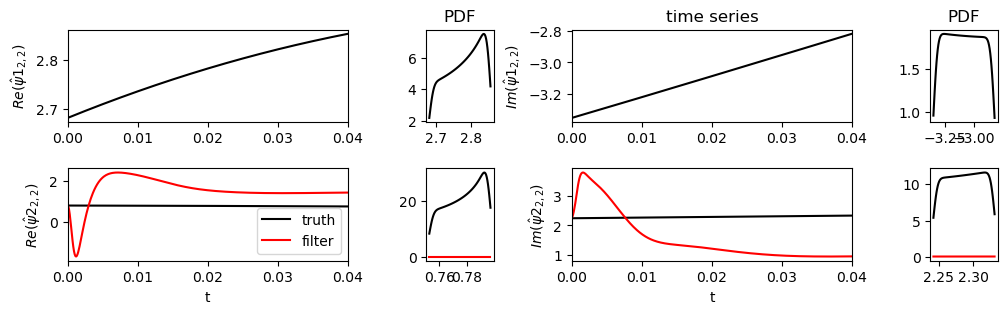

In [226]:
# Plot
sel0 = 0; sel1 = N # plot time range
ikx = 2; iky = 2 # mode to plot
interv = 10 # plot interval
xaxis = np.arange(sel0*dt, sel1*dt, interv*dt)

fig = plt.figure(figsize=(12,3))
widths = [5, 1.2, 5, 1.2]
heights = [1, 1]
spec = fig.add_gridspec(ncols=4, nrows=2, width_ratios=widths, height_ratios=heights)

plt.subplots_adjust(wspace=0.45, hspace=0.5)     # Adjust the overall spacing of the figure
ax1 = fig.add_subplot(spec[0, 0])
ax2 = fig.add_subplot(spec[1, 0])
ax3 = fig.add_subplot(spec[0, 1])
ax4 = fig.add_subplot(spec[1, 1])
ax11 = fig.add_subplot(spec[0, 2])
ax22 = fig.add_subplot(spec[1, 2])
ax33 = fig.add_subplot(spec[0, 3])
ax44 = fig.add_subplot(spec[1, 3])

# plot time series
ax1.plot(xaxis, psi1_k_t[iky,ikx,sel0:sel1:interv].real, 'k')
ax1.set_xlim(sel0*dt, sel1*dt)
ax1.set_ylabel('$Re(\hat{{\psi}}1_{{{:d},{:d}}})$'.format(ikx, iky))

ax2.plot(xaxis, psi2_k_t[iky,ikx,sel0:sel1:interv].real, 'k', label='truth')
ax2.plot(xaxis, mu_t[iky,ikx,sel0:sel1:interv].real, 'r', label='filter')
ax2.set_xlim(sel0*dt, sel1*dt)
ax2.set_ylabel(r'$Re(\hat{{\psi}}2_{{{:d},{:d}}})$'.format(ikx, iky))
ax2.set_xlabel('t')
ax2.legend()
# ax2.set_xlim(0,0.01)
# ax2.set_ylim(-2.58,-2.56)

# plot pdf
samples = psi1_k_t[iky, ikx, :N].real
kde = gaussian_kde(samples)
xticks = np.linspace(samples.min(), samples.max(), 100)
p = kde.evaluate(xticks)
ax3.plot(xticks, p, 'k')
ax3.set_title('PDF')

samples = psi2_k_t[iky, ikx, :N].real
kde = gaussian_kde(samples)
xticks = np.linspace(samples.min(), samples.max(), 100)
p = kde.evaluate(xticks)
ax4.plot(xticks, p, 'k', label='truth')
samples = mu_t[iky, ikx, :].real
kde = gaussian_kde(samples)
p = kde.evaluate(xticks)
ax4.plot(xticks, p, 'r', label='filter')

ax11.plot(xaxis, psi1_k_t[iky,ikx,sel0:sel1:interv].imag, 'k')
ax11.set_xlim(sel0*dt, sel1*dt)
ax11.set_ylabel('$Im(\hat{{\psi}}1_{{{:d},{:d}}})$'.format(ikx, iky))
ax11.set_title('time series')

ax22.plot(xaxis, psi2_k_t[iky,ikx,sel0:sel1:interv].imag, 'k', label='truth')
ax22.plot(xaxis, mu_t[iky,ikx,sel0:sel1:interv].imag, 'r', label='filter')
ax22.set_xlim(sel0*dt, sel1*dt)
ax22.set_ylabel(r'$Im(\hat{{\psi}}2_{{{:d},{:d}}})$'.format(ikx, iky))
ax22.set_xlabel('t')

# plot pdf
samples = psi1_k_t[iky, ikx, :N].imag
kde = gaussian_kde(samples)
xticks = np.linspace(samples.min(), samples.max(), 100)
p = kde.evaluate(xticks)
ax33.plot(xticks, p, 'k')
ax33.set_title('PDF')

samples = psi2_k_t[iky, ikx, :N].imag
kde = gaussian_kde(samples)
xticks = np.linspace(samples.min(), samples.max(), 100)
p = kde.evaluate(xticks)
ax44.plot(xticks, p, 'k', label='truth')
samples = mu_t[iky, ikx, :].imag
kde = gaussian_kde(samples)
p = kde.evaluate(xticks)
ax44.plot(xticks, p, 'r', label='filter')
# plt.savefig('./Lagrangian_DA/LagDA_K16_CG_tr.png',dpi=100)
plt.show()

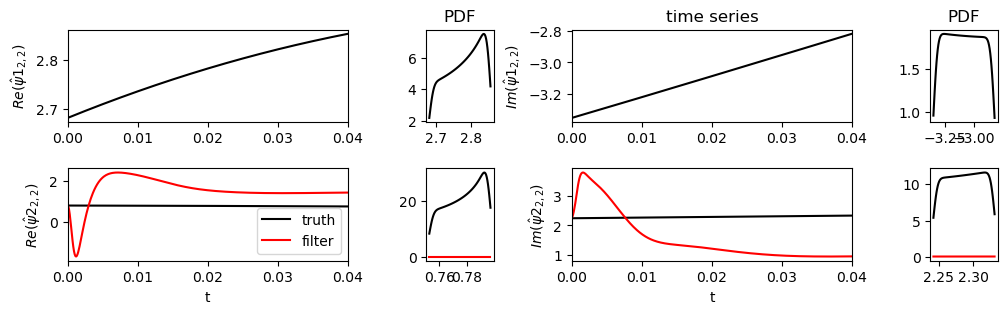

In [101]:
# Plot
sel0 = 0; sel1 = N # plot time range
ikx = 2; iky = 2 # mode to plot
interv = 10 # plot interval
xaxis = np.arange(sel0*dt, sel1*dt, interv*dt)

fig = plt.figure(figsize=(12,3))
widths = [5, 1.2, 5, 1.2]
heights = [1, 1]
spec = fig.add_gridspec(ncols=4, nrows=2, width_ratios=widths, height_ratios=heights)

plt.subplots_adjust(wspace=0.45, hspace=0.5)     # Adjust the overall spacing of the figure
ax1 = fig.add_subplot(spec[0, 0])
ax2 = fig.add_subplot(spec[1, 0])
ax3 = fig.add_subplot(spec[0, 1])
ax4 = fig.add_subplot(spec[1, 1])
ax11 = fig.add_subplot(spec[0, 2])
ax22 = fig.add_subplot(spec[1, 2])
ax33 = fig.add_subplot(spec[0, 3])
ax44 = fig.add_subplot(spec[1, 3])

# plot time series
ax1.plot(xaxis, psi1_k_t[iky,ikx,sel0:sel1:interv].real, 'k')
ax1.set_xlim(sel0*dt, sel1*dt)
ax1.set_ylabel('$Re(\hat{{\psi}}1_{{{:d},{:d}}})$'.format(ikx, iky))

ax2.plot(xaxis, psi2_k_t[iky,ikx,sel0:sel1:interv].real, 'k', label='truth')
ax2.plot(xaxis, mu_t[iky,ikx,sel0:sel1:interv].real, 'r', label='filter')
ax2.set_xlim(sel0*dt, sel1*dt)
ax2.set_ylabel(r'$Re(\hat{{\psi}}2_{{{:d},{:d}}})$'.format(ikx, iky))
ax2.set_xlabel('t')
ax2.legend()
# ax2.set_xlim(0,0.01)
# ax2.set_ylim(-2.58,-2.56)

# plot pdf
samples = psi1_k_t[iky, ikx, :N].real
kde = gaussian_kde(samples)
xticks = np.linspace(samples.min(), samples.max(), 100)
p = kde.evaluate(xticks)
ax3.plot(xticks, p, 'k')
ax3.set_title('PDF')

samples = psi2_k_t[iky, ikx, :N].real
kde = gaussian_kde(samples)
xticks = np.linspace(samples.min(), samples.max(), 100)
p = kde.evaluate(xticks)
ax4.plot(xticks, p, 'k', label='truth')
samples = mu_t[iky, ikx, :].real
kde = gaussian_kde(samples)
p = kde.evaluate(xticks)
ax4.plot(xticks, p, 'r', label='filter')

ax11.plot(xaxis, psi1_k_t[iky,ikx,sel0:sel1:interv].imag, 'k')
ax11.set_xlim(sel0*dt, sel1*dt)
ax11.set_ylabel('$Im(\hat{{\psi}}1_{{{:d},{:d}}})$'.format(ikx, iky))
ax11.set_title('time series')

ax22.plot(xaxis, psi2_k_t[iky,ikx,sel0:sel1:interv].imag, 'k', label='truth')
ax22.plot(xaxis, mu_t[iky,ikx,sel0:sel1:interv].imag, 'r', label='filter')
ax22.set_xlim(sel0*dt, sel1*dt)
ax22.set_ylabel(r'$Im(\hat{{\psi}}2_{{{:d},{:d}}})$'.format(ikx, iky))
ax22.set_xlabel('t')

# plot pdf
samples = psi1_k_t[iky, ikx, :N].imag
kde = gaussian_kde(samples)
xticks = np.linspace(samples.min(), samples.max(), 100)
p = kde.evaluate(xticks)
ax33.plot(xticks, p, 'k')
ax33.set_title('PDF')

samples = psi2_k_t[iky, ikx, :N].imag
kde = gaussian_kde(samples)
xticks = np.linspace(samples.min(), samples.max(), 100)
p = kde.evaluate(xticks)
ax44.plot(xticks, p, 'k', label='truth')
samples = mu_t[iky, ikx, :].imag
kde = gaussian_kde(samples)
p = kde.evaluate(xticks)
ax44.plot(xticks, p, 'r', label='filter')
# plt.savefig('./Lagrangian_DA/LagDA_K16_CG_tr.png',dpi=100)
plt.show()

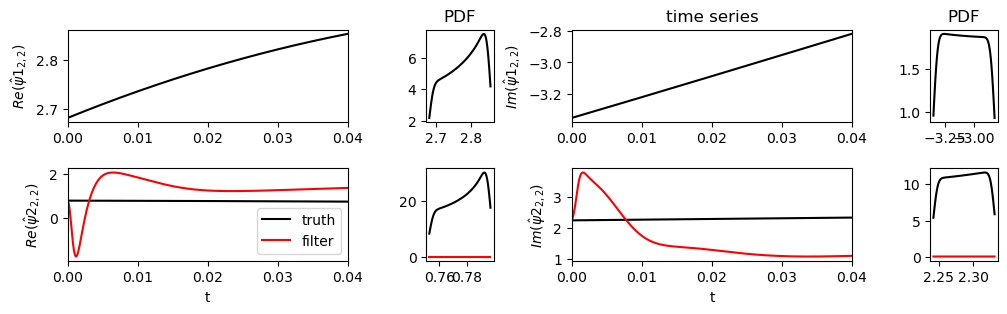

In [116]:
# Plot
sel0 = 0; sel1 = N # plot time range
ikx = 2; iky = 2 # mode to plot
interv = 10 # plot interval
xaxis = np.arange(sel0*dt, sel1*dt, interv*dt)

fig = plt.figure(figsize=(12,3))
widths = [5, 1.2, 5, 1.2]
heights = [1, 1]
spec = fig.add_gridspec(ncols=4, nrows=2, width_ratios=widths, height_ratios=heights)

plt.subplots_adjust(wspace=0.45, hspace=0.5)     # Adjust the overall spacing of the figure
ax1 = fig.add_subplot(spec[0, 0])
ax2 = fig.add_subplot(spec[1, 0])
ax3 = fig.add_subplot(spec[0, 1])
ax4 = fig.add_subplot(spec[1, 1])
ax11 = fig.add_subplot(spec[0, 2])
ax22 = fig.add_subplot(spec[1, 2])
ax33 = fig.add_subplot(spec[0, 3])
ax44 = fig.add_subplot(spec[1, 3])

# plot time series
ax1.plot(xaxis, psi1_k_t[iky,ikx,sel0:sel1:interv].real, 'k')
ax1.set_xlim(sel0*dt, sel1*dt)
ax1.set_ylabel('$Re(\hat{{\psi}}1_{{{:d},{:d}}})$'.format(ikx, iky))

ax2.plot(xaxis, psi2_k_t[iky,ikx,sel0:sel1:interv].real, 'k', label='truth')
ax2.plot(xaxis, mu_t[iky,ikx,sel0:sel1:interv].real, 'r', label='filter')
ax2.set_xlim(sel0*dt, sel1*dt)
ax2.set_ylabel(r'$Re(\hat{{\psi}}2_{{{:d},{:d}}})$'.format(ikx, iky))
ax2.set_xlabel('t')
ax2.legend()
# ax2.set_xlim(0,0.01)
# ax2.set_ylim(-2.58,-2.56)

# plot pdf
samples = psi1_k_t[iky, ikx, :N].real
kde = gaussian_kde(samples)
xticks = np.linspace(samples.min(), samples.max(), 100)
p = kde.evaluate(xticks)
ax3.plot(xticks, p, 'k')
ax3.set_title('PDF')

samples = psi2_k_t[iky, ikx, :N].real
kde = gaussian_kde(samples)
xticks = np.linspace(samples.min(), samples.max(), 100)
p = kde.evaluate(xticks)
ax4.plot(xticks, p, 'k', label='truth')
samples = mu_t[iky, ikx, :].real
kde = gaussian_kde(samples)
p = kde.evaluate(xticks)
ax4.plot(xticks, p, 'r', label='filter')

ax11.plot(xaxis, psi1_k_t[iky,ikx,sel0:sel1:interv].imag, 'k')
ax11.set_xlim(sel0*dt, sel1*dt)
ax11.set_ylabel('$Im(\hat{{\psi}}1_{{{:d},{:d}}})$'.format(ikx, iky))
ax11.set_title('time series')

ax22.plot(xaxis, psi2_k_t[iky,ikx,sel0:sel1:interv].imag, 'k', label='truth')
ax22.plot(xaxis, mu_t[iky,ikx,sel0:sel1:interv].imag, 'r', label='filter')
ax22.set_xlim(sel0*dt, sel1*dt)
ax22.set_ylabel(r'$Im(\hat{{\psi}}2_{{{:d},{:d}}})$'.format(ikx, iky))
ax22.set_xlabel('t')

# plot pdf
samples = psi1_k_t[iky, ikx, :N].imag
kde = gaussian_kde(samples)
xticks = np.linspace(samples.min(), samples.max(), 100)
p = kde.evaluate(xticks)
ax33.plot(xticks, p, 'k')
ax33.set_title('PDF')

samples = psi2_k_t[iky, ikx, :N].imag
kde = gaussian_kde(samples)
xticks = np.linspace(samples.min(), samples.max(), 100)
p = kde.evaluate(xticks)
ax44.plot(xticks, p, 'k', label='truth')
samples = mu_t[iky, ikx, :].imag
kde = gaussian_kde(samples)
p = kde.evaluate(xticks)
ax44.plot(xticks, p, 'r', label='filter')
# plt.savefig('./Lagrangian_DA/LagDA_K16_CG_tr.png',dpi=100)
plt.show()

In [117]:
# ifft to real space
psi1_t = np.zeros_like(psi1_k_t)
psi2_t = np.zeros_like(psi2_k_t)
psi2_pos = np.zeros_like(mu_t)
for i in range(N):
    psi1_t[:,:,i] = np.fft.ifft2(psi1_k_t[:, :, i])
    psi2_t[:,:,i] = np.fft.ifft2(psi2_k_t[:, :, i])
    psi2_pos[:,:,i] = np.fft.ifft2(mu_t[:, :, i])

# check imaginary part
# max_imag_abs = max(np.max(np.abs(np.imag(psi1_t))), np.max(np.abs(np.imag(psi2_t))))
max_imag_abs = max(np.max(np.abs(np.imag(psi1_t))), np.max(np.abs(np.imag(psi2_t))), np.max(np.abs(np.imag(psi2_pos))))
if max_imag_abs > 1e-10:
    raise Exception("get significant imaginary parts, check ifft2")
else:
    psi1_t = np.real(psi1_t)
    psi2_t = np.real(psi2_t)
    psi2_pos = np.real(psi2_pos)

# shift domain from [0,2pi) to [-pi,pi)
psi1_t = np.roll(psi1_t, shift=K//2, axis=0) 
psi1_t = np.roll(psi1_t, shift=K//2, axis=1) 
psi2_t = np.roll(psi2_t, shift=K//2, axis=0)
psi2_t = np.roll(psi2_t, shift=K//2, axis=1)
psi2_pos = np.roll(psi2_pos, shift=K//2, axis=0)
psi2_pos = np.roll(psi2_pos, shift=K//2, axis=1)

Exception: get significant imaginary parts, check ifft2

modify the code to create model matrix one at a time

In [27]:
def get_coef_mat(KX, KY, K_squared, kd, beta, kappa, U, psi1_hat, psi2_hat, h_hat):
    K = KX.shape[0]
    
    # psi_hat, hk should be of shape (N, K, K), if not, reshape them to make it legible
    if psi1_hat.shape[-2:] != KX.shape:
        psi1_hat = np.transpose(psi1_hat, axes=(2,0,1))
#     if psi2_hat.shape[-2:] != KX.shape:
#         psi2_hat = np.transpose(psi2_hat, axes=(2,0,1))
    if h_hat.shape[-2:] != KX.shape:
        h_hat = np.transpose(h_hat, axes=(2,0,1))

#     # make sure \partial psi1_k / \partial x be conjugate symmetric
#     psi1_hat[:, :, K//2] = 0
#     psi2_hat[:, :, K//2] = 0

    # define Ck for each wave number
    Ck = 1 / (K_squared * (K_squared + kd**2))
    Ck[K_squared == 0] = 0  # avoid division by zero at k = 0, constant mode

    # linear part for A0, a0, A1 and a1
    linear_A0 = 1j * KX * (((K_squared + kd**2/2)*beta - K_squared**2 * U)*psi1_hat - kd**2/2 * U * h_hat)
    linear_a0 = 1j * KX * ((kd**2/2 * beta - kd**2 * K_squared * U)*psi1_hat - (K_squared + kd**2/2) * U * h_hat)
    linear_A1_diag = 1j * KX * (kd**2/2 * beta + kd**2 * K_squared * U) - (kd**2/2 * kappa * K_squared)
    linear_a1_diag = 1j * KX * ((K_squared + kd**2/2)*beta + K_squared**2 * U) - (K_squared + kd**2/2) * kappa * K_squared
    linear_A1 = np.tile(np.diag(linear_A1_diag.flatten(order='F'))[None,:,:], (psi1_hat.shape[0],1,1)) 
    linear_a1 = np.tile(np.diag(linear_a1_diag.flatten(order='F'))[None,:,:], (psi1_hat.shape[0],1,1)) 
    
    # nonlinear summation part for A0, a0, A1 and a1
    nonlinear_sum_A0 = np.zeros_like(psi1_hat, dtype=complex)
    nonlinear_sum_a0 = np.zeros_like(psi1_hat, dtype=complex)
    nonlinear_sum_A1 = np.zeros_like(linear_A1, dtype=complex)
    nonlinear_sum_a1 = np.zeros_like(linear_a1, dtype=complex)
    k_index_map = {(KX[iy, ix], KY[iy, ix]): (ix, iy) for ix in range(K) for iy in range(K)}
    
#     # check 
#     det_sum = np.zeros(KX.shape)
#     Jacobi_2_diff = np.zeros_like(psi1_hat, dtype=complex)
    
    for imx in range(K):
        for imy in range(K):
            m = [KX[imy, imx], KY[imy, imx]]
            psi1_m = psi1_hat[:, imy, imx]
#             psi2_m = psi2_hat[:, imy, imx]

            for inx in range(K):
                for iny in range(K):
                    n = [KX[iny, inx], KY[iny, inx]]
                    psi1_n = psi1_hat[:, iny, inx]
#                     psi2_n = psi2_hat[:, iny, inx]
                    h_n = h_hat[iny, inx]
                    
                    # Check if k is within the wave number sets
                    k = (m[0] + n[0], m[1] + n[1])
                    
                    if k in k_index_map:
                        ikx, iky = k_index_map[k]
                        ik_flatten = ikx * K + iky
                        im_flatten = imx * K + imy
                        k_mod = K_squared[iky, ikx]
                        det_mn = np.linalg.det(np.array([m, n]))
#                         nonlinear_sum_A0[:, iky, ikx] -= det_mn * ((k_mod + kd**2 / 2)**2 * psi1_n * psi1_m)
#                         nonlinear_sum_a0[:, iky, ikx] -= det_mn * (kd**2 / 2 * (k_mod + kd**2 / 2) * psi1_n * psi1_m)
                        nonlinear_sum_A1[:, ik_flatten, im_flatten] += det_mn * kd**2 / 2 * (k_mod * psi1_n - h_n)
                        nonlinear_sum_a1[:, ik_flatten, im_flatten] -= det_mn * (k_mod * kd**2 / 2 * psi1_n - (k_mod + kd**2 / 2) * h_n) 
                        
#                         if k == (3,2) and np.isclose(np.abs(det_mn),3):
#                             incc = -det_mn * (k_mod * kd**2 / 2 * psi1_n - (k_mod + kd**2 / 2) * h_n)
#                             print(m,n,det_mn,incc[1])
    
#                         det_sum[iky,ikx] += det_mn
#                         Jacobi_2_diff[:,iky,ikx] -= det_mn *  ((k_mod + kd**2 / 2)**2 * psi2_n * psi2_m)
    # aggregate 
    A0 = linear_A0 + nonlinear_sum_A0
    a0 = linear_a0 + nonlinear_sum_a0
    A1 = linear_A1 + nonlinear_sum_A1
    a1 = linear_a1 + nonlinear_sum_a1
    
    # enforce conjugate symmetry
    A1[:, 8::K, :] = 0
    A1[:, 8*K:9*K, :] = 0
    a1[:, 8::K, :] = 0
    a1[:, 8*K:9*K, :] = 0
    
    # normalization 
    Ck_ = np.tile(Ck.flatten(order='F')[None,:,None], (psi1_hat.shape[0],1,K**2))
    A0 = Ck * A0
    a0 = Ck * a0
    A1 = Ck_ * A1
    a1 = Ck_ * a1
    
    # flatten
    A0 = A0.reshape((A0.shape[0], -1), order='F')
    a0 = a0.reshape((a0.shape[0], -1), order='F')
    
    return A0, a0, A1, a1#, np.tile(Ck.flatten(order='F')[:,None], (1,K**2)) * nonlinear_sum_A1, det_sum, Jacobi_2_diff

N = 40000
kx = np.fft.fftfreq(K) * K
ky = np.fft.fftfreq(K) * K
KX, KY = np.meshgrid(kx, ky)
K_squared = KX**2 + KY**2

# prepare coefficient matrices used in DA
# A0_t, a0_t, A1_t, a1_t = get_coef_mat(KX, KY, K_squared, kd, beta, kappa, U, psi1_k_t[:,:,:N], psi2_k_t[:,:,:N], h_hat)
# InvBoB = 1 / sigma_1**2
# InvBoB = truncated_InvBoB.flatten(order='F')
InvBoB = 1 / 4.**2

# initialized mean and variance
mu0 = psi2_k_t[:,:,0].flatten(order='F') # assume the initial condition is truth
K_ = mu0.shape[0] # flattened K*K
R0 = np.zeros((K_, K_), dtype='complex')
mu_t = np.zeros((K_, N), dtype='complex')  # posterior mean
mu_t[:, 0] = mu0
R_t = np.zeros((K_, N), dtype='complex')  # posterior covariance
R_t[:, 0] = np.diag(R0)  # only save the diagonal elements

# enforce conjugate symmetry
psi1_k_t[:,K//2,:] = 0
psi2_k_t[:,K//2,:] = 0
psi1_k_t[K//2,:,:] = 0
psi2_k_t[K//2,:,:] = 0

# Lagrangian DA
for i in range(1, N):
    A0, a0, A1, a1 = get_coef_mat(KX, KY, K_squared, kd, beta, kappa, U, psi1_k_t[:,:,i-1][:,:,None], psi2_k_t[:,:,i-1][:,:,None], h_hat)
    A0 = A0[0, :]
    a0 = a0[0, :]
    A1 = A1[0, :, :]
    a1 = a1[0, :, :]
    
    psi1_diff = psi1_k_t[:, :, i] - psi1_k_t[:, :, i - 1]
    psi1_diff = psi1_diff.flatten(order='F')

    # Update the posterior mean and posterior covariance
    mu = mu0 + (a0 + a1 @ mu0) * dt + (R0 @ A1.conj().T) * InvBoB @ (psi1_diff - (A0 + A1 @ mu0) * dt)
    R = R0 + (a1 @ R0 + R0 @ a1.conj().T + np.diag(sigma_2**2) - (R0 @ A1.conj().T) * InvBoB @ A1 @ R0.conj().T) * dt
    mu_t[:, i] = mu
    R_t[:, i] = np.diag(R)
    mu0 = mu
    R0 = R

/var/folders/lz/50081q0n24g8lq6ncqpbp8780000gn/T/ipykernel_9620/1661306355.py:17: RuntimeWarning: divide by zero encountered in divide
  Ck = 1 / (K_squared * (K_squared + kd**2))


In [28]:
# reshape flattened variables to two modes matrices
mu_t = mu_t.reshape((K,K,-1), order='F')
mu_t.shape

(16, 16, 40000)

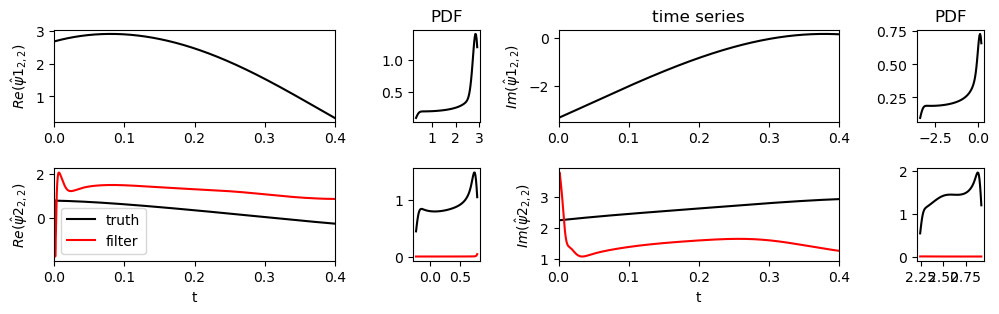

In [29]:
# Plot
sel0 = 0; sel1 = N # plot time range
ikx = 2; iky = 2 # mode to plot
interv = 10 # plot interval
xaxis = np.arange(sel0*dt, sel1*dt, interv*dt)

fig = plt.figure(figsize=(12,3))
widths = [5, 1.2, 5, 1.2]
heights = [1, 1]
spec = fig.add_gridspec(ncols=4, nrows=2, width_ratios=widths, height_ratios=heights)

plt.subplots_adjust(wspace=0.45, hspace=0.5)     # Adjust the overall spacing of the figure
ax1 = fig.add_subplot(spec[0, 0])
ax2 = fig.add_subplot(spec[1, 0])
ax3 = fig.add_subplot(spec[0, 1])
ax4 = fig.add_subplot(spec[1, 1])
ax11 = fig.add_subplot(spec[0, 2])
ax22 = fig.add_subplot(spec[1, 2])
ax33 = fig.add_subplot(spec[0, 3])
ax44 = fig.add_subplot(spec[1, 3])

# plot time series
ax1.plot(xaxis, psi1_k_t[iky,ikx,sel0:sel1:interv].real, 'k')
ax1.set_xlim(sel0*dt, sel1*dt)
ax1.set_ylabel('$Re(\hat{{\psi}}1_{{{:d},{:d}}})$'.format(ikx, iky))

ax2.plot(xaxis, psi2_k_t[iky,ikx,sel0:sel1:interv].real, 'k', label='truth')
ax2.plot(xaxis, mu_t[iky,ikx,sel0:sel1:interv].real, 'r', label='filter')
ax2.set_xlim(sel0*dt, sel1*dt)
ax2.set_ylabel(r'$Re(\hat{{\psi}}2_{{{:d},{:d}}})$'.format(ikx, iky))
ax2.set_xlabel('t')
ax2.legend()
# ax2.set_xlim(0,0.01)
# ax2.set_ylim(-2.58,-2.56)

# plot pdf
samples = psi1_k_t[iky, ikx, :N].real
kde = gaussian_kde(samples)
xticks = np.linspace(samples.min(), samples.max(), 100)
p = kde.evaluate(xticks)
ax3.plot(xticks, p, 'k')
ax3.set_title('PDF')

samples = psi2_k_t[iky, ikx, :N].real
kde = gaussian_kde(samples)
xticks = np.linspace(samples.min(), samples.max(), 100)
p = kde.evaluate(xticks)
ax4.plot(xticks, p, 'k', label='truth')
samples = mu_t[iky, ikx, :].real
kde = gaussian_kde(samples)
p = kde.evaluate(xticks)
ax4.plot(xticks, p, 'r', label='filter')

ax11.plot(xaxis, psi1_k_t[iky,ikx,sel0:sel1:interv].imag, 'k')
ax11.set_xlim(sel0*dt, sel1*dt)
ax11.set_ylabel('$Im(\hat{{\psi}}1_{{{:d},{:d}}})$'.format(ikx, iky))
ax11.set_title('time series')

ax22.plot(xaxis, psi2_k_t[iky,ikx,sel0:sel1:interv].imag, 'k', label='truth')
ax22.plot(xaxis, mu_t[iky,ikx,sel0:sel1:interv].imag, 'r', label='filter')
ax22.set_xlim(sel0*dt, sel1*dt)
ax22.set_ylabel(r'$Im(\hat{{\psi}}2_{{{:d},{:d}}})$'.format(ikx, iky))
ax22.set_xlabel('t')

# plot pdf
samples = psi1_k_t[iky, ikx, :N].imag
kde = gaussian_kde(samples)
xticks = np.linspace(samples.min(), samples.max(), 100)
p = kde.evaluate(xticks)
ax33.plot(xticks, p, 'k')
ax33.set_title('PDF')

samples = psi2_k_t[iky, ikx, :N].imag
kde = gaussian_kde(samples)
xticks = np.linspace(samples.min(), samples.max(), 100)
p = kde.evaluate(xticks)
ax44.plot(xticks, p, 'k', label='truth')
samples = mu_t[iky, ikx, :].imag
kde = gaussian_kde(samples)
p = kde.evaluate(xticks)
ax44.plot(xticks, p, 'r', label='filter')
# plt.savefig('./Lagrangian_DA/LagDA_K16_CG_tr.png',dpi=100)
plt.show()

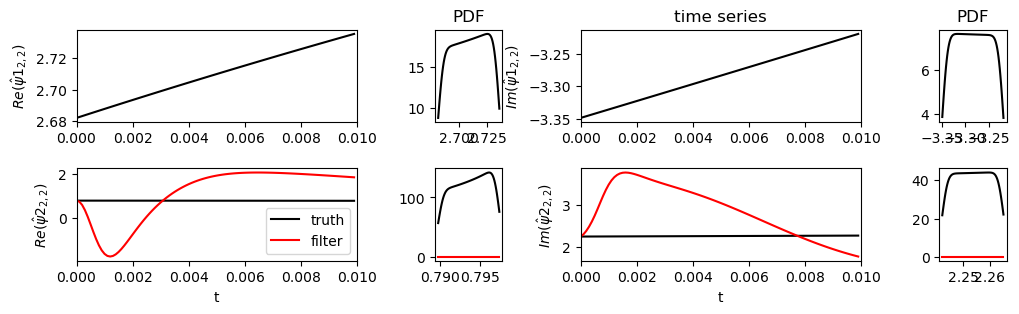

In [25]:
# Plot
sel0 = 0; sel1 = N # plot time range
ikx = 2; iky = 2 # mode to plot
interv = 10 # plot interval
xaxis = np.arange(sel0*dt, sel1*dt, interv*dt)

fig = plt.figure(figsize=(12,3))
widths = [5, 1.2, 5, 1.2]
heights = [1, 1]
spec = fig.add_gridspec(ncols=4, nrows=2, width_ratios=widths, height_ratios=heights)

plt.subplots_adjust(wspace=0.45, hspace=0.5)     # Adjust the overall spacing of the figure
ax1 = fig.add_subplot(spec[0, 0])
ax2 = fig.add_subplot(spec[1, 0])
ax3 = fig.add_subplot(spec[0, 1])
ax4 = fig.add_subplot(spec[1, 1])
ax11 = fig.add_subplot(spec[0, 2])
ax22 = fig.add_subplot(spec[1, 2])
ax33 = fig.add_subplot(spec[0, 3])
ax44 = fig.add_subplot(spec[1, 3])

# plot time series
ax1.plot(xaxis, psi1_k_t[iky,ikx,sel0:sel1:interv].real, 'k')
ax1.set_xlim(sel0*dt, sel1*dt)
ax1.set_ylabel('$Re(\hat{{\psi}}1_{{{:d},{:d}}})$'.format(ikx, iky))

ax2.plot(xaxis, psi2_k_t[iky,ikx,sel0:sel1:interv].real, 'k', label='truth')
ax2.plot(xaxis, mu_t[iky,ikx,sel0:sel1:interv].real, 'r', label='filter')
ax2.set_xlim(sel0*dt, sel1*dt)
ax2.set_ylabel(r'$Re(\hat{{\psi}}2_{{{:d},{:d}}})$'.format(ikx, iky))
ax2.set_xlabel('t')
ax2.legend()
# ax2.set_xlim(0,0.01)
# ax2.set_ylim(-2.58,-2.56)

# plot pdf
samples = psi1_k_t[iky, ikx, :N].real
kde = gaussian_kde(samples)
xticks = np.linspace(samples.min(), samples.max(), 100)
p = kde.evaluate(xticks)
ax3.plot(xticks, p, 'k')
ax3.set_title('PDF')

samples = psi2_k_t[iky, ikx, :N].real
kde = gaussian_kde(samples)
xticks = np.linspace(samples.min(), samples.max(), 100)
p = kde.evaluate(xticks)
ax4.plot(xticks, p, 'k', label='truth')
samples = mu_t[iky, ikx, :].real
kde = gaussian_kde(samples)
p = kde.evaluate(xticks)
ax4.plot(xticks, p, 'r', label='filter')

ax11.plot(xaxis, psi1_k_t[iky,ikx,sel0:sel1:interv].imag, 'k')
ax11.set_xlim(sel0*dt, sel1*dt)
ax11.set_ylabel('$Im(\hat{{\psi}}1_{{{:d},{:d}}})$'.format(ikx, iky))
ax11.set_title('time series')

ax22.plot(xaxis, psi2_k_t[iky,ikx,sel0:sel1:interv].imag, 'k', label='truth')
ax22.plot(xaxis, mu_t[iky,ikx,sel0:sel1:interv].imag, 'r', label='filter')
ax22.set_xlim(sel0*dt, sel1*dt)
ax22.set_ylabel(r'$Im(\hat{{\psi}}2_{{{:d},{:d}}})$'.format(ikx, iky))
ax22.set_xlabel('t')

# plot pdf
samples = psi1_k_t[iky, ikx, :N].imag
kde = gaussian_kde(samples)
xticks = np.linspace(samples.min(), samples.max(), 100)
p = kde.evaluate(xticks)
ax33.plot(xticks, p, 'k')
ax33.set_title('PDF')

samples = psi2_k_t[iky, ikx, :N].imag
kde = gaussian_kde(samples)
xticks = np.linspace(samples.min(), samples.max(), 100)
p = kde.evaluate(xticks)
ax44.plot(xticks, p, 'k', label='truth')
samples = mu_t[iky, ikx, :].imag
kde = gaussian_kde(samples)
p = kde.evaluate(xticks)
ax44.plot(xticks, p, 'r', label='filter')
# plt.savefig('./Lagrangian_DA/LagDA_K16_CG_tr.png',dpi=100)
plt.show()

NameError: name 'psi1_t' is not defined

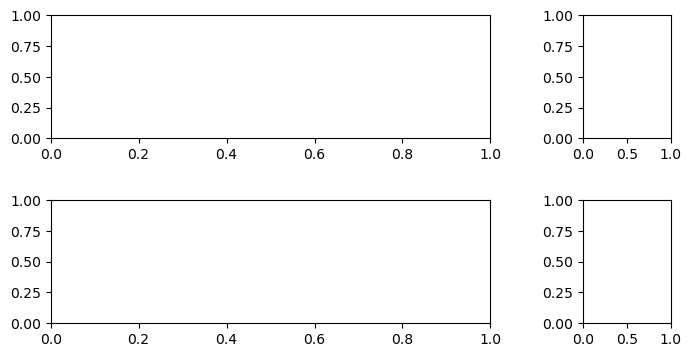

In [101]:
# Plot
sel0 = 0; sel1 = N # plot time range
ikx = 2; iky = 2 # x,y to plot
interv = 10 # plot interval
xaxis = np.arange(sel0*dt, sel1*dt, interv*dt)

fig = plt.figure(figsize=(8,4))
widths = [5, 1]
heights = [1, 1]
spec = fig.add_gridspec(ncols=2, nrows=2, width_ratios=widths, height_ratios=heights)

plt.subplots_adjust(wspace=0.35, hspace=0.5)     # Adjust the overall spacing of the figure
ax1 = fig.add_subplot(spec[0, 0])
ax2 = fig.add_subplot(spec[1, 0])
ax3 = fig.add_subplot(spec[0, 1])
ax4 = fig.add_subplot(spec[1, 1])

# plot time series
ax1.plot(xaxis, psi1_t[iky,ikx,sel0:sel1:interv], 'k')
ax1.set_xlim(sel0*dt, sel1*dt)
ax1.set_ylabel('$Re(\psi1_{{{:d},{:d}}})$'.format(ikx, iky))

ax2.plot(xaxis, psi2_t[iky,ikx,sel0:sel1:interv], 'k', label='truth')
ax2.plot(xaxis, psi2_pos[iky,ikx,sel0:sel1:interv], 'r', label='filter')
ax2.set_xlim(sel0*dt, sel1*dt)
ax2.set_ylabel(r'$Re(\psi2_{{{:d},{:d}}})$'.format(ikx, iky))
ax2.set_xlabel('t')
ax2.legend()
# ax2.set_xlim(0,0.01)
# ax2.set_ylim(-2.58,-2.56)

# plot pdf
samples = psi1_t[iky, ikx, :N]
kde = gaussian_kde(samples)
xticks = np.linspace(samples.min(), samples.max(), 100)
p = kde.evaluate(xticks)
ax3.plot(xticks, p, 'k')
ax3.set_title('PDF')

samples = psi2_t[iky, ikx, :N]
kde = gaussian_kde(samples)
xticks = np.linspace(samples.min(), samples.max(), 100)
p = kde.evaluate(xticks)
ax4.plot(xticks, p, 'k', label='truth')
samples = psi2_pos[iky, ikx, :].real
kde = gaussian_kde(samples)
p = kde.evaluate(xticks)
ax4.plot(xticks, p, 'r', label='filter')

# plt.savefig('./Lagrangian_DA/LagDA_K16_CG_tr.png',dpi=100)
plt.show()

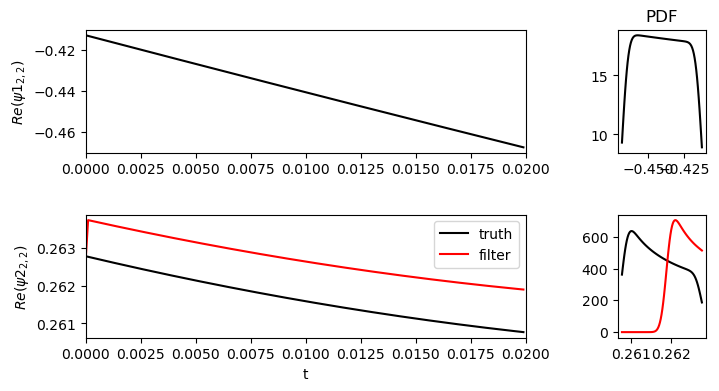

In [274]:
# Plot
sel0 = 0; sel1 = N # plot time range
ikx = 2; iky = 2 # x,y to plot
interv = 10 # plot interval
xaxis = np.arange(sel0*dt, sel1*dt, interv*dt)

fig = plt.figure(figsize=(8,4))
widths = [5, 1]
heights = [1, 1]
spec = fig.add_gridspec(ncols=2, nrows=2, width_ratios=widths, height_ratios=heights)

plt.subplots_adjust(wspace=0.35, hspace=0.5)     # Adjust the overall spacing of the figure
ax1 = fig.add_subplot(spec[0, 0])
ax2 = fig.add_subplot(spec[1, 0])
ax3 = fig.add_subplot(spec[0, 1])
ax4 = fig.add_subplot(spec[1, 1])

# plot time series
ax1.plot(xaxis, psi1_t[iky,ikx,sel0:sel1:interv], 'k')
ax1.set_xlim(sel0*dt, sel1*dt)
ax1.set_ylabel('$Re(\psi1_{{{:d},{:d}}})$'.format(ikx, iky))

ax2.plot(xaxis, psi2_t[iky,ikx,sel0:sel1:interv], 'k', label='truth')
ax2.plot(xaxis, psi2_pos[iky,ikx,sel0:sel1:interv], 'r', label='filter')
ax2.set_xlim(sel0*dt, sel1*dt)
ax2.set_ylabel(r'$Re(\psi2_{{{:d},{:d}}})$'.format(ikx, iky))
ax2.set_xlabel('t')
ax2.legend()
# ax2.set_xlim(0,0.01)
# ax2.set_ylim(-2.58,-2.56)

# plot pdf
samples = psi1_t[iky, ikx, :N]
kde = gaussian_kde(samples)
xticks = np.linspace(samples.min(), samples.max(), 100)
p = kde.evaluate(xticks)
ax3.plot(xticks, p, 'k')
ax3.set_title('PDF')

samples = psi2_t[iky, ikx, :N]
kde = gaussian_kde(samples)
xticks = np.linspace(samples.min(), samples.max(), 100)
p = kde.evaluate(xticks)
ax4.plot(xticks, p, 'k', label='truth')
samples = psi2_pos[iky, ikx, :].real
kde = gaussian_kde(samples)
p = kde.evaluate(xticks)
ax4.plot(xticks, p, 'r', label='filter')

# plt.savefig('./Lagrangian_DA/LagDA_K16_CG_tr.png',dpi=100)
plt.show()

In [ ]:
# DA

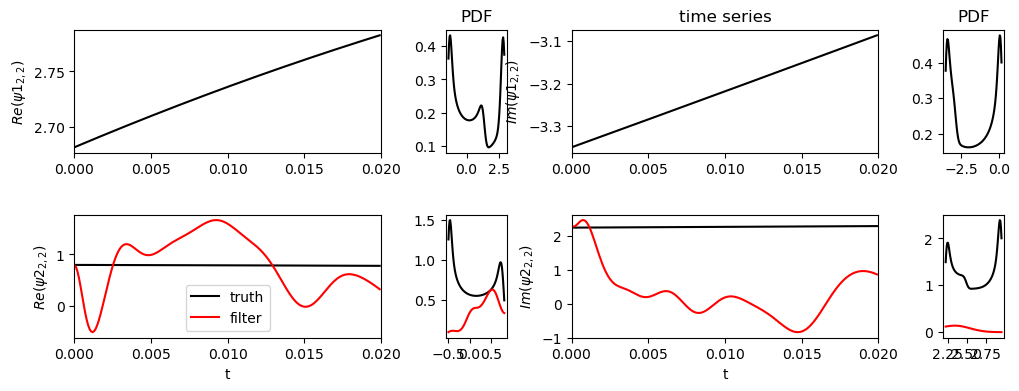

In [169]:
# Plot
sel0 = 0; sel1 = N # plot time range
ikx = 2; iky = 2 # mode to plot
interv = 10 # plot interval
xaxis = np.arange(sel0*dt, sel1*dt, interv*dt)

fig = plt.figure(figsize=(12,4))
widths = [5, 1, 5, 1]
heights = [1, 1]
spec = fig.add_gridspec(ncols=4, nrows=2, width_ratios=widths, height_ratios=heights)

plt.subplots_adjust(wspace=0.35, hspace=0.5)     # Adjust the overall spacing of the figure
ax1 = fig.add_subplot(spec[0, 0])
ax2 = fig.add_subplot(spec[1, 0])
ax3 = fig.add_subplot(spec[0, 1])
ax4 = fig.add_subplot(spec[1, 1])
ax11 = fig.add_subplot(spec[0, 2])
ax22 = fig.add_subplot(spec[1, 2])
ax33 = fig.add_subplot(spec[0, 3])
ax44 = fig.add_subplot(spec[1, 3])

# plot time series
ax1.plot(xaxis, psi1_k_t[iky,ikx,sel0:sel1:interv].real, 'k')
ax1.set_xlim(sel0*dt, sel1*dt)
ax1.set_ylabel('$Re(\psi1_{{{:d},{:d}}})$'.format(ikx, iky))

ax2.plot(xaxis, psi2_k_t[iky,ikx,sel0:sel1:interv].real, 'k', label='truth')
ax2.plot(xaxis, mu_t[iky,ikx,sel0:sel1:interv].real, 'r', label='filter')
ax2.set_xlim(sel0*dt, sel1*dt)
ax2.set_ylabel(r'$Re(\psi2_{{{:d},{:d}}})$'.format(ikx, iky))
ax2.set_xlabel('t')
ax2.legend()
# ax2.set_xlim(0,0.01)
# ax2.set_ylim(-2.58,-2.56)

# plot pdf
samples = psi1_k_t[iky, ikx, :N].real
kde = gaussian_kde(samples)
xticks = np.linspace(samples.min(), samples.max(), 100)
p = kde.evaluate(xticks)
ax3.plot(xticks, p, 'k')
ax3.set_title('PDF')

samples = psi2_k_t[iky, ikx, :N].real
kde = gaussian_kde(samples)
xticks = np.linspace(samples.min(), samples.max(), 100)
p = kde.evaluate(xticks)
ax4.plot(xticks, p, 'k', label='truth')
samples = mu_t[iky, ikx, :].real
kde = gaussian_kde(samples)
p = kde.evaluate(xticks)
ax4.plot(xticks, p, 'r', label='filter')

ax11.plot(xaxis, psi1_k_t[iky,ikx,sel0:sel1:interv].imag, 'k')
ax11.set_xlim(sel0*dt, sel1*dt)
ax11.set_ylabel('$Im(\psi1_{{{:d},{:d}}})$'.format(ikx, iky))
ax11.set_title('time series')

ax22.plot(xaxis, psi2_k_t[iky,ikx,sel0:sel1:interv].imag, 'k', label='truth')
ax22.plot(xaxis, mu_t[iky,ikx,sel0:sel1:interv].imag, 'r', label='filter')
ax22.set_xlim(sel0*dt, sel1*dt)
ax22.set_ylabel(r'$Im(\psi2_{{{:d},{:d}}})$'.format(ikx, iky))
ax22.set_xlabel('t')

# plot pdf
samples = psi1_k_t[iky, ikx, :N].imag
kde = gaussian_kde(samples)
xticks = np.linspace(samples.min(), samples.max(), 100)
p = kde.evaluate(xticks)
ax33.plot(xticks, p, 'k')
ax33.set_title('PDF')

samples = psi2_k_t[iky, ikx, :N].imag
kde = gaussian_kde(samples)
xticks = np.linspace(samples.min(), samples.max(), 100)
p = kde.evaluate(xticks)
ax44.plot(xticks, p, 'k', label='truth')
samples = mu_t[iky, ikx, :].imag
kde = gaussian_kde(samples)
p = kde.evaluate(xticks)
ax44.plot(xticks, p, 'r', label='filter')
plt.savefig('./Lagrangian_DA/LagDA_K16_CG_tr.png',dpi=100)
plt.show()

In [ ]:
# beta = 22

In [5]:
# load data
# sigma_1 = 4.
# sigma_2 = 16.
h_hat = np.fft.fft2(topo)
# h_hat = np.zeros((K,K))


In [23]:
# estimate Sigma based on residual
def get_coef_mat(KX, KY, K_squared, kd, beta, kappa, U, psi1_hat, psi2_hat, h_hat):
    # psi1_hat, hk should be of shape (N, K, K), if not, reshape them to make it legible
    if psi1_hat.shape[-2:] != KX.shape:
        psi1_hat = np.transpose(psi1_hat, axes=(2,0,1))
    if h_hat.shape[-2:] != KX.shape:
        h_hat = np.transpose(h_hat, axes=(2,0,1))
        
    psi2_hat = np.transpose(psi2_hat, axes=(2,0,1))

    # define Ck for each wave number
    Ck = 1 / (K_squared * (K_squared + kd**2))
    Ck[K_squared == 0] = 0  # avoid division by zero at k = 0

    # linear part for A0, a0, A1 and a1
    linear_A0 = 1j * KX * (((K_squared + kd**2/2)*beta - K_squared**2 * U)*psi1_hat - kd**2/2 * U * h_hat)
    linear_a0 = 1j * KX * ((kd**2/2 * beta - kd**2 * K_squared * U)*psi1_hat - (K_squared + kd**2/2) * U * h_hat)
    linear_A1_diag = 1j * KX * (kd**2/2 * beta + kd**2 * K_squared * U) - (kd**2/2 * kappa * K_squared)
    linear_a1_diag = 1j * KX * ((K_squared + kd**2/2)*beta + K_squared**2 * U) - (K_squared + kd**2/2)* kappa * K_squared
    linear_A1 = np.tile(np.diag(linear_A1_diag.flatten(order='F'))[None,:,:], (psi1_hat.shape[0],1,1)) 
    linear_a1 = np.tile(np.diag(linear_a1_diag.flatten(order='F'))[None,:,:], (psi1_hat.shape[0],1,1)) 
    
    # nonlinear summation part for A0, a0, A1 and a1
    nonlinear_sum_A0 = np.zeros_like(psi1_hat, dtype=complex)
    nonlinear_sum_a0 = np.zeros_like(psi1_hat, dtype=complex)
    nonlinear_sum_A1 = np.zeros_like(linear_A1, dtype=complex)
    nonlinear_sum_a1 = np.zeros_like(linear_a1, dtype=complex)
    k_index_map = {(KX[iy, ix], KY[iy, ix]): (ix, iy) for ix in range(K) for iy in range(K)}
    
    # check 
    det_sum = np.zeros(KX.shape)
    Jacobi_2_diff = np.zeros_like(psi1_hat, dtype=complex)
    
    for mx in range(K):
        for my in range(K):
            m = [KX[my, mx], KY[my, mx]]
            psi1_m = psi1_hat[:, my, mx]
            psi2_m = psi2_hat[:, my, mx]

            for nx in range(K):
                for ny in range(K):
                    n = [KX[ny, nx], KY[ny, nx]]
                    psi1_n = psi1_hat[:, ny, nx]
                    psi2_n = psi2_hat[:, ny, nx]
                    h_n = h_hat[ny, nx]
                    
                    # Check if k is within the wave number sets
                    k = (m[0] + n[0], m[1] + n[1])
                    
                    if k in k_index_map:
                        ix, iy = k_index_map[k]
                        ik_flatten = ix * K + iy
                        im_flatten = mx * K + my
                        k_mod = K_squared[iy, ix]
                        det_mn = np.linalg.det(np.array([m, n]))
                        nonlinear_sum_A0[:, iy, ix] -= det_mn * ((k_mod + kd**2 / 2)**2 * psi1_n * psi1_m)
                        nonlinear_sum_a0[:, iy, ix] -= det_mn * (kd**2 / 2 * (k_mod + kd**2 / 2) * psi1_n * psi1_m)
                        nonlinear_sum_A1[:, ik_flatten, im_flatten] += det_mn * kd**2 / 2 * (k_mod * psi1_n - h_n)
                        nonlinear_sum_a1[:, ik_flatten, im_flatten] -= det_mn * (k_mod * kd**2 / 2 * psi1_n - (k_mod + kd**2 / 2) * h_n)    
    
                        det_sum[iy,ix] += det_mn
                        Jacobi_2_diff[:,iy,ix] -= det_mn *  ((k_mod + kd**2 / 2)**2 * psi2_n * psi2_m)
    # aggregate 
    A0 = linear_A0 + nonlinear_sum_A0
    a0 = linear_a0 + nonlinear_sum_a0
    A1 = linear_A1 + nonlinear_sum_A1
    a1 = linear_a1 + nonlinear_sum_a1
    
    # normalization 
    A0 = Ck * A0
    a0 = Ck * a0
    A1 = np.tile(Ck.flatten(order='F')[:,None], (1,K**2)) * A1
    a1 = np.tile(Ck.flatten(order='F')[:,None], (1,K**2)) * a1
    
    # flatten
    A0 = A0.reshape((A0.shape[0], -1), order='F')
    a0 = a0.reshape((a0.shape[0], -1), order='F')
    
    return A0, a0, A1, a1, np.tile(Ck.flatten(order='F')[:,None], (1,K**2)) * nonlinear_sum_A1, det_sum, Jacobi_2_diff

N = 2000 #psi1_k_t.shape[-1]
kx = np.fft.fftfreq(K) * K
ky = np.fft.fftfreq(K) * K
KX, KY = np.meshgrid(kx, ky)
K_squared = KX**2 + KY**2
A0_t, a0_t, A1_t, a1_t, nonlinear_A1, det_sum, Jacobi_2_diff = get_coef_mat(KX, KY, K_squared, kd, beta, kappa, U, psi1_k_t[:,:,:N], psi2_k_t[:,:,:N], h_hat)

# calculate residual for each time step
res_1 = np.zeros_like(psi1_k_t, dtype='complex')
res_2 = np.zeros_like(psi2_k_t, dtype='complex')

/var/folders/lz/50081q0n24g8lq6ncqpbp8780000gn/T/ipykernel_3702/2075194867.py:12: RuntimeWarning: divide by zero encountered in divide
  Ck = 1 / (K_squared * (K_squared + kd**2))


In [24]:
A1_t.shape

(2000, 256, 256)

In [25]:
for i in range(1,N):
    A0 = A0_t[i-1, :]
    a0 = a0_t[i-1, :]
    A1 = A1_t[i-1, :, :]
    a1 = a1_t[i-1, :, :]
    psi1_k_t_flat0 = psi1_k_t[:,:,i-1].flatten(order='F')
    psi2_k_t_flat0 = psi2_k_t[:,:,i-1].flatten(order='F')
    psi1_k_t_flat1 = psi1_k_t[:,:,i].flatten(order='F')
    psi2_k_t_flat1 = psi2_k_t[:,:,i].flatten(order='F')
    res_1[:,:,i] = ((psi1_k_t_flat1 - psi1_k_t_flat0) - ((A0 + A1 @ psi2_k_t_flat0) * dt)).reshape((K,K), order='F')
    res_2[:,:,i] = ((psi2_k_t_flat1 - psi2_k_t_flat0) - ((a0 + a1 @ psi2_k_t_flat0) * dt)).reshape((K,K), order='F')
    
sigma_1 = np.std(res_1[:,:,:N], axis=2).flatten(order='F') / np.sqrt(2)
sigma_2 = np.std(res_2[:,:,:N], axis=2).flatten(order='F') / np.sqrt(2)
sigma_1[0] = 1
sigma_2[0] = 1

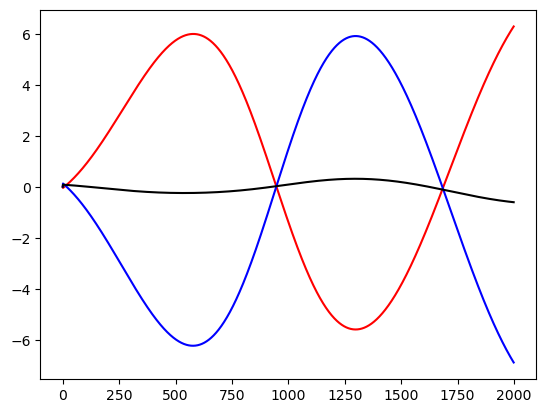

In [26]:
plt.plot(res_1[2,2,:N], 'r')
plt.plot(res_2[2,2,:N], 'b')
plt.plot(res_1[2,2,:N] + res_2[2,2,:N], 'k')
plt.show()

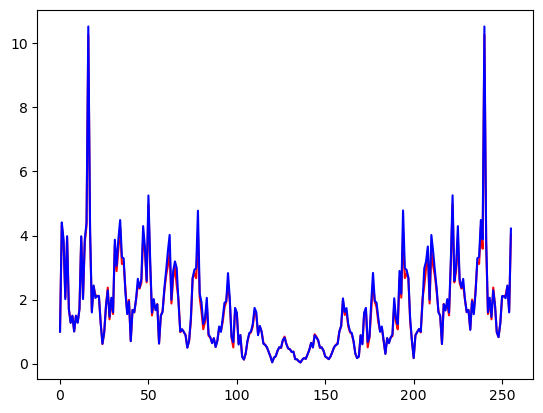

In [27]:
plt.plot(sigma_1, 'r')
plt.plot(sigma_2, 'b')
plt.show()

### truncate InvBoB

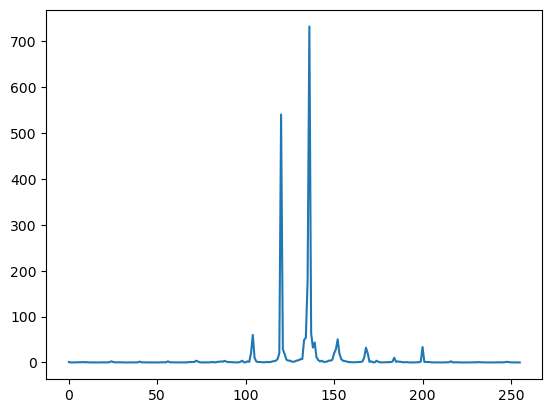

In [30]:
InvBoB = 1 / sigma_1**2
plt.plot(InvBoB)
plt.show()

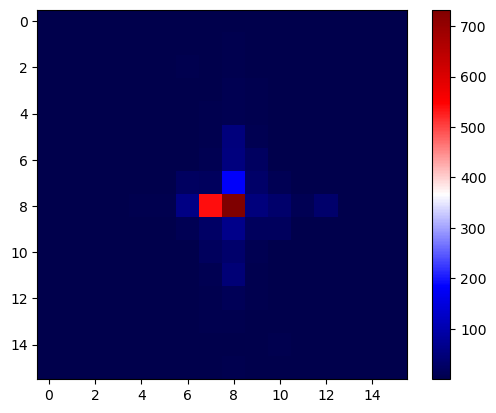

In [31]:
plt.imshow(InvBoB.reshape((K,K), order='F'), cmap='seismic')
plt.colorbar()

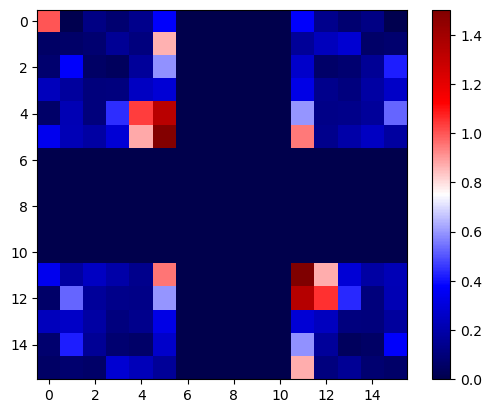

In [37]:
zero_out_indices = lambda i, j: 0 if (i-8)**2 < 5 or (j-8)**2 < 5 else InvBoB.reshape((K,K), order='F')[i, j]
truncated_InvBoB = np.array([[zero_out_indices(i, j) for j in range(K)] for i in range(K)])
plt.imshow(truncated_InvBoB, cmap='seismic')
plt.colorbar()

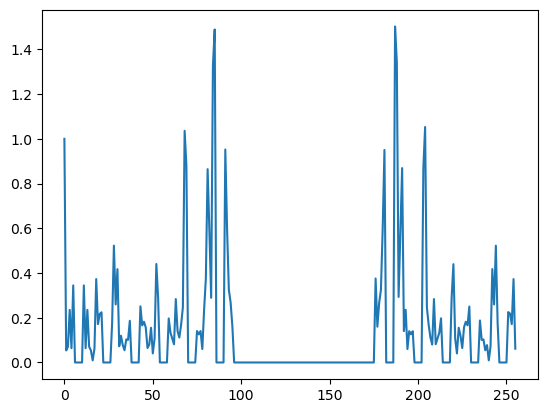

In [38]:
plt.plot(truncated_InvBoB.flatten(order='F'))
plt.show()

### Stiffness check

In [51]:
# Lagrangian DA
def get_coef_mat(KX, KY, K_squared, kd, beta, kappa, U, psi1_hat, psi2_hat, h_hat):
    # psi1_hat, hk should be of shape (N, K, K), if not, reshape them to make it legible
    if psi1_hat.shape[-2:] != KX.shape:
        psi1_hat = np.transpose(psi1_hat, axes=(2,0,1))
    if h_hat.shape[-2:] != KX.shape:
        h_hat = np.transpose(h_hat, axes=(2,0,1))
        
    psi2_hat = np.transpose(psi2_hat, axes=(2,0,1))

    # define Ck for each wave number
    Ck = 1 / (K_squared * (K_squared + kd**2))
    Ck[K_squared == 0] = 0  # avoid division by zero at k = 0

    # linear part for A0, a0, A1 and a1
    linear_A0 = 1j * KX * (((K_squared + kd**2/2)*beta - K_squared**2 * U)*psi1_hat - kd**2/2 * U * h_hat)
    linear_a0 = 1j * KX * ((kd**2/2 * beta - kd**2 * K_squared * U)*psi1_hat - (K_squared + kd**2/2) * U * h_hat)
    linear_A1_diag = 1j * KX * (kd**2/2 * beta + kd**2 * K_squared * U) - (kd**2/2 * kappa * K_squared)
    linear_a1_diag = 1j * KX * ((K_squared + kd**2/2)*beta + K_squared**2 * U) - (K_squared + kd**2/2)* kappa * K_squared
    linear_A1 = np.tile(np.diag(linear_A1_diag.flatten(order='F'))[None,:,:], (psi1_hat.shape[0],1,1)) 
    linear_a1 = np.tile(np.diag(linear_a1_diag.flatten(order='F'))[None,:,:], (psi1_hat.shape[0],1,1)) 
    
    # nonlinear summation part for A0, a0, A1 and a1
    nonlinear_sum_A0 = np.zeros_like(psi1_hat, dtype=complex)
    nonlinear_sum_a0 = np.zeros_like(psi1_hat, dtype=complex)
    nonlinear_sum_A1 = np.zeros_like(linear_A1, dtype=complex)
    nonlinear_sum_a1 = np.zeros_like(linear_a1, dtype=complex)
    k_index_map = {(KX[iy, ix], KY[iy, ix]): (ix, iy) for ix in range(K) for iy in range(K)}
    
    # check 
    det_sum = np.zeros(KX.shape)
    Jacobi_2_diff = np.zeros_like(psi1_hat, dtype=complex)
    
    for mx in range(K):
        for my in range(K):
            m = [KX[my, mx], KY[my, mx]]
            psi1_m = psi1_hat[:, my, mx]
            psi2_m = psi2_hat[:, my, mx]

            for nx in range(K):
                for ny in range(K):
                    n = [KX[ny, nx], KY[ny, nx]]
                    psi1_n = psi1_hat[:, ny, nx]
                    psi2_n = psi2_hat[:, ny, nx]
                    h_n = h_hat[ny, nx]
                    
                    # Check if k is within the wave number sets
                    k = (m[0] + n[0], m[1] + n[1])
                    
                    if k in k_index_map:
                        ix, iy = k_index_map[k]
                        ik_flatten = ix * K + iy
                        im_flatten = mx * K + my
                        k_mod = K_squared[iy, ix]
                        det_mn = np.linalg.det(np.array([m, n]))
                        nonlinear_sum_A0[:, iy, ix] -= det_mn * ((k_mod + kd**2 / 2)**2 * psi1_n * psi1_m)
                        nonlinear_sum_a0[:, iy, ix] -= det_mn * (kd**2 / 2 * (k_mod + kd**2 / 2) * psi1_n * psi1_m)
                        nonlinear_sum_A1[:, ik_flatten, im_flatten] += det_mn * kd**2 / 2 * (k_mod * psi1_n - h_n)
                        nonlinear_sum_a1[:, ik_flatten, im_flatten] -= det_mn * (k_mod * kd**2 / 2 * psi1_n - (k_mod + kd**2 / 2) * h_n)    
    
                        det_sum[iy,ix] += det_mn
                        Jacobi_2_diff[:,iy,ix] -= det_mn *  ((k_mod + kd**2 / 2)**2 * psi2_n * psi2_m)
    # aggregate 
    A0 = linear_A0 + nonlinear_sum_A0
    a0 = linear_a0 + nonlinear_sum_a0
    A1 = linear_A1 + nonlinear_sum_A1
    a1 = linear_a1 + nonlinear_sum_a1
    
    # normalization 
    A0 = Ck * A0
    a0 = Ck * a0
    A1 = np.tile(Ck.flatten(order='F')[:,None], (1,K**2)) * A1
    a1 = np.tile(Ck.flatten(order='F')[:,None], (1,K**2)) * a1
    
    # flatten
    A0 = A0.reshape((A0.shape[0], -1), order='F')
    a0 = a0.reshape((a0.shape[0], -1), order='F')
    
    return A0, a0, A1, a1, np.tile(Ck.flatten(order='F')[:,None], (1,K**2)) * nonlinear_sum_A1, det_sum, Jacobi_2_diff

N = 3
kx = np.fft.fftfreq(K) * K
ky = np.fft.fftfreq(K) * K
KX, KY = np.meshgrid(kx, ky)
K_squared = KX**2 + KY**2

# prepare coefficient matrices used in DA
A0_t, a0_t, A1_t, a1_t, nonlinear_A1, det_sum, Jacobi_2_diff = get_coef_mat(KX, KY, K_squared, kd, beta, kappa, U, psi1_k_t[:,:,:N], psi2_k_t[:,:,:N], h_hat)
# InvBoB = 1 / sigma_1**2
InvBoB = truncated_InvBoB.flatten(order='F')

# initialized mean and variance
mu0 = psi2_k_t[:,:,0].flatten(order='F') # assume the initial condition is truth
n = mu0.shape[0]
R0 = np.zeros((n, n), dtype='complex')
mu_t = np.zeros((n, N), dtype='complex')  # posterior mean
mu_t[:, 0] = mu0
R_t = np.zeros((n, N), dtype='complex')  # posterior covariance
R_t[:, 0] = np.diag(R0)  # only save the diagonal elements

# Lagrangian DA
for i in range(1, N):
    A0 = A0_t[i-1, :]
    a0 = a0_t[i-1, :]
    A1 = A1_t[i-1, :, :]
    a1 = a1_t[i-1, :, :]
    psi1_diff = psi1_k_t[:, :, i] - psi1_k_t[:, :, i - 1]
    psi1_diff = psi1_diff.flatten(order='F')

    # Update the posterior mean and posterior covariance
    check1 = (A1.conj().T) @ (- (A1 @ mu0) * dt)
    check2 = (R0 @ A1.conj().T) @ (- (A1 @ mu0) * dt)
    print(check1[4], check2[4])
    mu = mu0 + (a0 + a1 @ mu0) * dt + (R0 @ A1.conj().T) * InvBoB @ (psi1_diff - (A0 + A1 @ mu0) * dt)
    R = R0 + (a1 @ R0 + R0 @ a1.conj().T + np.diag(sigma_2**2) - (R0 @ A1.conj().T) * InvBoB @ A1 @ R0.conj().T) * dt
    mu_t[:, i] = mu
    R_t[:, i] = np.diag(R)
    mu0 = mu
    R0 = R


/var/folders/lz/50081q0n24g8lq6ncqpbp8780000gn/T/ipykernel_3702/1241646569.py:12: RuntimeWarning: divide by zero encountered in divide
  Ck = 1 / (K_squared * (K_squared + kd**2))


(364.9757322550639+2778.721035074657j) 0j
(822.1024179406788-7791.601478297607j) (6.503530967295662-61.63821002481404j)


In [107]:
k_index_map = {(KX[iy, ix], KY[iy, ix]): (ix, iy) for ix in range(K) for iy in range(K)}
k_index_map

{(0.0, 0.0): (0, 0),
 (0.0, 1.0): (0, 1),
 (0.0, 2.0): (0, 2),
 (0.0, 3.0): (0, 3),
 (0.0, 4.0): (0, 4),
 (0.0, 5.0): (0, 5),
 (0.0, 6.0): (0, 6),
 (0.0, 7.0): (0, 7),
 (0.0, -8.0): (0, 8),
 (0.0, -7.0): (0, 9),
 (0.0, -6.0): (0, 10),
 (0.0, -5.0): (0, 11),
 (0.0, -4.0): (0, 12),
 (0.0, -3.0): (0, 13),
 (0.0, -2.0): (0, 14),
 (0.0, -1.0): (0, 15),
 (1.0, 0.0): (1, 0),
 (1.0, 1.0): (1, 1),
 (1.0, 2.0): (1, 2),
 (1.0, 3.0): (1, 3),
 (1.0, 4.0): (1, 4),
 (1.0, 5.0): (1, 5),
 (1.0, 6.0): (1, 6),
 (1.0, 7.0): (1, 7),
 (1.0, -8.0): (1, 8),
 (1.0, -7.0): (1, 9),
 (1.0, -6.0): (1, 10),
 (1.0, -5.0): (1, 11),
 (1.0, -4.0): (1, 12),
 (1.0, -3.0): (1, 13),
 (1.0, -2.0): (1, 14),
 (1.0, -1.0): (1, 15),
 (2.0, 0.0): (2, 0),
 (2.0, 1.0): (2, 1),
 (2.0, 2.0): (2, 2),
 (2.0, 3.0): (2, 3),
 (2.0, 4.0): (2, 4),
 (2.0, 5.0): (2, 5),
 (2.0, 6.0): (2, 6),
 (2.0, 7.0): (2, 7),
 (2.0, -8.0): (2, 8),
 (2.0, -7.0): (2, 9),
 (2.0, -6.0): (2, 10),
 (2.0, -5.0): (2, 11),
 (2.0, -4.0): (2, 12),
 (2.0, -3.0): (2, 1

In [77]:
mu_t[4,:]

array([7.96834044e-01+6.38779706e+00j, 6.74517176e-01+1.19360210e+01j,
       3.78516215e+00+3.59099867e+01j, 1.99284658e+03+1.44339768e+04j,
       1.16814659e+09+8.46340229e+09j])

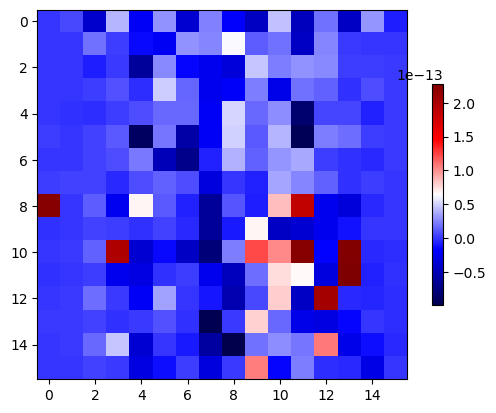

In [171]:
plt.imshow(det_sum, cmap='seismic')
plt.colorbar(shrink=0.6)

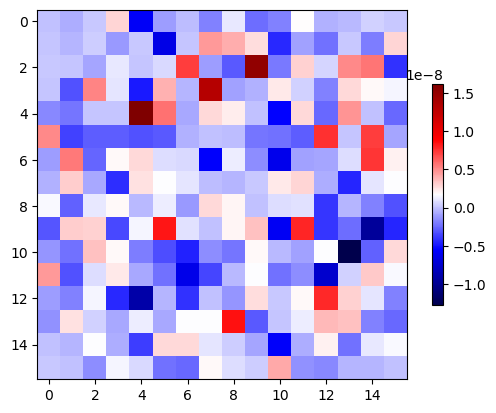

In [194]:
plt.imshow(Jacobi_2_diff[1,:,:].real, cmap='seismic')
plt.colorbar(shrink=0.6)

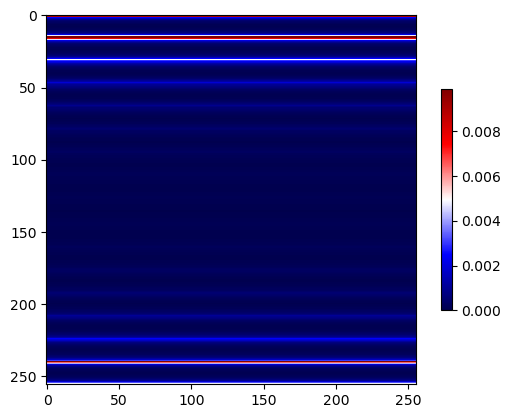

In [98]:
Ck[K_squared == 0] = 0  # avoid division by zero at k = 0
Ck_ = np.tile(Ck.flatten(order='F')[:,None], (1,K**2))
plt.imshow(Ck_[:, :], cmap='seismic')
plt.colorbar(shrink=0.6)

/var/folders/lz/50081q0n24g8lq6ncqpbp8780000gn/T/ipykernel_44600/4265896167.py:2: RuntimeWarning: invalid value encountered in multiply
  plt.imshow(Ck*linear_A1_diag[:, :].real, cmap='seismic')


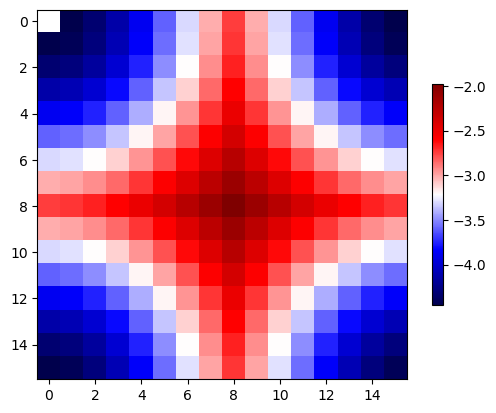

In [85]:
linear_A1_diag = 1j * KX * (kd**2/2 * beta + kd**2 * K_squared * U) - (kd**2/2 * kappa * K_squared)
plt.imshow(Ck*linear_A1_diag[:, :].real, cmap='seismic')
plt.colorbar(shrink=0.6)

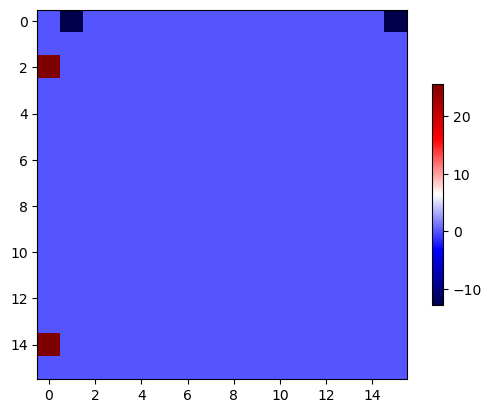

In [95]:
plt.imshow(1/kd**2 * h_hat.real[:,:], cmap='seismic')
plt.colorbar(shrink=0.6)

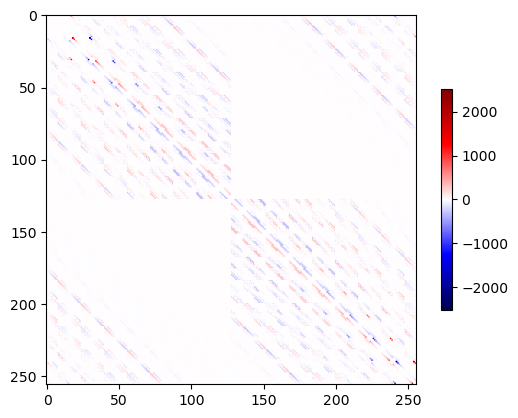

In [126]:
plt.imshow(nonlinear_A1.real[0,:,:], cmap='seismic')
plt.colorbar(shrink=0.6)

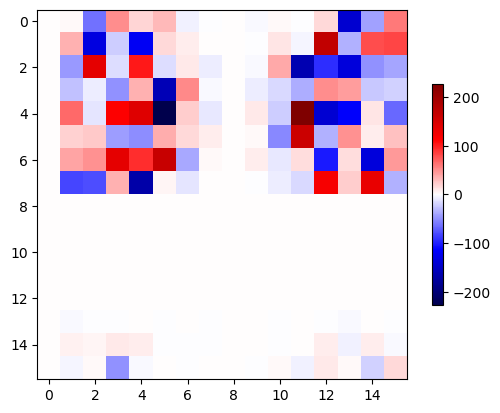

In [156]:
plt.imshow(nonlinear_A1.real[3,4,:].reshape((K,K), order='F'), cmap='seismic')
plt.colorbar(shrink=0.6)

In [132]:
nonlinear_A1.real[0,16,18]

2522.9953051994403

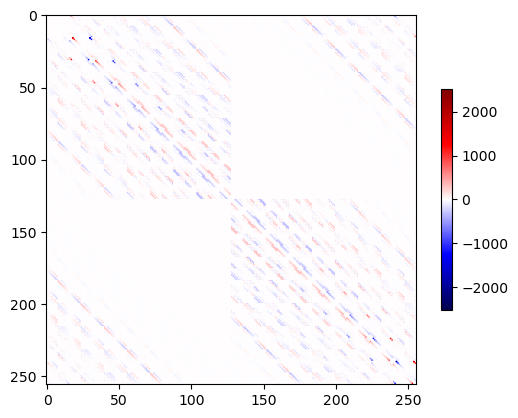

In [140]:
plt.imshow(A1_t[1, :, :].real, cmap='seismic')
plt.colorbar(shrink=0.6)

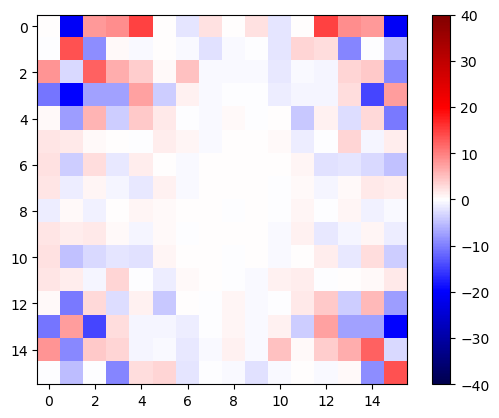

In [150]:
plt.imshow(mu_t[:,1].real.reshape((K,K), order='F'), cmap='seismic', vmin=-40, vmax=40)
plt.colorbar()

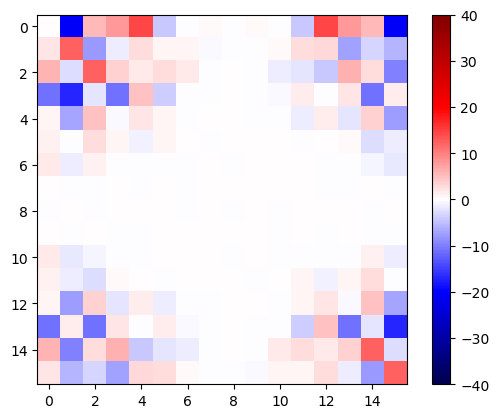

In [63]:
plt.imshow(psi2_k_t[:,:,1].real, cmap='seismic', vmin=-40, vmax=40)
plt.colorbar()

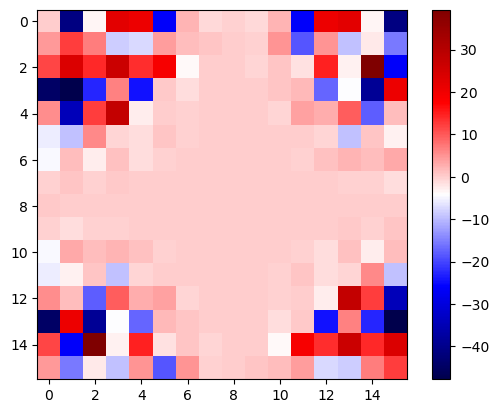

In [157]:
plt.imshow(psi1_k_t[:,:,3].real, cmap='seismic')
plt.colorbar()

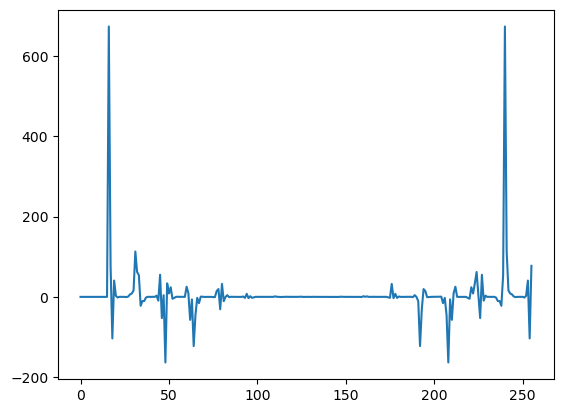

In [70]:
plt.plot(A0_t[1,:].real)

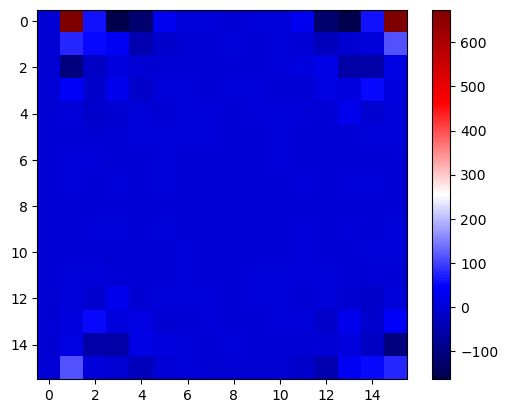

In [45]:
plt.imshow(A0_t[1,:].real.reshape((K,K), order='F'), cmap='seismic')
plt.colorbar()

In [135]:
mu_t.shape

(256, 500)

In [139]:
mu_t[2,2,:]

array([1.22836627e+001-1.14806153e+001j, 1.24020793e+001-9.65818455e+000j,
       1.31810576e+001+1.16952413e+001j, 1.49232673e+003+1.44052143e+004j,
       1.20673561e+009+1.17282687e+010j, 7.99457917e+020+7.76993511e+021j,
       3.50621922e+044+3.40769605e+045j, 6.73908388e+091+6.54971867e+092j,
       2.48769836e+186+2.41779516e+187j,             nan            +nanj,
                   nan            +nanj,             nan            +nanj,
                   nan            +nanj,             nan            +nanj,
                   nan            +nanj,             nan            +nanj,
                   nan            +nanj,             nan            +nanj,
                   nan            +nanj,             nan            +nanj,
                   nan            +nanj,             nan            +nanj,
                   nan            +nanj,             nan            +nanj,
                   nan            +nanj,             nan            +nanj,
                   nan   

In [9]:
psi2_k_t[iky, ikx, :].real

array([12.28366273, 12.2898445 , 12.29595147, ..., -7.28020287,
       -7.27763211, -7.27503283])

# Appendix

### how to determine the posterier variance of two layers?

In [71]:
def eigen2layer_R(K,cut,r1,r2,R_psi_k,R_tau_k):
    N = R_psi_k.shape[-1]
    R_psi1_k = np.zeros((K,K,N))
    R_psi2_k = np.zeros((K,K,N))
    kx = np.fft.fftfreq(K) * K
    ky = np.fft.fftfreq(K) * K
    for ikx,kx_value in enumerate(kx):
        for iky,ky_value in enumerate(ky): 
            if (kx_value == 0 and ky_value==0) or abs(kx_value) >= (K//2-cut) or abs(ky_value) >= (K//2-cut):  # Skip the case where k_mag is 0 and truncation
                continue
            R_psi1_k[iky,ikx,:] = r1[iky,ikx,0]**2 * R_psi_k[iky,ikx,:] + r2[iky,ikx,0]**2 * R_tau_k[iky,ikx,:]
            R_psi2_k[iky,ikx,:] = r1[iky,ikx,1]**2 * R_psi_k[iky,ikx,:] + r2[iky,ikx,1]**2 * R_tau_k[iky,ikx,:]
            
    return R_psi1_k, R_psi2_k

In [72]:
R_psi_k_pos, R_tau_k_pos = mu2psi(R_ts[-1], K, cut)
R_psi_k_pos_ = inv_truncate(R_psi_k_pos, cut)
R_tau_k_pos_ = inv_truncate(R_tau_k_pos, cut)
R_psi1_k_pos, R_psi2_k_pos = eigen2layer_R(K,cut,r1,r2,R_psi_k_pos_,R_tau_k_pos_)

/var/folders/lz/50081q0n24g8lq6ncqpbp8780000gn/T/ipykernel_38551/1502891122.py:11: ComplexWarning: Casting complex values to real discards the imaginary part
  R_psi1_k[iky,ikx,:] = r1[iky,ikx,0]**2 * R_psi_k[iky,ikx,:] + r2[iky,ikx,0]**2 * R_tau_k[iky,ikx,:]
/var/folders/lz/50081q0n24g8lq6ncqpbp8780000gn/T/ipykernel_38551/1502891122.py:12: ComplexWarning: Casting complex values to real discards the imaginary part
  R_psi2_k[iky,ikx,:] = r1[iky,ikx,1]**2 * R_psi_k[iky,ikx,:] + r2[iky,ikx,1]**2 * R_tau_k[iky,ikx,:]


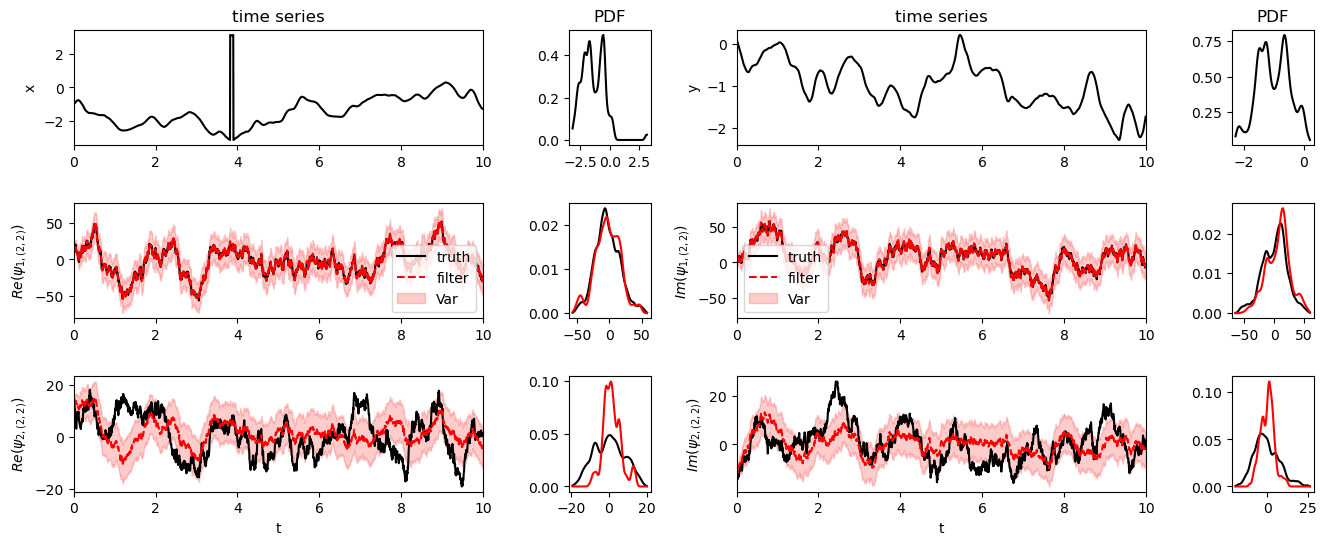

In [78]:
# Plot
psi_k_pos, tau_k_pos = mu2psi(mu_ts[-1], K, cut)
psi_k_pos_ = inv_truncate(psi_k_pos, cut)
tau_k_pos_ = inv_truncate(tau_k_pos, cut)
psi1_k_pos, psi2_k_pos = eigen2layer(K,cut,r1,r2,psi_k_pos_,tau_k_pos_)

sel0 = 0; sel1 = N # plot time range
ikx = 2; iky = 2 # mode to plot
interv = 10 # plot interval
xaxis = np.arange(sel0*dt, sel1*dt, interv*dt)

fig = plt.figure(figsize=(16,6))
widths = [5, 1, 5, 1]
heights = [2, 2, 2]
spec = fig.add_gridspec(ncols=4, nrows=3, width_ratios=widths, height_ratios=heights)

plt.subplots_adjust(wspace=0.35, hspace=0.5)     # Adjust the overall spacing of the figure
ax1 = fig.add_subplot(spec[0, 0])
ax2 = fig.add_subplot(spec[1, 0])
ax3 = fig.add_subplot(spec[2, 0])
ax4 = fig.add_subplot(spec[0, 1])
ax5 = fig.add_subplot(spec[1, 1])
ax6 = fig.add_subplot(spec[2, 1])
ax11 = fig.add_subplot(spec[0, 2])
ax22 = fig.add_subplot(spec[1, 2])
ax33 = fig.add_subplot(spec[2, 2])
ax44 = fig.add_subplot(spec[0, 3])
ax55 = fig.add_subplot(spec[1, 3])
ax66 = fig.add_subplot(spec[2, 3])

# plot time series
ax1.plot(xaxis, xt[0,sel0:sel1:interv], 'k', label='x')
ax1.set_xlim(sel0*dt, sel1*dt)
ax1.set_ylabel('x')
ax1.set_title('time series')

ax2.plot(xaxis, psi1_k_t[iky,ikx,sel0:sel1:interv].real, label='truth', color='black')
ax2.plot(xaxis, psi1_k_pos[iky,ikx,sel0:sel1:interv].real, label='filter', color='red', linestyle='--')
ax2.fill_between(xaxis, psi1_k_pos[iky,ikx,sel0:sel1:interv].real - np.sqrt(R_psi1_k_pos[iky,ikx,sel0:sel1:interv]), psi1_k_pos[iky,ikx,sel0:sel1:interv].real + np.sqrt(R_psi1_k_pos[iky,ikx,sel0:sel1:interv]), color='red', alpha=0.2, label='Var')
ax2.set_xlim(sel0*dt, sel1*dt)
ax2.set_ylabel('$Re(\psi_{{1,({:d},{:d})}})$'.format(ikx, iky))
ax2.legend()

ax3.plot(xaxis, psi2_k_t[iky,ikx,sel0:sel1:interv].real, label='truth', color='black')
ax3.plot(xaxis, psi2_k_pos[iky,ikx,sel0:sel1:interv].real, label='filter', color='red', linestyle='--')
ax3.fill_between(xaxis, psi2_k_pos[iky,ikx,sel0:sel1:interv].real - np.sqrt(R_psi2_k_pos[iky,ikx,sel0:sel1:interv]), psi2_k_pos[iky,ikx,sel0:sel1:interv].real + np.sqrt(R_psi2_k_pos[iky,ikx,sel0:sel1:interv]), color='red', alpha=0.2, label='Var')
ax3.set_xlim(sel0*dt, sel1*dt)
ax3.set_ylabel(r'$Re(\psi_{{2,({:d},{:d})}})$'.format(ikx, iky))
ax3.set_xlabel('t')

# plot pdf
samples = xt[0, :]
kde = gaussian_kde(samples)
xticks = np.linspace(samples.min(), samples.max(), 100)
p = kde.evaluate(xticks)
ax4.plot(xticks, p, 'k')
ax4.set_title('PDF')

samples = psi1_k_t[iky, ikx, :].real
kde = gaussian_kde(samples)
xticks = np.linspace(samples.min(), samples.max(), 100)
p = kde.evaluate(xticks)
ax5.plot(xticks, p, 'k', label='truth')
samples = psi1_k_pos[iky, ikx, :].real
kde = gaussian_kde(samples)
p = kde.evaluate(xticks)
ax5.plot(xticks, p, 'r', label='filter')

samples = psi2_k_t[iky, ikx, :].real
kde = gaussian_kde(samples)
xticks = np.linspace(samples.min(), samples.max(), 100)
p = kde.evaluate(xticks)
ax6.plot(xticks, p, 'k', label='truth')
samples = psi2_k_pos[iky, ikx, :].real
kde = gaussian_kde(samples)
p = kde.evaluate(xticks)
ax6.plot(xticks, p, 'r', label='filter')

ax11.plot(xaxis, yt[0,sel0:sel1:interv], 'k')
ax11.set_xlim(sel0*dt, sel1*dt)
ax11.set_ylabel('y')
ax11.set_title('time series')

ax22.plot(xaxis, psi1_k_t[iky,ikx,sel0:sel1:interv].imag, label='truth', color='black')
ax22.plot(xaxis, psi1_k_pos[iky,ikx,sel0:sel1:interv].imag, label='filter', color='red', linestyle='--')
ax22.fill_between(xaxis, psi1_k_pos[iky,ikx,sel0:sel1:interv].imag - np.sqrt(R_psi1_k_pos[iky,ikx,sel0:sel1:interv]), psi1_k_pos[iky,ikx,sel0:sel1:interv].imag + np.sqrt(R_psi1_k_pos[iky,ikx,sel0:sel1:interv]), color='red', alpha=0.2, label='Var')
ax22.set_xlim(sel0*dt, sel1*dt)
ax22.set_ylabel('$Im(\psi_{{1,({:d},{:d})}})$'.format(ikx, iky))
ax22.legend()

ax33.plot(xaxis, psi2_k_t[iky,ikx,sel0:sel1:interv].imag, label='truth', color='black')
ax33.plot(xaxis, psi2_k_pos[iky,ikx,sel0:sel1:interv].imag, label='filter', color='red', linestyle='--')
ax33.fill_between(xaxis, psi2_k_pos[iky,ikx,sel0:sel1:interv].imag - np.sqrt(R_psi2_k_pos[iky,ikx,sel0:sel1:interv]), psi2_k_pos[iky,ikx,sel0:sel1:interv].imag + np.sqrt(R_psi2_k_pos[iky,ikx,sel0:sel1:interv]), color='red', alpha=0.2, label='Var')
ax33.set_xlim(sel0*dt, sel1*dt)
# ax33.set_ylim(-80,80)
ax33.set_ylabel(r'$Im(\psi_{{2,({:d},{:d})}})$'.format(ikx, iky))
ax33.set_xlabel('t')

# plot pdf
samples = yt[0, :]
kde = gaussian_kde(samples)
xticks = np.linspace(samples.min(), samples.max(), 100)
p = kde.evaluate(xticks)
ax44.plot(xticks, p, 'k')
ax44.set_title('PDF')

samples = psi1_k_t[iky, ikx, :].imag
kde = gaussian_kde(samples)
xticks = np.linspace(samples.min(), samples.max(), 100)
p = kde.evaluate(xticks)
ax55.plot(xticks, p, 'k', label='truth')
samples = psi1_k_pos[iky, ikx, :].imag
kde = gaussian_kde(samples)
p = kde.evaluate(xticks)
ax55.plot(xticks, p, 'r', label='filter')

samples = psi2_k_t[iky, ikx, :].imag
kde = gaussian_kde(samples)
xticks = np.linspace(samples.min(), samples.max(), 100)
p = kde.evaluate(xticks)
ax66.plot(xticks, p, 'k', label='truth')
samples = psi2_k_pos[iky, ikx, :].imag
kde = gaussian_kde(samples)
p = kde.evaluate(xticks)
ax66.plot(xticks, p, 'r', label='filter')
# plt.savefig('./Lagrangian_DA/LagDA_K16_L64.png',dpi=100)
plt.show()

## visualize conjugate pair

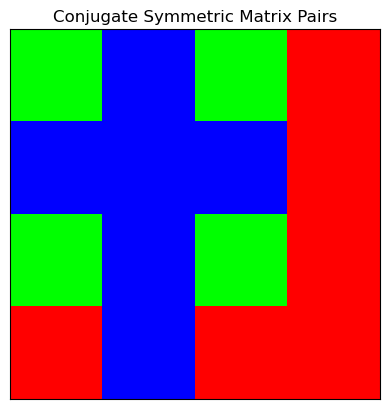

In [103]:
import numpy as np
import matplotlib.pyplot as plt

def plot_conjugate_symmetric_pairs(matrix):
    '''plot the conjugate pairs of a conjugate symmetrix matrix'''
    K = matrix.shape[0]
    kx = np.fft.fftfreq(K) * K
    ky = np.fft.fftfreq(K) * K

    # color matrix
    color_matrix = np.zeros((K, K, 3))  # RGB channels
    blue = [0, 0, 1]  # Blue color
    red = [1, 0, 0]   # Red color
    green = [0, 1, 0] # Green for central elements

    # Fill the color matrix
    for ikx, kx_value in enumerate(kx):
        for iky, ky_value in enumerate(ky):
            if np.mod(kx_value,K/2)==0 and np.mod(ky_value,K/2)==0: # real values if K is even
                color_matrix[iky, ikx] = green
            elif kx_value>0 or ((kx_value == 0 or kx_value==-K/2) and ky_value > 0): # half of modes
                color_matrix[iky, ikx] = blue
                color_matrix[-iky, -ikx] = red

    return color_matrix

K = 4
Y = np.zeros((K,K))
color_matrix = plot_conjugate_symmetric_pairs(Y)
color_matrix_shift = np.roll(color_matrix, shift=K//2, axis=0) 
color_matrix_shift = np.roll(color_matrix_shift, shift=K//2, axis=1)

# Plotting
fig, ax = plt.subplots()
ax.imshow(color_matrix, interpolation='nearest')
ax.set_xticks([])
ax.set_yticks([])
plt.title('Conjugate Symmetric Matrix Pairs')
plt.show()

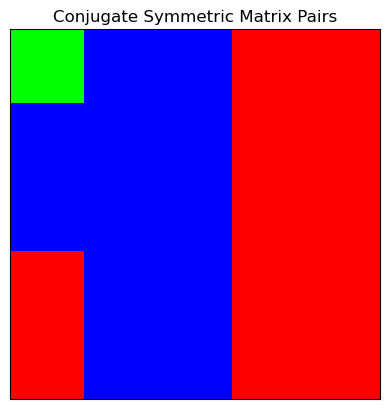

In [664]:
import numpy as np
import matplotlib.pyplot as plt

def plot_conjugate_symmetric_pairs(matrix):
    '''plot the conjugate pairs of a conjugate symmetrix matrix'''
    K = matrix.shape[0]
    kx = np.fft.fftfreq(K) * K
    ky = np.fft.fftfreq(K) * K

    # color matrix
    color_matrix = np.zeros((K, K, 3))  # RGB channels
    blue = [0, 0, 1]  # Blue color
    red = [1, 0, 0]   # Red color
    green = [0, 1, 0] # Green for central elements

    # Fill the color matrix
    for ikx, kx_value in enumerate(kx):
        for iky, ky_value in enumerate(ky):
            if np.mod(kx_value,K/2)==0 and np.mod(ky_value,K/2)==0: # real values if K is even
                color_matrix[iky, ikx] = green
            elif kx_value>0 or ((kx_value == 0 or kx_value==-K/2) and ky_value > 0): # half of modes
                color_matrix[iky, ikx] = blue
                color_matrix[-iky, -ikx] = red

    return color_matrix

K = 5
Y = np.zeros((K,K))
color_matrix = plot_conjugate_symmetric_pairs(Y)
color_matrix_shift = np.roll(color_matrix, shift=K//2, axis=0) 
color_matrix_shift = np.roll(color_matrix_shift, shift=K//2, axis=1)

# Plotting
fig, ax = plt.subplots()
ax.imshow(color_matrix, interpolation='nearest')
ax.set_xticks([])
ax.set_yticks([])
plt.title('Conjugate Symmetric Matrix Pairs')
plt.show()

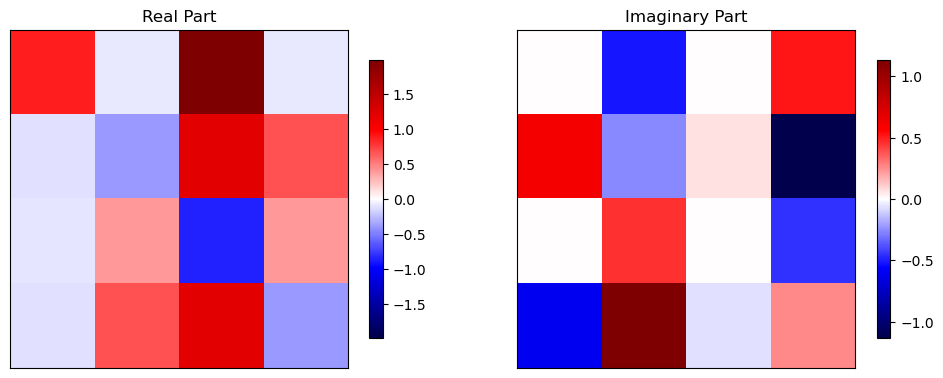

In [117]:
def avg_conj_symm(matrix):
    '''modify a input matrix to conjugate symmetric 
       by averaging the magnitude of real and imag parts of conjugate pairs'''
    # if input matrix is not complex, convert it to be complex
    if matrix.dtype == 'complex128':
        matirx = matrix + 0j
        
    K = matrix.shape[0]
    kx = np.fft.fftfreq(K) * K
    ky = np.fft.fftfreq(K) * K

    for ikx, kx_value in enumerate(kx):
        for iky, ky_value in enumerate(ky):
            if np.mod(kx_value,K/2)==0 and np.mod(ky_value,K/2)==0: # enforce real-value if K is even
                matrix[iky, ikx] = matrix[iky, ikx].real
            elif kx_value>0 or ((kx_value == 0 or kx_value==-K/2) and ky_value > 0): # half of modes
                real_mean = (matrix[iky, ikx].real + matrix[-iky, -ikx].real) / 2
                imag_mean = (matrix[iky, ikx].imag - matrix[-iky, -ikx].imag) / 2
                matrix[iky, ikx] = real_mean + 1j*imag_mean
                matrix[-iky, -ikx] = real_mean - 1j*imag_mean

    return matrix

K = 4
Y = np.random.randn(K,K) + 1j*np.random.randn(K,K)
Y_conj_symm = avg_conj_symm(Y)
Y_conj_symm_shift = np.roll(Y_conj_symm, shift=K//2, axis=0) 
Y_conj_symm_shift = np.roll(Y_conj_symm_shift, shift=K//2, axis=1)

# plot
fig, axs = plt.subplots(1, 2, figsize=(12, 6))  
# Plot the real part
surf1 = axs[0].imshow(Y_conj_symm_shift.real, interpolation='nearest', cmap='seismic', vmin=-np.max(abs(Y_conj_symm_shift.real)), vmax=np.max(abs(Y_conj_symm_shift.real)))
axs[0].set_xticks([])
axs[0].set_yticks([])
axs[0].set_title('Real Part')
fig.colorbar(surf1, shrink=0.6)

# Plot the imaginary part
surf2 = axs[1].imshow(Y_conj_symm_shift.imag, interpolation='nearest', cmap='seismic', vmin=-np.max(abs(Y_conj_symm_shift.imag)), vmax=np.max(abs(Y_conj_symm_shift.imag)))
axs[1].set_xticks([])
axs[1].set_yticks([])
axs[1].set_title('Imaginary Part')
fig.colorbar(surf2, shrink=0.6)
plt.show()

In [118]:
def verify_conjugate_symmetry(Y):
    """
    Checks if the matrix Y is conjugate symmetric based on the given conditions.
    
    Parameters:
    - Y: np.ndarray, a numpy array representing the matrix.
    
    Returns:
    - bool, True if the matrix Y is conjugate symmetric, False otherwise.
    """
    # Condition 1: Check if Y[0, 1:] is conjugate symmetric
    condition1 = np.allclose(Y[0, 1:], np.conj(Y[0, -1:0:-1]))
    
    # Condition 2: Check if Y[1:, 0] is conjugate symmetric
    condition2 = np.allclose(Y[1:, 0], np.conj(Y[-1:0:-1, 0]))
    
    # Condition 3: Check if Y[1:, 1:] is conjugate centrosymmetric
    condition3 = np.allclose(Y[1:, 1:], np.conj(Y[-1:0:-1, -1:0:-1]))
    
    # Return True if all conditions are met, False otherwise
    return condition1 and condition2 and condition3

verify_conjugate_symmetry(Y_conj_symm)

True

# Conditional Gaussian QG

In [19]:
from sympy import symbols, I
from sympy import simplify
# from sympy import latex


# Define variables and symbols
k_x, k_d, U, beta, kappa = symbols('k_x k_d U beta kappa', real=True)
psi_1k, psi_2k, h_k = symbols('psi_1k psi_2k h_k')
k = symbols('|\mathbf{k}|', real=True)

# Define the RHS expressions
RHS_1 = -I*k_x*((beta - U*k**2 + (k_d**2/2)*U)*psi_1k + (k_d**2/2)*U*psi_2k)
RHS_2 = -I*k_x*((beta + U*k**2 - (k_d**2/2)*U)*psi_2k - (k_d**2/2)*U*psi_1k - U*h_k) + kappa*k**2*psi_2k

# Plug into the main equation
d_psi_1k_dt = -  ((k**2 + (k_d**2/2)) * RHS_1 + (k_d**2/2) * RHS_2)
d_psi_2k_dt = -  ((k_d**2/2) * RHS_1 + (k**2 + (k_d**2/2)) * RHS_2)

simplify(d_psi_1k_dt), simplify(d_psi_2k_dt)


(-I*U*h_k*k_d**2*k_x/2 + I*U*k_d**2*k_x*psi_2k*|\mathbf{k}|**2 - I*U*k_x*psi_1k*|\mathbf{k}|**4 + I*beta*k_d**2*k_x*psi_1k/2 + I*beta*k_d**2*k_x*psi_2k/2 + I*beta*k_x*psi_1k*|\mathbf{k}|**2 - k_d**2*kappa*psi_2k*|\mathbf{k}|**2/2,
 I*k_d**2*k_x*(U*k_d**2*psi_2k + psi_1k*(U*k_d**2 - 2*U*|\mathbf{k}|**2 + 2*beta))/4 - (k_d**2 + 2*|\mathbf{k}|**2)*(I*k_x*(2*U*h_k + U*k_d**2*psi_1k - psi_2k*(-U*k_d**2 + 2*U*|\mathbf{k}|**2 + 2*beta)) + 2*kappa*psi_2k*|\mathbf{k}|**2)/4)

# Sequential Layer Assimilation

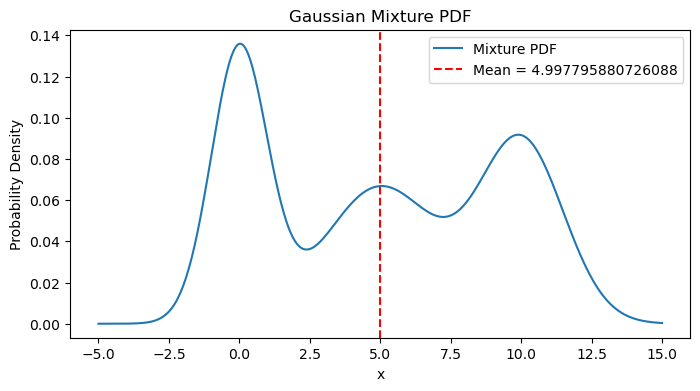

The mean of the Gaussian mixture is: 4.997795880726088


In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.integrate import trapz

def gaussian_mixture_pdf(x, means, stds, weights):
    """Compute the PDF of a Gaussian Mixture at given points x.
    
    Args:
    x (np.array): Points at which to evaluate the PDF.
    means (np.array): Means of the Gaussian components.
    stds (np.array): Standard deviations of the Gaussian components.
    weights (np.array): Weights of each Gaussian component.
    
    Returns:
    np.array: Values of the mixture PDF at each point in x.
    """
    # Initialize the PDF array
    pdf = np.zeros_like(x)
    for mean, std, weight in zip(means, stds, weights):
        pdf += weight * norm.pdf(x, mean, std)
    return pdf

# Define parameters for each Gaussian component
means = np.array([0, 5, 10])
stds = np.array([1, 2, 1.5])
weights = np.array([1/3, 1/3, 1/3])  # Equal weights

# Points where we want to evaluate the mixture PDF
x = np.linspace(-5, 15, 400)

# Calculate the mixture PDF
mixture_pdf = gaussian_mixture_pdf(x, means, stds, weights)

# Calculate the mean of the mixture
# mixture_mean = np.mean(means)
mixture_mean = trapz(x * mixture_pdf, x)

# Plotting the mixture PDF
plt.figure(figsize=(8, 4))
plt.plot(x, mixture_pdf, label='Mixture PDF')
plt.title('Gaussian Mixture PDF')
plt.xlabel('x')
plt.ylabel('Probability Density')
plt.axvline(mixture_mean, color='r', linestyle='--', label=f'Mean = {mixture_mean}')
plt.legend()
plt.show()

print(f"The mean of the Gaussian mixture is: {mixture_mean}")


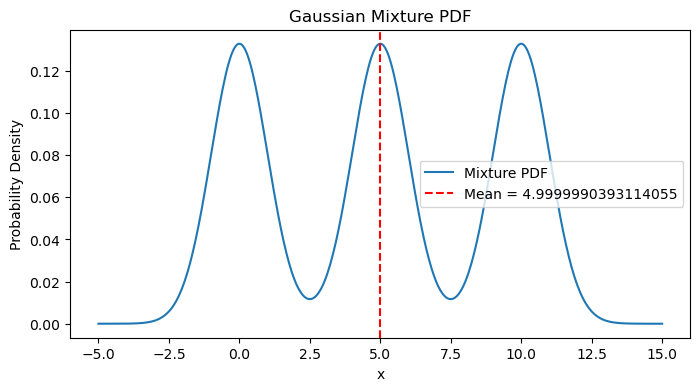

The mean of the Gaussian mixture is: 4.9999990393114055


In [4]:
# Define parameters for each Gaussian component
means = np.array([0, 5, 10])
stds = np.array([1, 1, 1])
weights = np.array([1/3, 1/3, 1/3])  # Equal weights

# Points where we want to evaluate the mixture PDF
x = np.linspace(-5, 15, 400)

# Calculate the mixture PDF
mixture_pdf = gaussian_mixture_pdf(x, means, stds, weights)

# Calculate the mean of the mixture
# mixture_mean = np.mean(means)
mixture_mean = trapz(x * mixture_pdf, x)

# Plotting the mixture PDF
plt.figure(figsize=(8, 4))
plt.plot(x, mixture_pdf, label='Mixture PDF')
plt.title('Gaussian Mixture PDF')
plt.xlabel('x')
plt.ylabel('Probability Density')
plt.axvline(mixture_mean, color='r', linestyle='--', label=f'Mean = {mixture_mean}')
plt.legend()
plt.show()

print(f"The mean of the Gaussian mixture is: {mixture_mean}")
